In [243]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from datetime import datetime
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from IPython.display import display, HTML
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from collections import Counter
import plotly.express as px
import country_converter as coco
nltk.download('stopwords')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 3)
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: unset; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/merlekuehlenborg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [244]:
#loading the dataset
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

df_trustpilot = pd.read_csv('data/data_trustpilot.csv', engine='python')

display(df_trustpilot.head())



rating location               username  number_reviews  verification repeat_reviewer  repeat_reviewer_encoded   company                                                                                                                                                                                                                                                                                          text                                                                                                                                                                                              text_processed  text_length  text_word_length  Sentiment_Blob  Sentiment_Blob_cat  Sentiment_VADER  Sentiment_VADER_cat                                    subject                      subject_processed  subject_length  subject_word_length answer answer_processed  answered_encoded date_of_experience          date_posted local_date_posted  month_local  local_hour     time_of_day  day_of_week_posted      day_type  days_between_experience_and_post   review_time  review_time_encoded
0       5       CA              Rob Crane               2    Redirected          repeat                        1  Flashbay                                                                                                                  The company rep I worked with made my transaction smooth and quick. The samples were so helpful and the item shipping was relatively very fast. I will be a repeat customer.                                                                                              company rep worked made transaction smooth quick samples helpful item shipping relatively fast repeat customer          110                15           0.311                 4.0            0.421                    4     The company rep I worked with made my…                company rep worked made              23                    4      0                0                 0         2024-06-15  2024-10-23 04:17:44        2024-10-22           10          21         Evening                   1  Business Day                               129   late_review                    0
1       5       US           Pat Anderson               1      Verified        one-time                        0  Flashbay  I highly recommend using Flashbay. Immediately after ordering I heard from them and they were attentive to every little detail. I had notebooks shipped to Alaska for a conference and they arrived in perfect condition and delivered on time! Can't say enough good things about Flashbay!  highly recommend using flashbay immediately ordering heard attentive every little detail notebooks shipped alaska conference arrived perfect condition delivered time cant say enough good things flashbay          202                26           0.345                 4.0            0.623                    5          I highly recommend using Flashbay        highly recommend using flashbay              31                    4      0                0                 0         2024-10-16  2024-10-16 19:34:05        2024-10-16           10          12  Business Hours                   2  Business Day                                 0  quick_review                    1
2       5       CZ       Margarita Orlova               1      Verified        one-time                        0  Flashbay                      I had the pleasure of working with Shelby Gibson on a large order that we needed to ship to different locations. Shelby was very responsive, very kind and helpful. The order process was smooth and the final products look great. Only positive feedback from my side.                             pleasure working shelby gibson large order needed ship different locations shelby responsive kind helpful order process smooth final products look great positive feedback side          175                24           0.320                 4.0            0.964                    5                     Great customer service

In [245]:
#First check
df_trustpilot['local_date_posted'] = pd.to_datetime(df_trustpilot['local_date_posted'])
df_trustpilot['date_of_experience'] = pd.to_datetime(df_trustpilot['date_of_experience'])
df_trustpilot['date_posted'] = pd.to_datetime(df_trustpilot['date_posted'])

print(df_trustpilot.columns)
display(df_trustpilot.info())

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64435 entries, 0 to 64434
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            64435 non-null  in

None

STAGE 1 - UNIVARIATE ANALYSIS


Analyzing binary column: repeat_reviewer

Distribution:
one-time: 36,205 (56.2%)
repeat: 28,230 (43.8%)


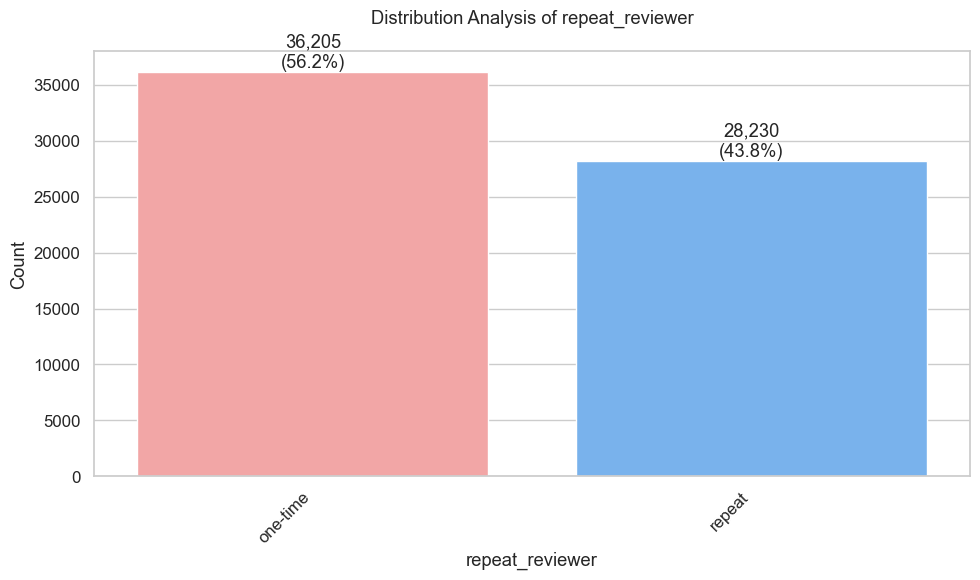


Analyzing binary column: repeat_reviewer_encoded

Distribution:
0: 36,205 (56.2%)
1: 28,230 (43.8%)


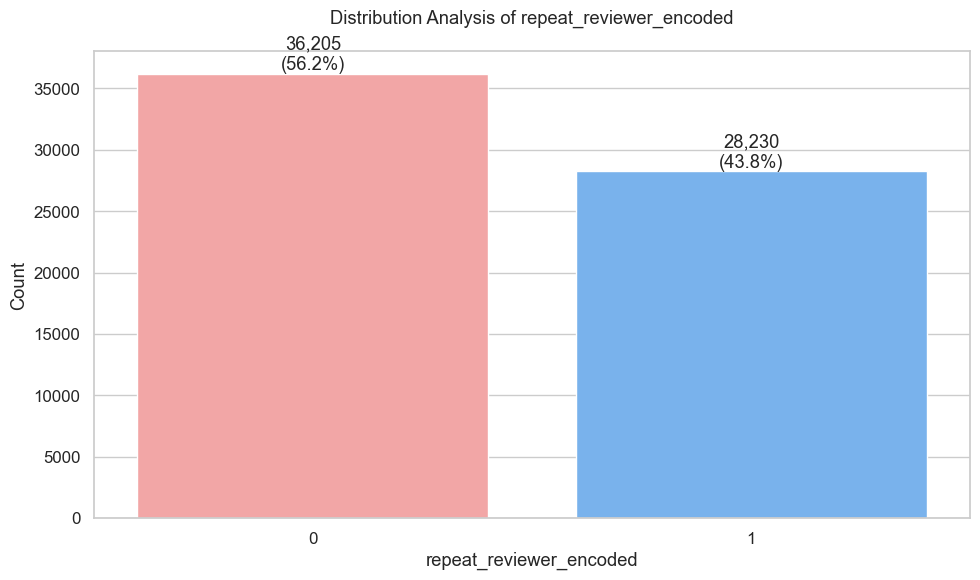


Analyzing binary column: answered_encoded

Distribution:
0: 48,396 (75.1%)
1: 16,039 (24.9%)


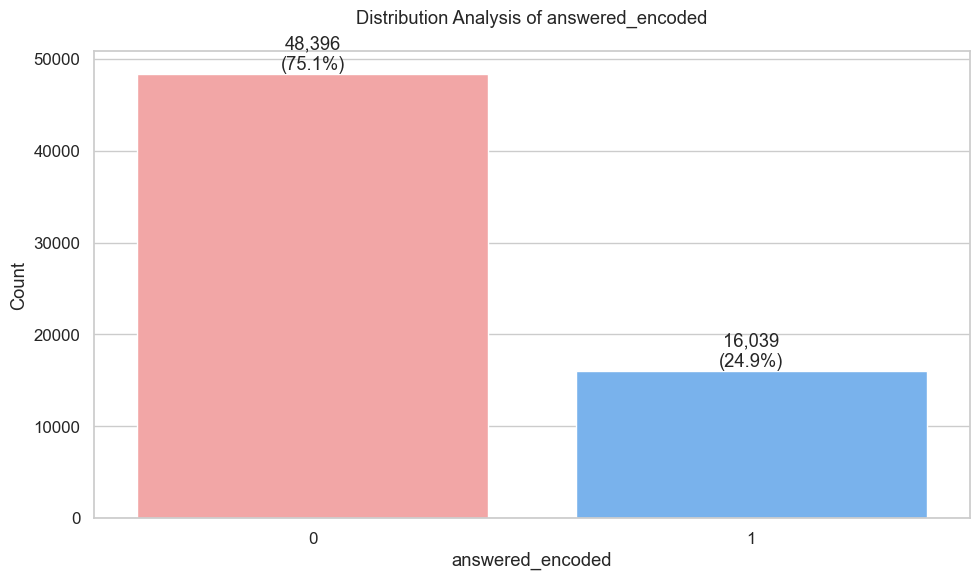


Analyzing binary column: day_type

Distribution:
Business Day: 52,542 (81.5%)
Weekend: 11,893 (18.5%)


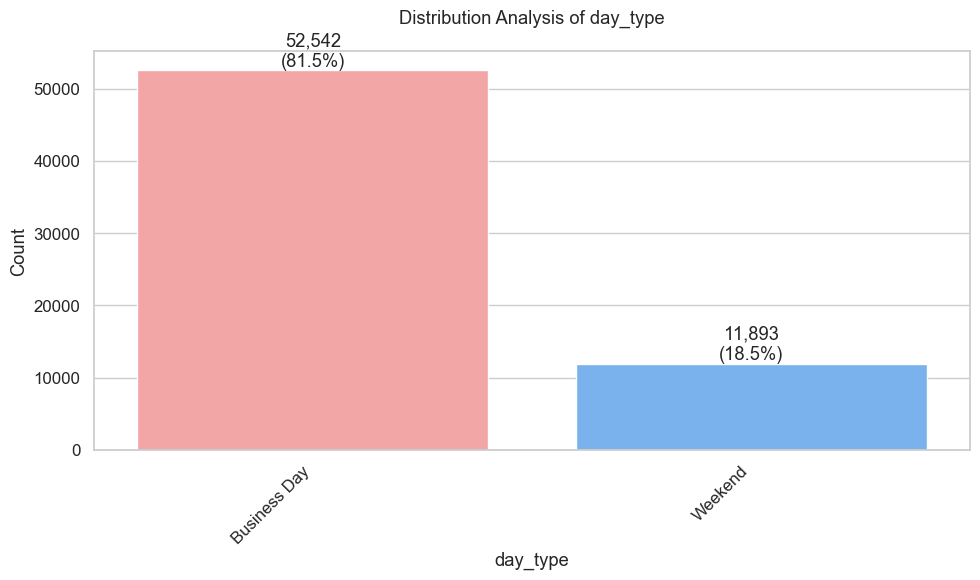


Analyzing binary column: review_time

Distribution:
quick_review: 51,324 (79.7%)
late_review: 13,111 (20.3%)


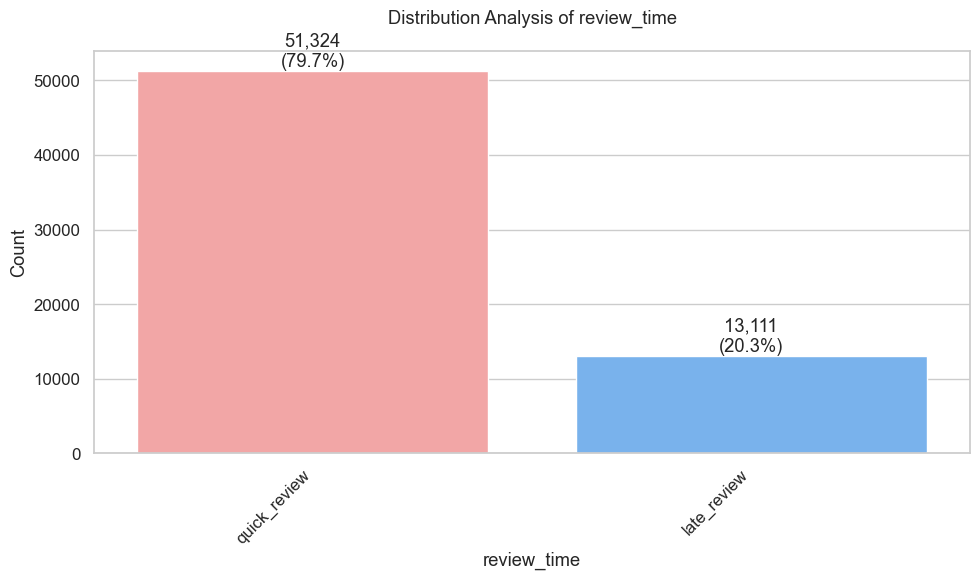


Analyzing binary column: review_time_encoded

Distribution:
1: 51,324 (79.7%)
0: 13,111 (20.3%)


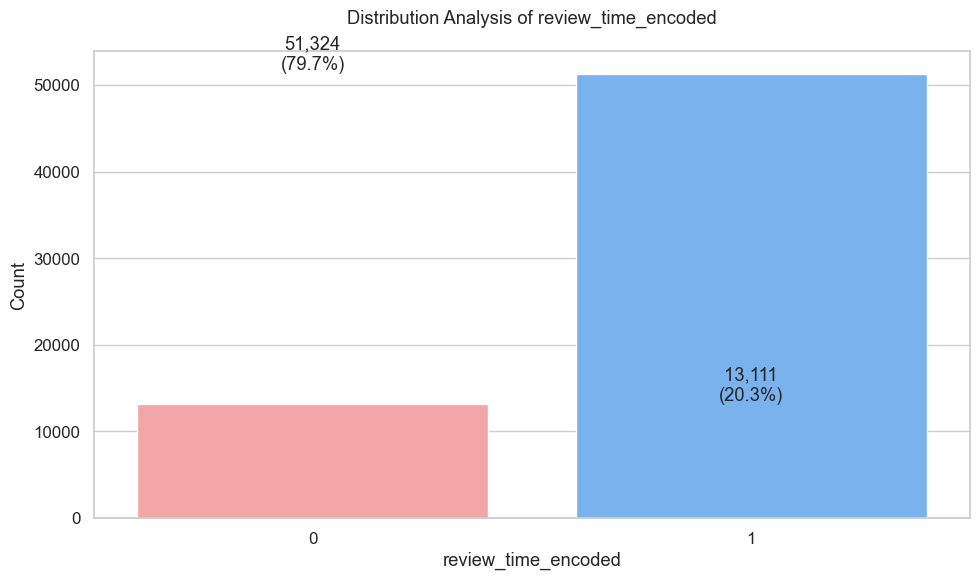

In [246]:
# Univariate analysis on binary columns
binary_columns = []
for column in df_trustpilot.columns:
    if len(df_trustpilot[column].unique()) == 2:
        binary_columns.append(column)

def analyze_binary_columns(df, binary_columns):
    sns.set_theme(style="whitegrid", palette="husl", font_scale=1.1)
    
    for column in binary_columns:
        print(f"\nAnalyzing binary column: {column}")
        print("="*50)
        
        value_counts = df[column].value_counts()
        percentages = df[column].value_counts(normalize=True) * 100
        
        # Display distributions
        print("\nDistribution:")
        for value, count in value_counts.items():
            pct = percentages[value]
            print(f"{value}: {count:,} ({pct:.1f}%)")
        
        plt.figure(figsize=(10, 6))
        # Create bar plot
        ax = sns.barplot(x=df[column].value_counts().index, 
                        y=df[column].value_counts().values,
                        palette=['#FF9999', '#66B2FF'])
        for i, v in enumerate(value_counts):
            ax.text(i, v, f'{v:,}\n({percentages[value_counts.index[i]]:.1f}%)', 
                   ha='center', va='bottom')
    
        plt.title(f'Distribution Analysis of {column}', pad=20)
        plt.xlabel(column)
        plt.ylabel('Count')
        
        if not np.issubdtype(df[column].dtype, np.number):
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()


analyze_binary_columns(df_trustpilot, binary_columns)

SENTIMENT SCORES ANALYSIS
Basic Statistics:
TextBlob Sentiment Statistics:
count    64435.000
mean         0.186
std          0.305
min         -1.000
25%          0.000
50%          0.175
75%          0.400
max          1.000
Name: Sentiment_Blob, dtype: float64
VADER Sentiment Statistics:
count    64435.000
mean         0.329
std          0.554
min         -0.997
25%          0.000
50%          0.477
75%          0.802
max          0.998
Name: Sentiment_VADER, dtype: float64


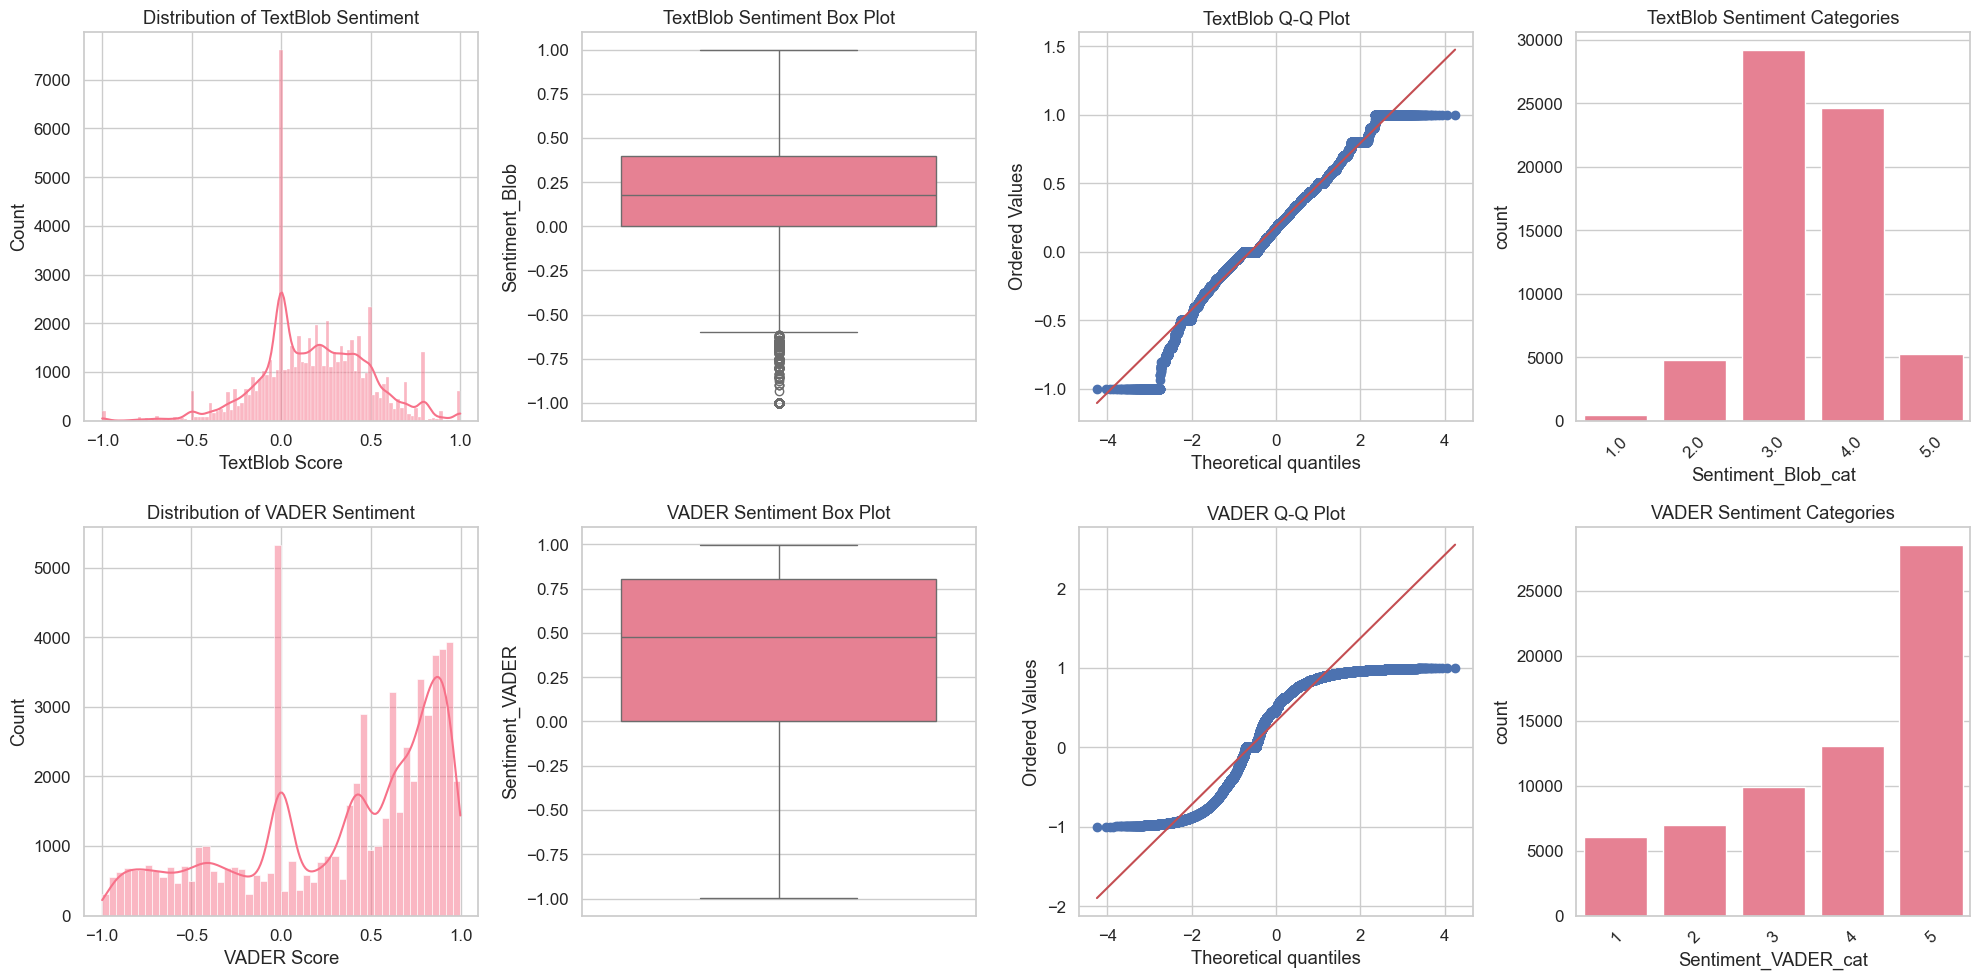

TextBlob Sentiment Category Distribution (%):
Sentiment_Blob_cat
3.0    45.4
4.0    38.4
5.0     8.1
2.0     7.4
1.0     0.7
Name: proportion, dtype: float64
VADER Sentiment Category Distribution (%):
Sentiment_VADER_cat
5    44.2
4    20.2
3    15.4
2    10.8
1     9.3
Name: proportion, dtype: float64


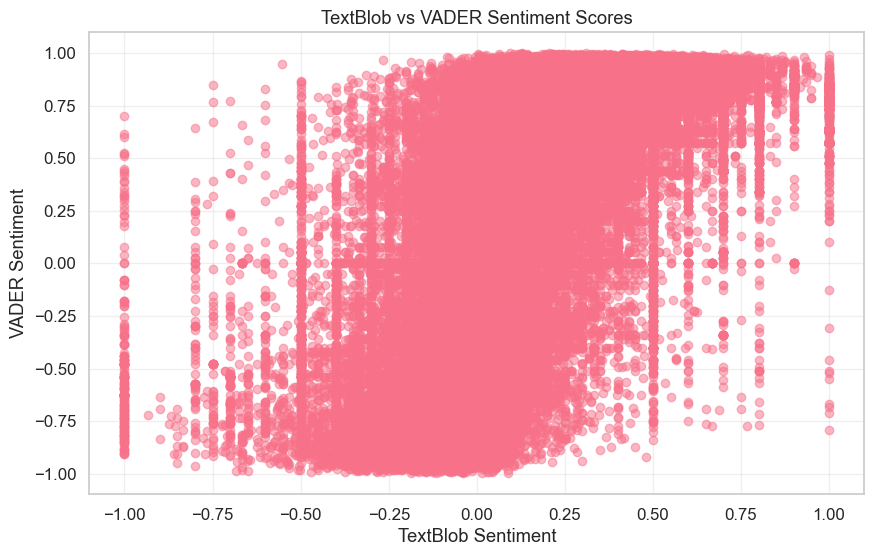

Correlation between TextBlob and VADER sentiment scores: 0.623


In [247]:
#Univariate analysis of sentiment scores

def analyze_sentiment_distributions():
    print("SENTIMENT SCORES ANALYSIS")
    
    print("Basic Statistics:")
    print("TextBlob Sentiment Statistics:")
    print(df_trustpilot['Sentiment_Blob'].describe().round(3))
    print("VADER Sentiment Statistics:")
    print(df_trustpilot['Sentiment_VADER'].describe().round(3))
    
    # Distribution plots
    fig = plt.figure(figsize=(20, 10))
    
    # TextBlob distributions
    plt.subplot(241)
    sns.histplot(data=df_trustpilot, x='Sentiment_Blob', kde=True)
    plt.title('Distribution of TextBlob Sentiment')
    plt.xlabel('TextBlob Score')
    
    plt.subplot(242)
    sns.boxplot(y=df_trustpilot['Sentiment_Blob'])
    plt.title('TextBlob Sentiment Box Plot')
    
    plt.subplot(243)
    stats.probplot(df_trustpilot['Sentiment_Blob'], dist="norm", plot=plt)
    plt.title('TextBlob Q-Q Plot')
    
    plt.subplot(244)
    sns.countplot(data=df_trustpilot, x='Sentiment_Blob_cat')
    plt.title('TextBlob Sentiment Categories')
    plt.xticks(rotation=45)
    
    # VADER distributions
    plt.subplot(245)
    sns.histplot(data=df_trustpilot, x='Sentiment_VADER', kde=True)
    plt.title('Distribution of VADER Sentiment')
    plt.xlabel('VADER Score')
    
    plt.subplot(246)
    sns.boxplot(y=df_trustpilot['Sentiment_VADER'])
    plt.title('VADER Sentiment Box Plot')
    
    plt.subplot(247)
    stats.probplot(df_trustpilot['Sentiment_VADER'], dist="norm", plot=plt)
    plt.title('VADER Q-Q Plot')
    
    plt.subplot(248)
    sns.countplot(data=df_trustpilot, x='Sentiment_VADER_cat')
    plt.title('VADER Sentiment Categories')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Category distributions
    print("TextBlob Sentiment Category Distribution (%):")
    print(df_trustpilot['Sentiment_Blob_cat'].value_counts(normalize=True).round(3) * 100)
    
    print("VADER Sentiment Category Distribution (%):")
    print(df_trustpilot['Sentiment_VADER_cat'].value_counts(normalize=True).round(3) * 100)
    
    # Compare sentiment metrics
    plt.figure(figsize=(10, 6))
    plt.scatter(df_trustpilot['Sentiment_Blob'], df_trustpilot['Sentiment_VADER'], alpha=0.5)
    plt.xlabel('TextBlob Sentiment')
    plt.ylabel('VADER Sentiment')
    plt.title('TextBlob vs VADER Sentiment Scores')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate correlation between sentiment metrics
    correlation = df_trustpilot['Sentiment_Blob'].corr(df_trustpilot['Sentiment_VADER'])
    print(f"Correlation between TextBlob and VADER sentiment scores: {correlation:.3f}")

analyze_sentiment_distributions()


In [248]:
sentiment_columns = ['Sentiment_Blob_cat','Sentiment_VADER', 'Sentiment_VADER_cat','Sentiment_Blob']
text_based_columns = ['text', 'text_processed', 'subject', 'subject_processed', 'answer', 'answer_processed']
administrative_columns = ['username']
univariate_pending_columns = list(set(df_trustpilot.columns) - set(binary_columns) - set(sentiment_columns) - set(text_based_columns) - set(administrative_columns))

print("Pending columns:", univariate_pending_columns)

display(df_trustpilot[univariate_pending_columns].head())

Pending columns: ['local_date_posted', 'location', 'date_of_experience', 'company', 'verification', 'date_posted', 'text_word_length', 'number_reviews', 'days_between_experience_and_post', 'month_local', 'rating', 'day_of_week_posted', 'subject_word_length', 'local_hour', 'time_of_day', 'text_length', 'subject_length']


local_date_posted location date_of_experience   company  verification         date_posted  text_word_length  number_reviews  days_between_experience_and_post  month_local  rating  day_of_week_posted  subject_word_length  local_hour     time_of_day  text_length  subject_length
0        2024-10-22       CA         2024-06-15  Flashbay    Redirected 2024-10-23 04:17:44                15               2                               129           10       5                   1                    4          21         Evening          110              23
1        2024-10-16       US         2024-10-16  Flashbay      Verified 2024-10-16 19:34:05                26               1                                 0           10       5                   2                    4          12  Business Hours          202              31
2        2024-10-17       CZ         2024-10-10  Flashbay      Verified 2024-10-17 10:27:44                24               1                                 7           10       5                   3                    3          10  Business Hours          175              22
3        2024-10-21       US         2024-10-21  Flashbay      Verified 2024-10-21 22:38:50                14               1                                 0           10       5                   0                    4          15  Business Hours          122              37
4        2024-10-22       CA         2024-07-11  Flashbay  Not Verified 2024-10-23 04:09:05                18               3                               103           10       5                   1                    3          21         Evening          155              23

Statistical analysis for column: company
Unique values: 4
Missing values: 0 (0.00%)
Top 10 Categories (Count and Percentage):
Quicken: 25,318 (39.3%)
Flashbay: 14,429 (22.4%)
SteelSeries: 12,387 (19.2%)
Asda: 12,301 (19.1%)
Visualizations for company


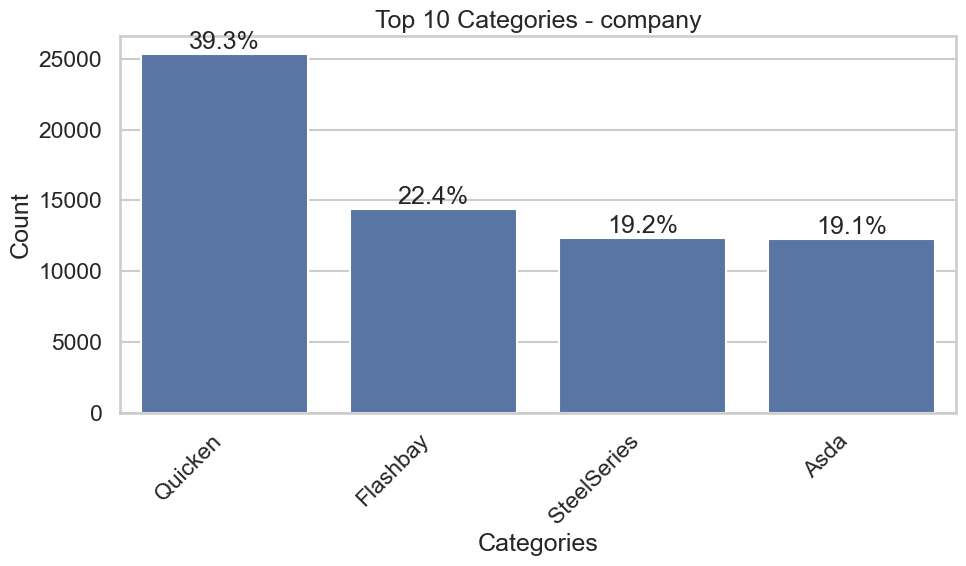

Statistical analysis for column: date_of_experience
Unique values: 4508
Missing values: 0 (0.00%)
Temporal Range:
Start: 2009-06-09 00:00:00
End: 2024-10-22 00:00:00
Range: 5614 days 00:00:00
Visualizations for date_of_experience


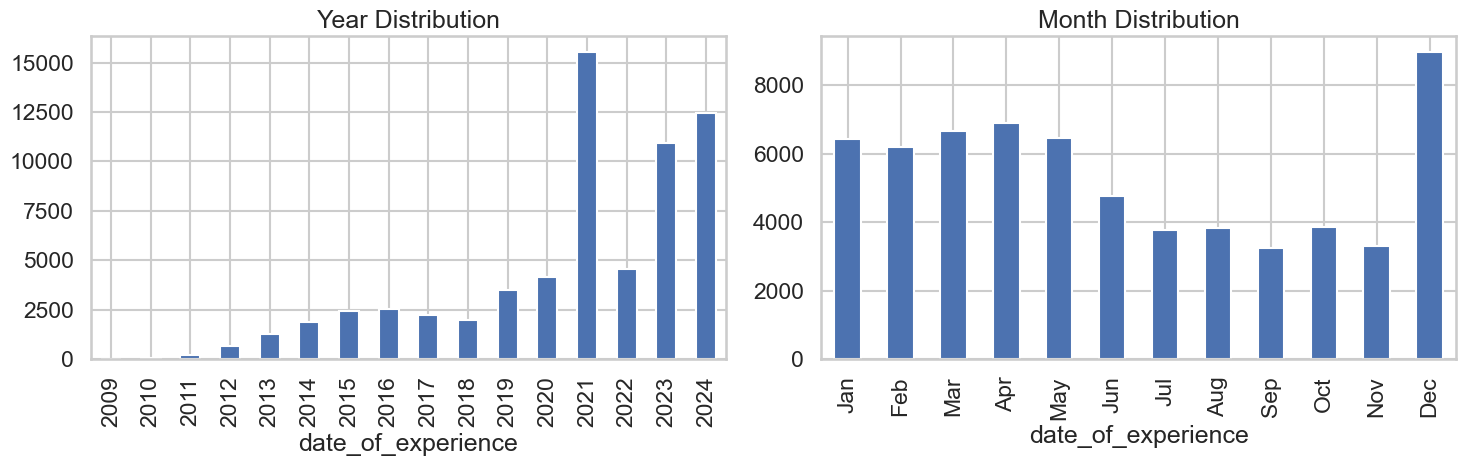

Statistical analysis for column: date_posted
Unique values: 64323
Missing values: 0 (0.00%)
Temporal Range:
Start: 2009-06-09 08:57:17
End: 2024-10-23 10:16:57
Range: 5615 days 01:19:40
Visualizations for date_posted


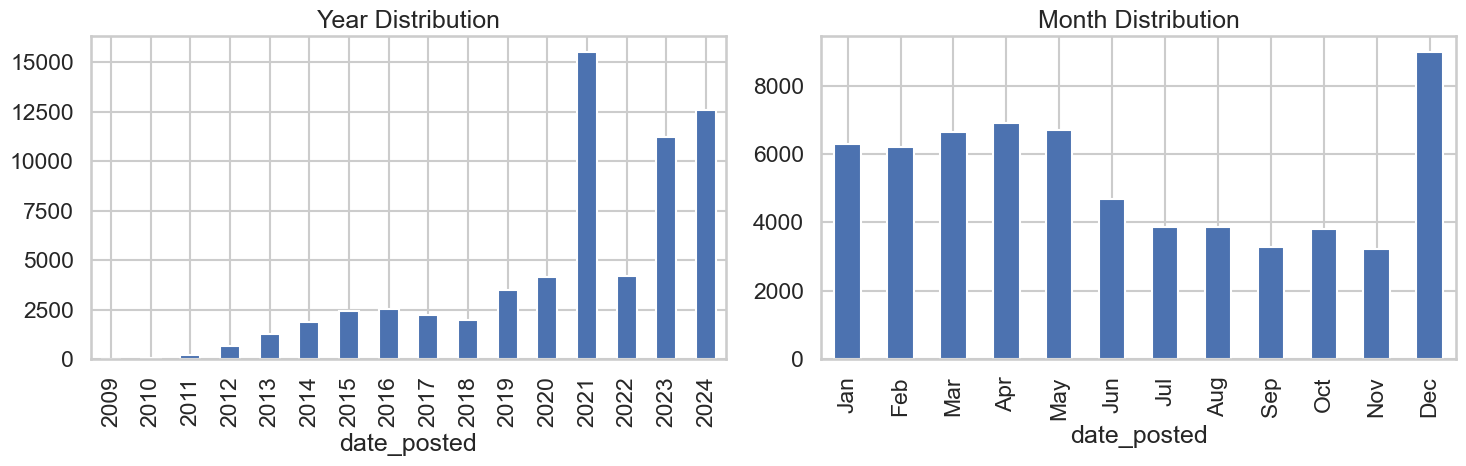

Statistical analysis for column: day_of_week_posted
Unique values: 7
Missing values: 0 (0.00%)
Descriptive Statistics:
count    64435.000
mean         2.618
std          1.846
min          0.000
25%          1.000
50%          2.000
75%          4.000
max          6.000
Name: day_of_week_posted, dtype: float64
Outliers: 0 (0.00%)
Visualizations for day_of_week_posted


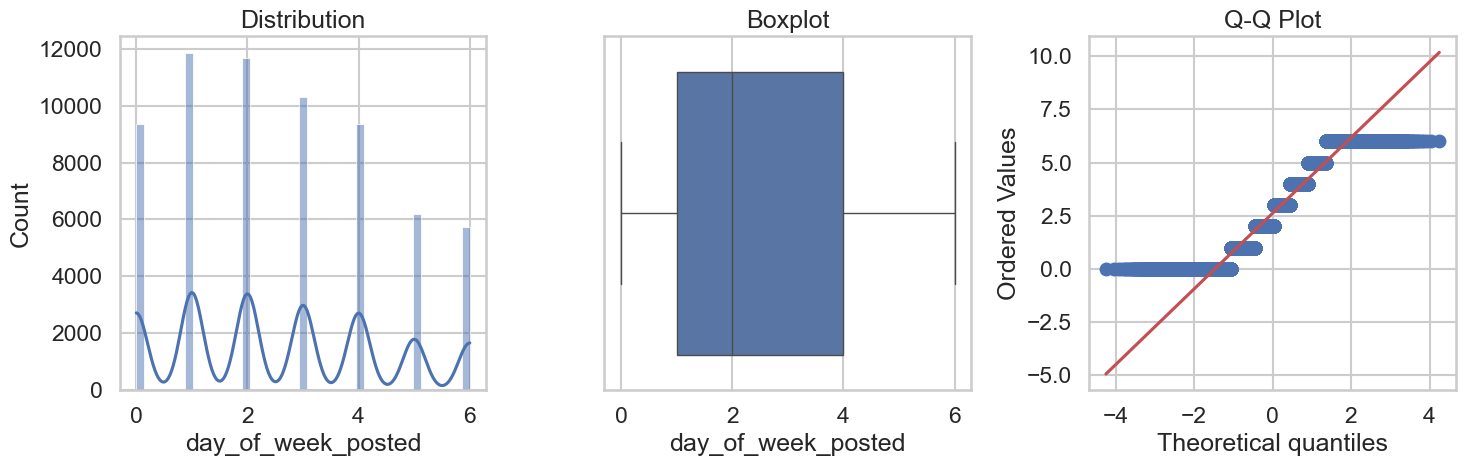

Statistical analysis for column: days_between_experience_and_post
Unique values: 301
Missing values: 0 (0.00%)
Descriptive Statistics:
count    64435.000
mean         3.444
std         35.226
min         -1.000
25%          0.000
50%          0.000
75%          0.000
max       3841.000
Name: days_between_experience_and_post, dtype: float64
Outliers: 17631 (27.36%)
Visualizations for days_between_experience_and_post


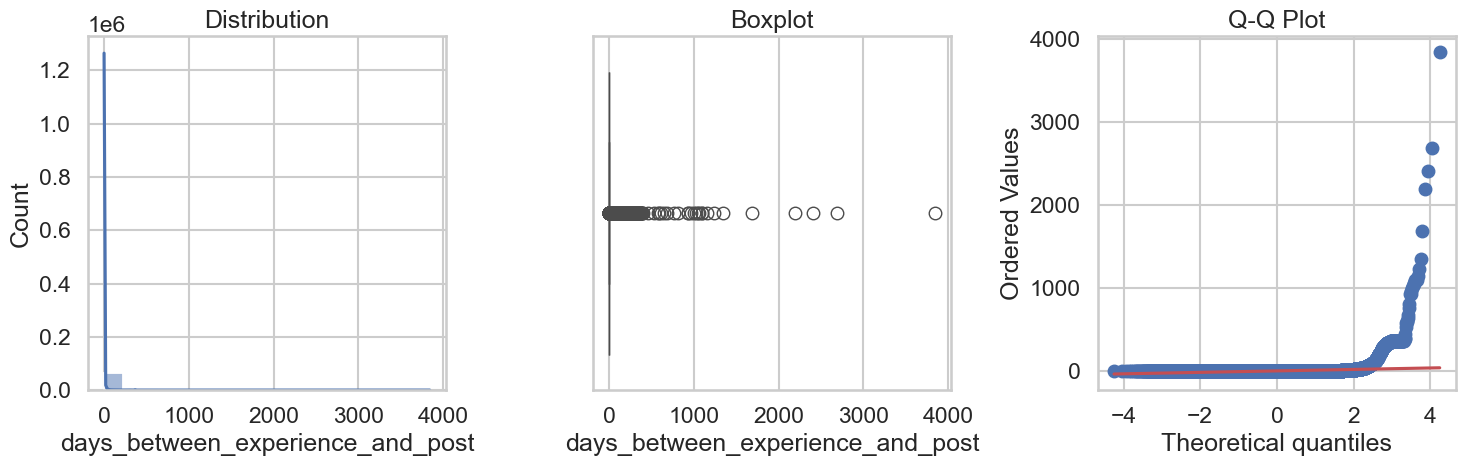

Statistical analysis for column: local_date_posted
Unique values: 4501
Missing values: 0 (0.00%)
Temporal Range:
Start: 2009-06-09 00:00:00
End: 2024-10-23 00:00:00
Range: 5615 days 00:00:00
Visualizations for local_date_posted


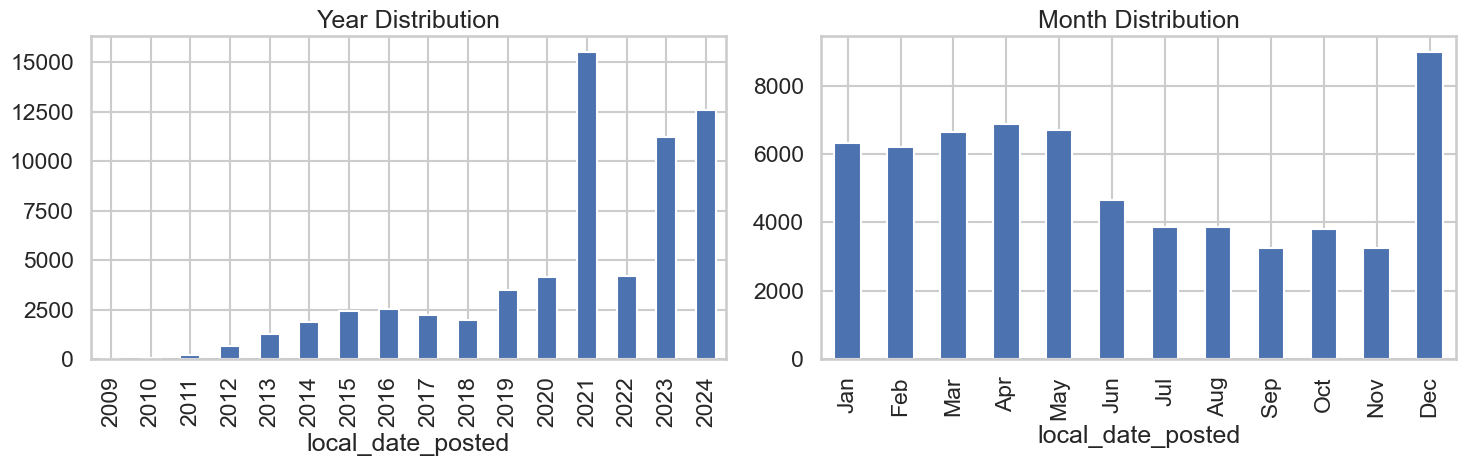

Statistical analysis for column: local_hour
Unique values: 24
Missing values: 0 (0.00%)
Descriptive Statistics:
count    64435.000
mean        12.332
std          4.881
min          0.000
25%          9.000
50%         12.000
75%         16.000
max         23.000
Name: local_hour, dtype: float64
Outliers: 0 (0.00%)
Visualizations for local_hour


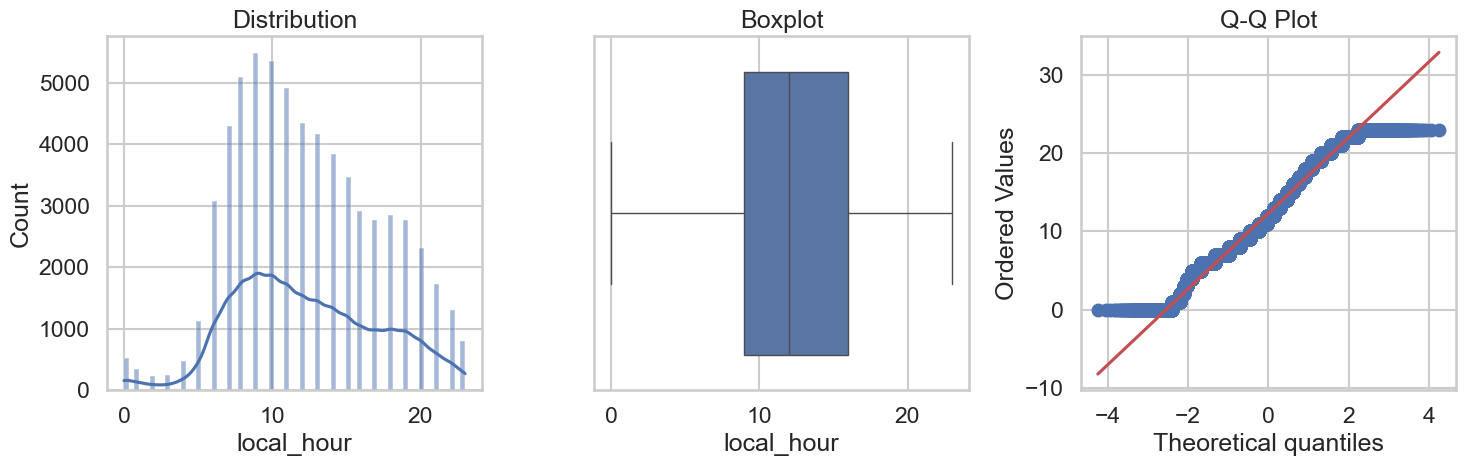

Statistical analysis for column: location
Unique values: 144
Missing values: 0 (0.00%)
Top 10 Categories (Count and Percentage):
US: 44,170 (68.5%)
GB: 13,729 (21.3%)
CA: 1,394 (2.2%)
DE: 667 (1.0%)
NL: 363 (0.6%)
FR: 335 (0.5%)
AU: 304 (0.5%)
SE: 204 (0.3%)
PL: 193 (0.3%)
DK: 191 (0.3%)
Visualizations for location


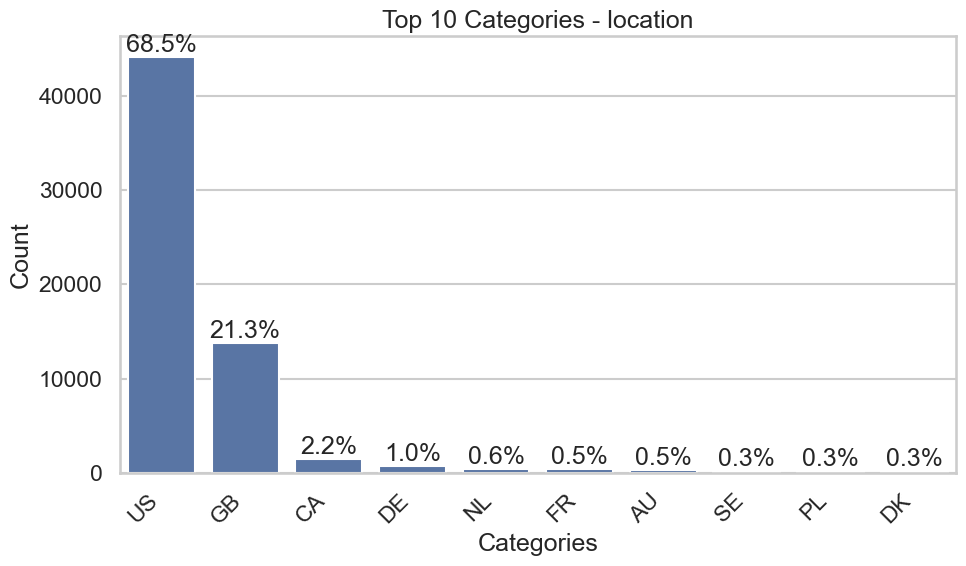

Statistical analysis for column: month_local
Unique values: 12
Missing values: 0 (0.00%)
Descriptive Statistics:
count    64435.000
mean         6.156
std          3.661
min          1.000
25%          3.000
50%          5.000
75%          9.000
max         12.000
Name: month_local, dtype: float64
Outliers: 0 (0.00%)
Visualizations for month_local


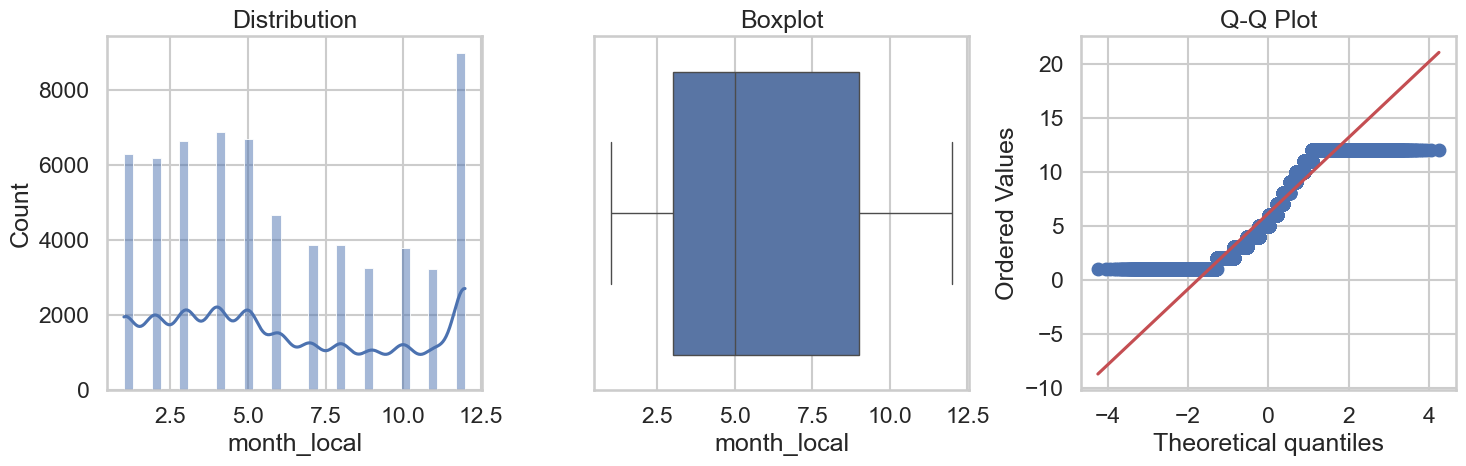

Statistical analysis for column: number_reviews
Unique values: 158
Missing values: 0 (0.00%)
Descriptive Statistics:
count    64435.000
mean         3.685
std          9.938
min          1.000
25%          1.000
50%          1.000
75%          3.000
max        592.000
Name: number_reviews, dtype: float64
Outliers: 6616 (10.27%)
Visualizations for number_reviews


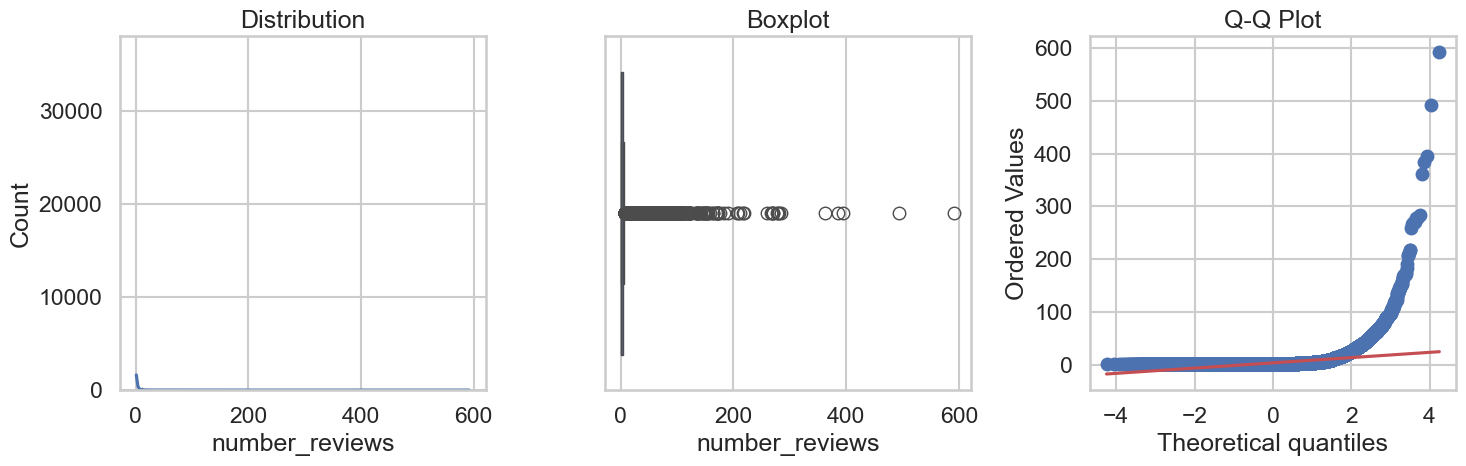

Statistical analysis for column: rating
Unique values: 5
Missing values: 0 (0.00%)
Descriptive Statistics:
count    64435.000
mean         3.505
std          1.691
min          1.000
25%          1.000
50%          4.000
75%          5.000
max          5.000
Name: rating, dtype: float64
Outliers: 0 (0.00%)
Visualizations for rating


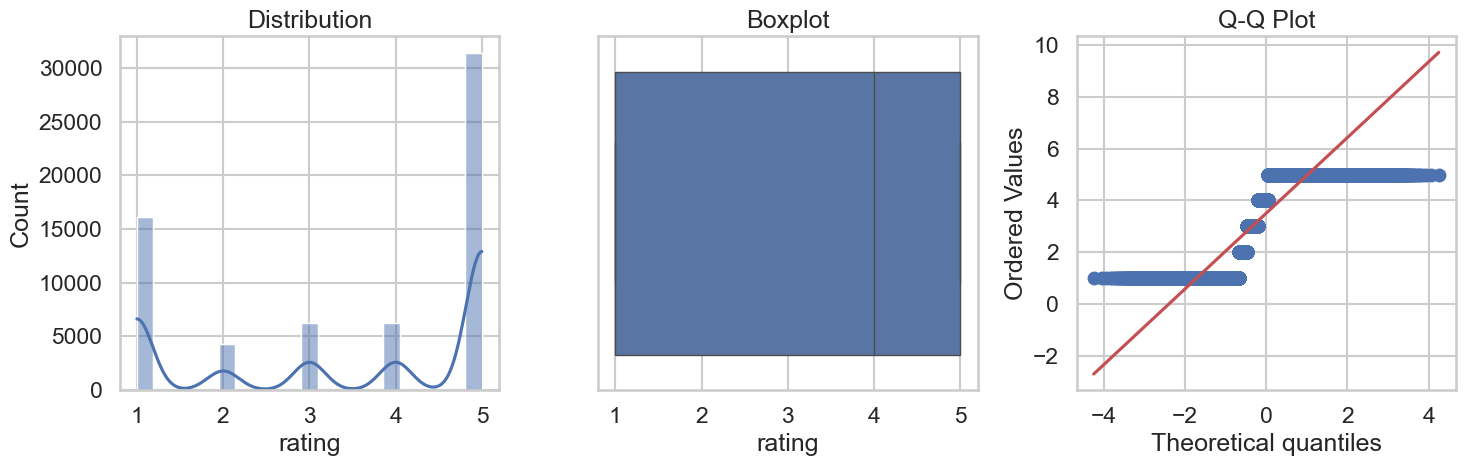

Statistical analysis for column: subject_length
Unique values: 131
Missing values: 0 (0.00%)
Descriptive Statistics:
count    64435.000
mean        23.711
std         10.645
min          0.000
25%         17.000
50%         23.000
75%         28.000
max        161.000
Name: subject_length, dtype: float64
Outliers: 2541 (3.94%)
Visualizations for subject_length


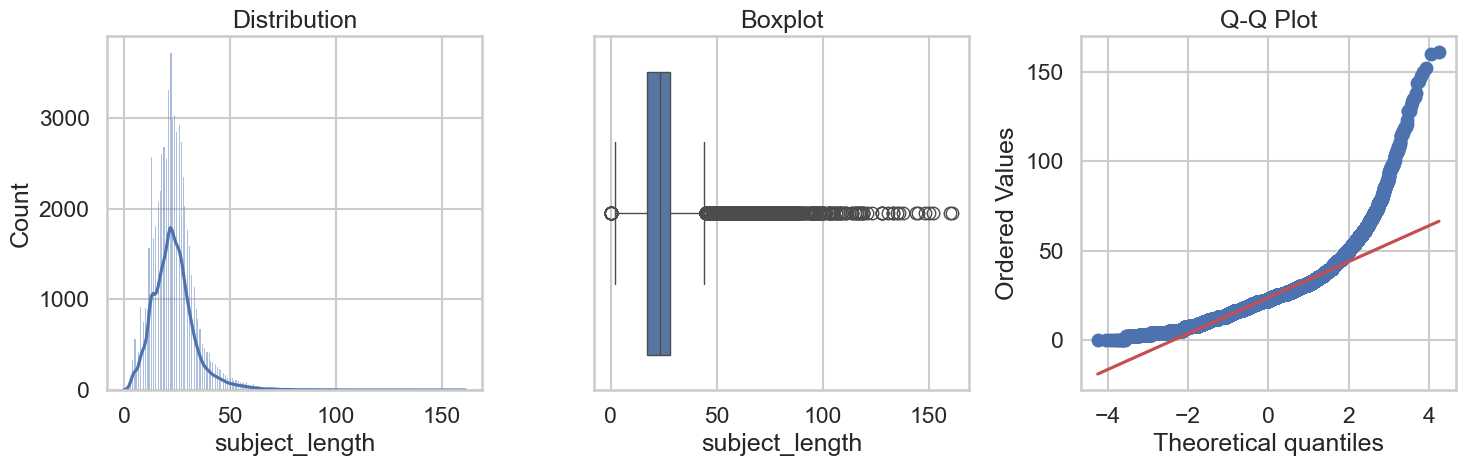

Statistical analysis for column: subject_word_length
Unique values: 25
Missing values: 0 (0.00%)
Descriptive Statistics:
count    64435.000
mean         3.482
std          1.461
min          0.000
25%          3.000
50%          3.000
75%          4.000
max         27.000
Name: subject_word_length, dtype: float64
Outliers: 6643 (10.31%)
Visualizations for subject_word_length


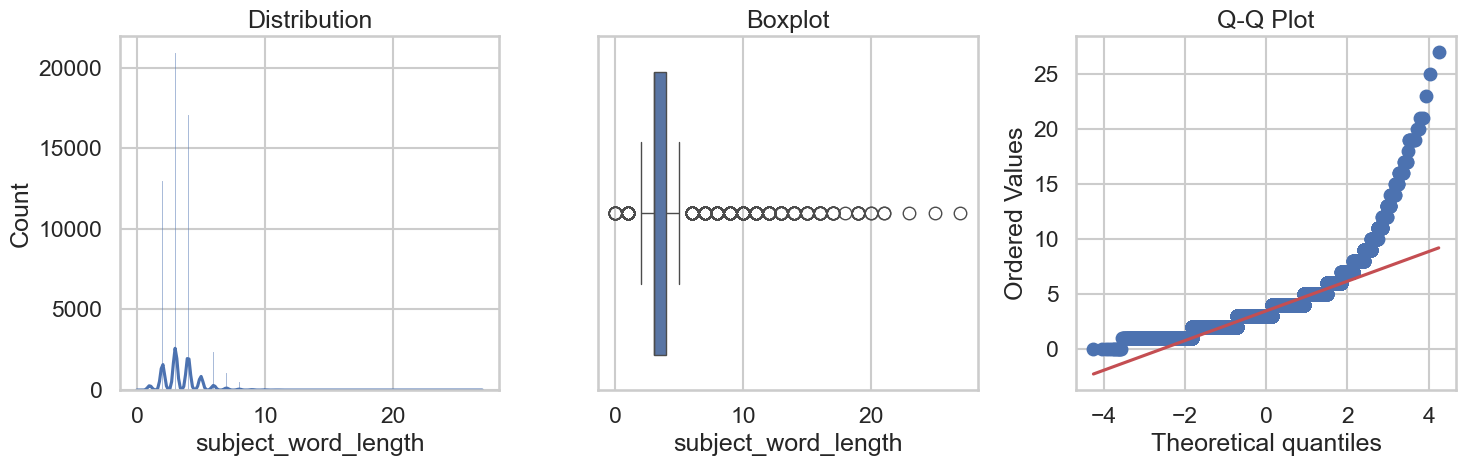

Statistical analysis for column: text_length
Unique values: 1503
Missing values: 0 (0.00%)
Descriptive Statistics:
count    64435.000
mean       188.133
std        218.143
min          3.000
25%         66.000
50%        124.000
75%        228.000
max       8017.000
Name: text_length, dtype: float64
Outliers: 4600 (7.14%)
Visualizations for text_length


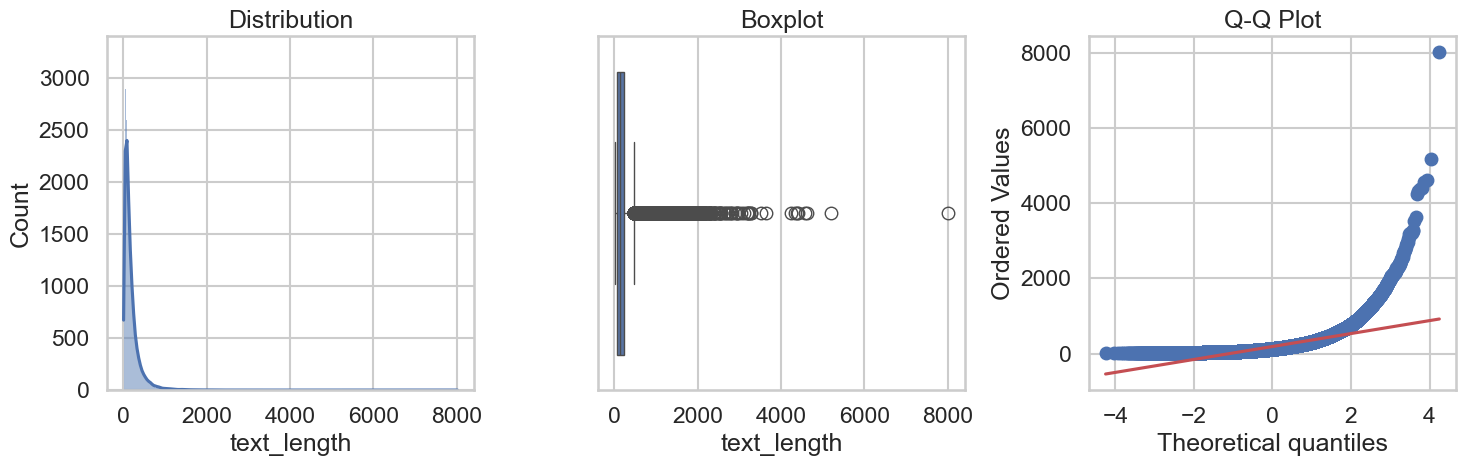

Statistical analysis for column: text_word_length
Unique values: 344
Missing values: 0 (0.00%)
Descriptive Statistics:
count    64435.000
mean        27.146
std         31.910
min          1.000
25%          9.000
50%         18.000
75%         33.000
max       1089.000
Name: text_word_length, dtype: float64
Outliers: 4516 (7.01%)
Visualizations for text_word_length


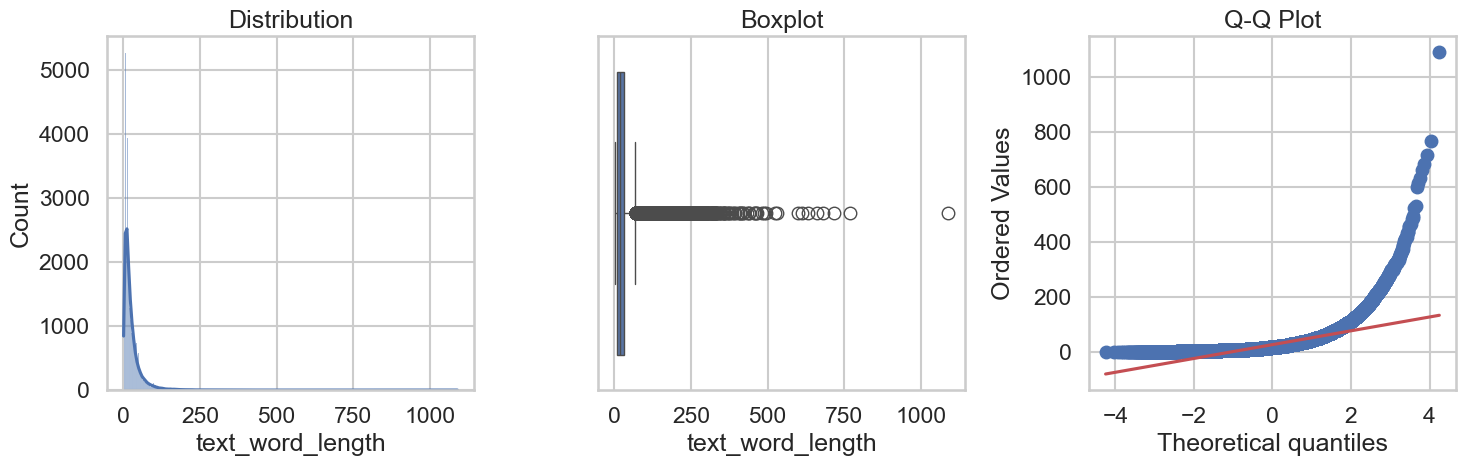

Statistical analysis for column: time_of_day
Unique values: 4
Missing values: 0 (0.00%)
Top 10 Categories (Count and Percentage):
Business Hours: 37,253 (57.8%)
Morning: 12,465 (19.3%)
Evening: 10,960 (17.0%)
Night: 3,757 (5.8%)
Visualizations for time_of_day


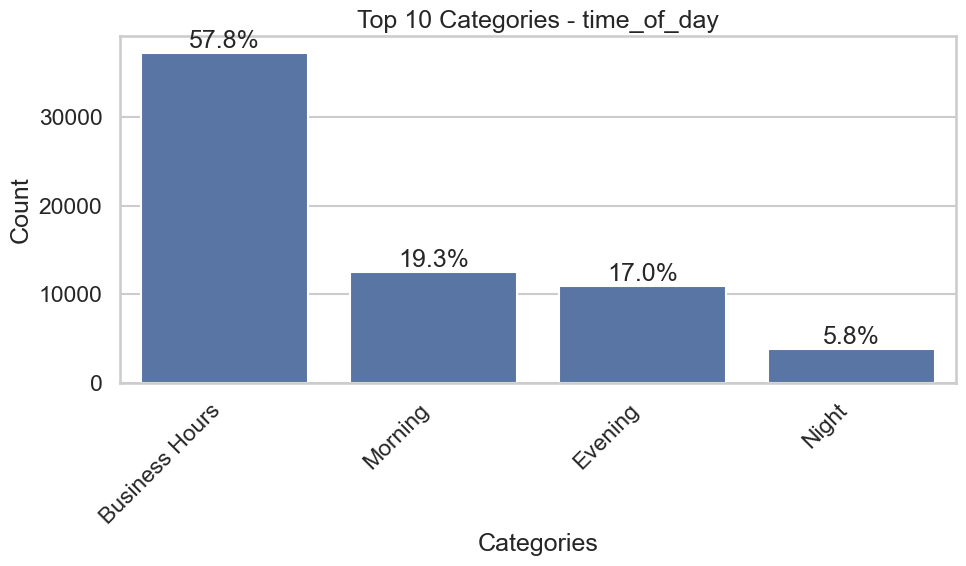

Statistical analysis for column: verification
Unique values: 4
Missing values: 0 (0.00%)
Top 10 Categories (Count and Percentage):
Verified: 42,161 (65.4%)
Not Verified: 13,338 (20.7%)
Invited: 8,926 (13.9%)
Redirected: 10 (0.0%)
Visualizations for verification


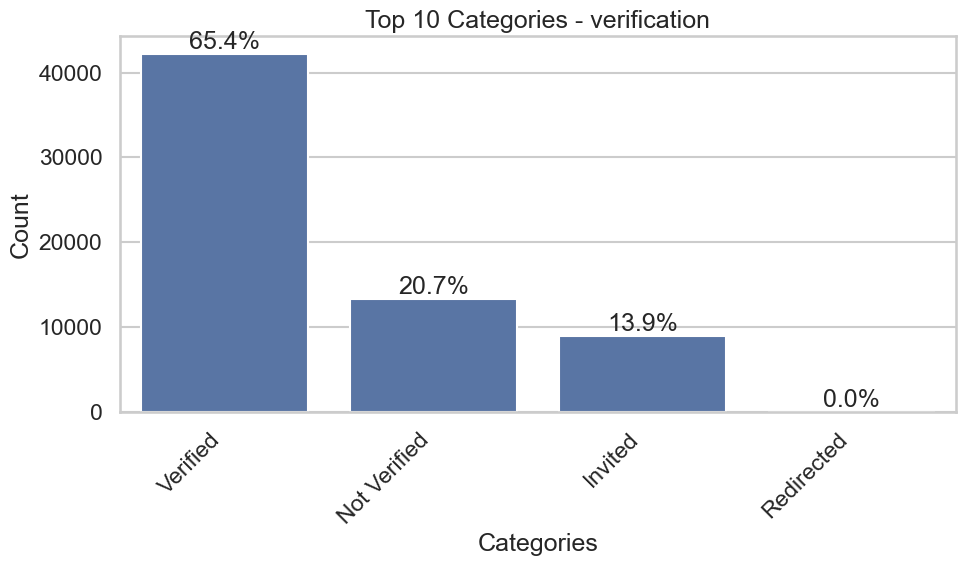

In [249]:
#Univariate analysis of remaining columns

def analyze_statistics(df, column_name):
    print(f"Statistical analysis for column: {column_name}")
    print("="*50)
    
    # Basic info for all columns
    n_unique = df[column_name].nunique()
    n_missing = df[column_name].isnull().sum()
    print(f"Unique values: {n_unique}")
    print(f"Missing values: {n_missing} ({(n_missing/len(df)*100):.2f}%)")
    
    if np.issubdtype(df[column_name].dtype, np.number):
        # Numeric analysis
        desc = df[column_name].describe()
        print("Descriptive Statistics:")
        print(desc)
        
        # Outlier analysis using IQR
        q1, q3 = df[column_name].quantile([0.25, 0.75])
        iqr = q3 - q1
        outliers = df[column_name][(df[column_name] < q1 - 1.5*iqr) | 
                                 (df[column_name] > q3 + 1.5*iqr)]
        print(f"Outliers: {len(outliers)} ({(len(outliers)/len(df)*100):.2f}%)")
        
    elif df[column_name].dtype == 'object':
        # Categorical analysis
        value_counts = df[column_name].value_counts()
        print("Top 10 Categories (Count and Percentage):")
        for val, count in value_counts.head(10).items():
            pct = count/len(df)*100
            print(f"{val}: {count:,} ({pct:.1f}%)")
            
    elif pd.api.types.is_datetime64_dtype(df[column_name]):
        # Datetime analysis
        print("Temporal Range:")
        print(f"Start: {df[column_name].min()}")
        print(f"End: {df[column_name].max()}")
        print(f"Range: {df[column_name].max() - df[column_name].min()}")

def create_visualizations(df, column_name):
    print(f"Visualizations for {column_name}")
    print("="*50)
    
    if np.issubdtype(df[column_name].dtype, np.number):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Distribution
        sns.histplot(data=df, x=column_name, kde=True, ax=axes[0])
        axes[0].set_title('Distribution')
        
        # Vertical boxplot without percentages
        sns.boxplot(x=df[column_name], ax=axes[1])
        axes[1].set_title('Boxplot')
        
        # Q-Q plot
        stats.probplot(df[column_name], dist="norm", plot=axes[2])
        axes[2].set_title('Q-Q Plot')
        
    elif df[column_name].dtype == 'object':
        # Categorical visualization with vertical bars
        plt.figure(figsize=(10, 6))
        
        # Get top 10 categories and their percentages
        top_cats = df[column_name].value_counts().head(10)
        percentages = (top_cats / len(df) * 100)
        
        # Create vertical bar plot
        ax = sns.barplot(x=range(len(top_cats)), y=top_cats.values)
        plt.title(f'Top 10 Categories - {column_name}')
        plt.xlabel('Categories')
        plt.ylabel('Count')
        
        # Set x-tick labels
        plt.xticks(range(len(top_cats)), top_cats.index, rotation=45, ha='right')
        
        # Add percentage labels on top of each bar
        for i, pct in enumerate(percentages):
            ax.text(i, top_cats.values[i], f'{pct:.1f}%', 
                   ha='center', va='bottom')
        
    elif pd.api.types.is_datetime64_dtype(df[column_name]):
        # Datetime visualizations
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Year distribution
        df[column_name].dt.year.value_counts().sort_index().plot(
            kind='bar', ax=axes[0])
        axes[0].set_title('Year Distribution')
        
        # Month distribution
        df[column_name].dt.month.value_counts().sort_index().plot(
            kind='bar', ax=axes[1])
        axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        axes[1].set_title('Month Distribution')
    
    plt.tight_layout()
    plt.show()

# Set the style
sns.set_theme(style="whitegrid", context="talk")

# Run analysis for remaining columns
for column in sorted(univariate_pending_columns):
    analyze_statistics(df_trustpilot, column)
    create_visualizations(df_trustpilot, column)

STAGE 2 - MULTIVARIATE ANALYSIS

1. Binary Variables Analysis
Analyzing binary column: repeat_reviewer vs rating
Summary Statistics by Group:
                 count  mean  median   std
repeat_reviewer                           
one-time         36205  3.88     5.0  1.54
repeat           28230  3.03     3.0  1.75
Distribution of rating by groups (%):
rating               1     2      3      4      5
repeat_reviewer                                  
one-time         16.26  6.36   9.42   9.28  58.69
repeat           36.26  7.15  10.22  10.40  35.96


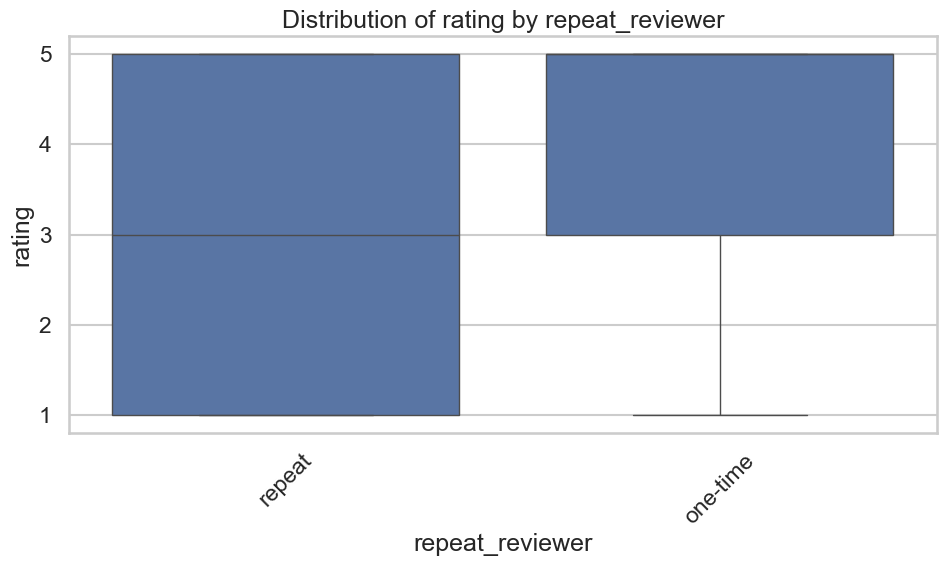

Analyzing binary column: repeat_reviewer_encoded vs rating
Summary Statistics by Group:
                         count  mean  median   std
repeat_reviewer_encoded                           
0                        36205  3.88     5.0  1.54
1                        28230  3.03     3.0  1.75
Distribution of rating by groups (%):
rating                       1     2      3      4      5
repeat_reviewer_encoded                                  
0                        16.26  6.36   9.42   9.28  58.69
1                        36.26  7.15  10.22  10.40  35.96


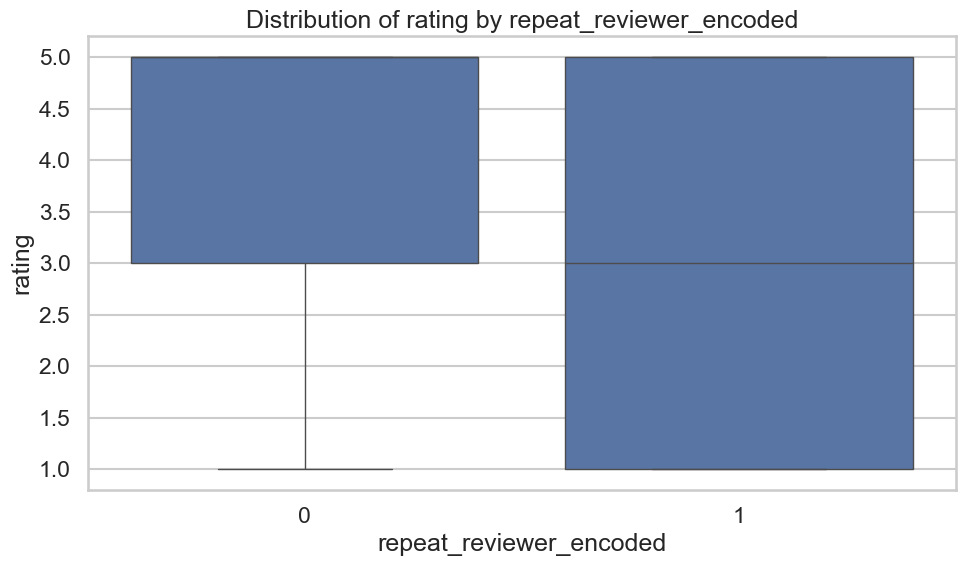

Analyzing binary column: answered_encoded vs rating
Summary Statistics by Group:
                  count  mean  median   std
answered_encoded                           
0                 48396  3.12     3.0  1.69
1                 16039  4.67     5.0  1.01
Distribution of rating by groups (%):
rating                1     2      3      4      5
answered_encoded                                  
0                 31.54  8.19  12.67  12.13  35.46
1                  5.34  2.21   1.03   2.65  88.76


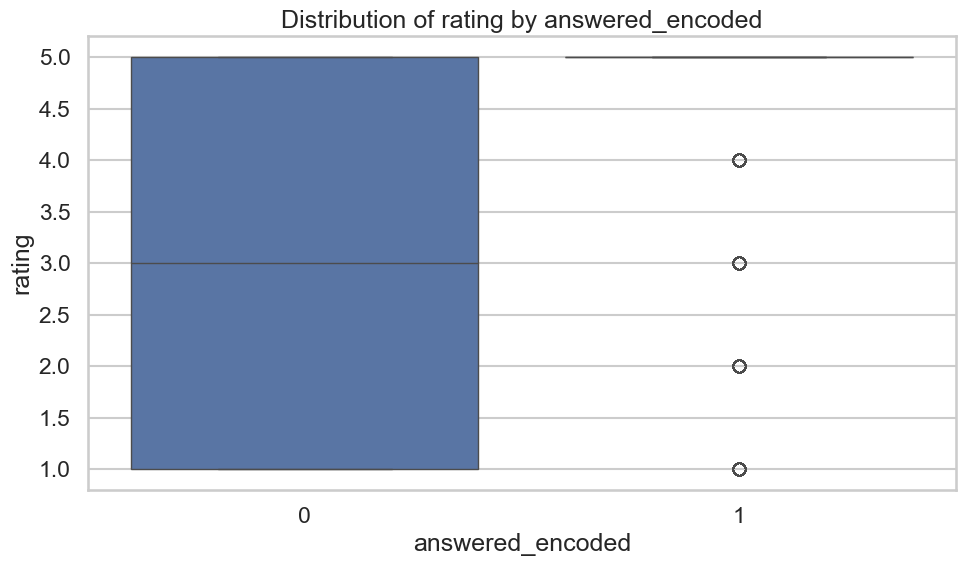

Analyzing binary column: day_type vs rating
Summary Statistics by Group:
              count  mean  median   std
day_type                               
Business Day  52542  3.62     5.0  1.67
Weekend       11893  2.99     3.0  1.71
Distribution of rating by groups (%):
rating            1     2      3      4      5
day_type                                      
Business Day  22.82  6.22   9.23   9.46  52.27
Weekend       34.77  8.84  12.14  11.15  33.10


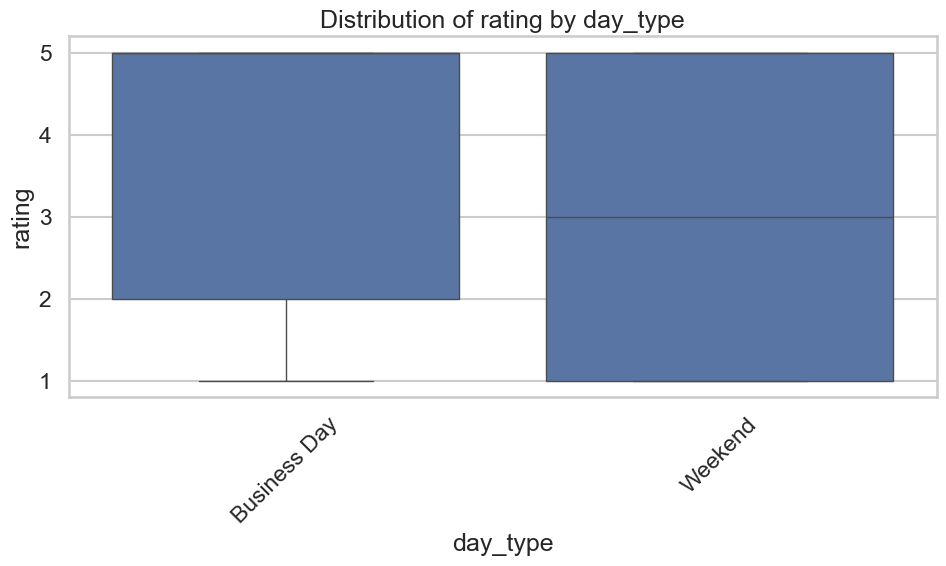

Analyzing binary column: review_time vs rating
Summary Statistics by Group:
              count  mean  median   std
review_time                            
late_review   13111  3.09     3.0  1.61
quick_review  51324  3.61     5.0  1.69
Distribution of rating by groups (%):
rating            1      2      3      4      5
review_time                                    
late_review   28.12  10.60  16.76  13.36  31.16
quick_review  24.23   5.71   7.98   8.85  53.22


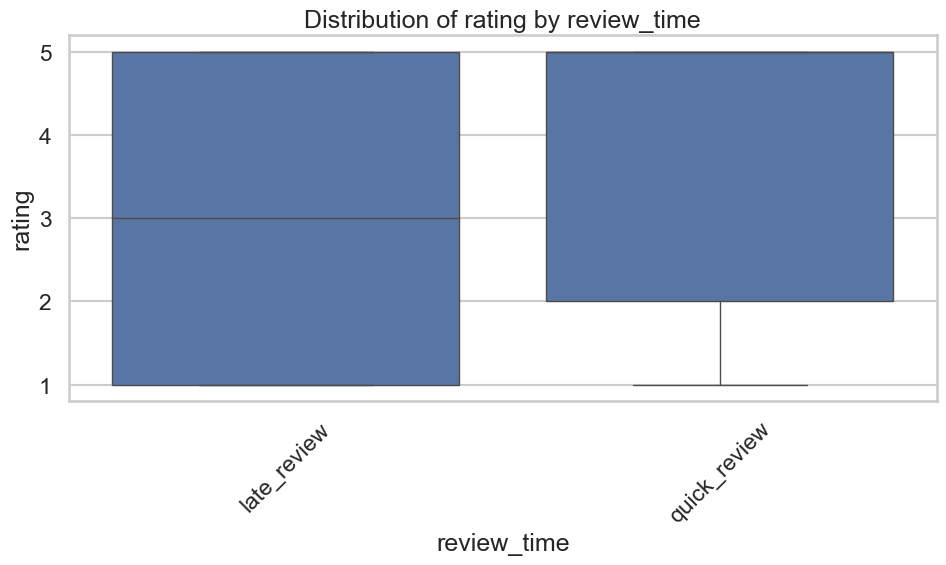

Analyzing binary column: review_time_encoded vs rating
Summary Statistics by Group:
                     count  mean  median   std
review_time_encoded                           
0                    13111  3.09     3.0  1.61
1                    51324  3.61     5.0  1.69
Distribution of rating by groups (%):
rating                   1      2      3      4      5
review_time_encoded                                   
0                    28.12  10.60  16.76  13.36  31.16
1                    24.23   5.71   7.98   8.85  53.22


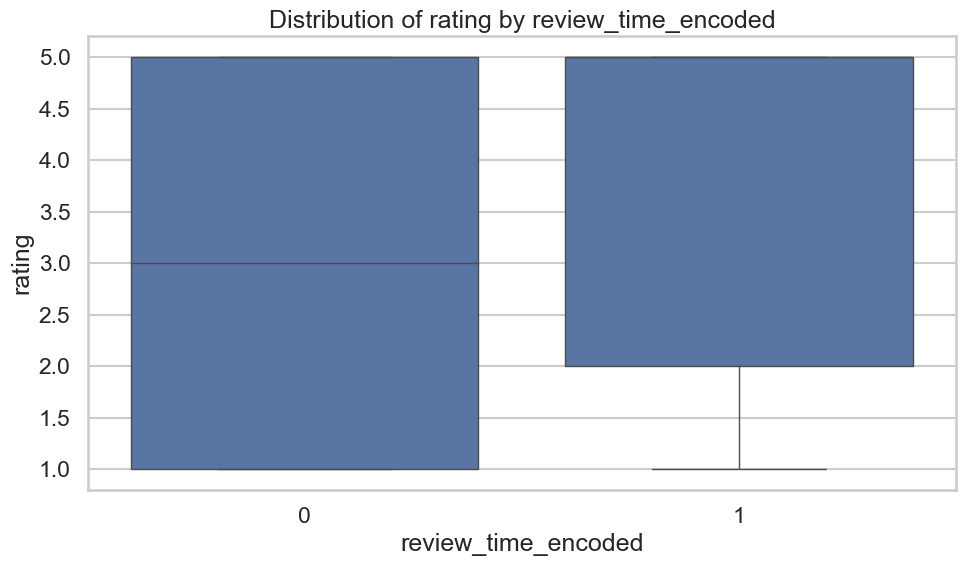

In [250]:
#Multivariate binary analysis

def analyze_multivariate_binary(df, binary_columns, target='rating'):
    for column in binary_columns:
        print(f"Analyzing binary column: {column} vs {target}")
        print("="*50)
        
        # Statistical analysis
        summary = df.groupby(column)[target].agg([
            'count', 'mean', 'median', 'std'
        ]).round(2)
        print("Summary Statistics by Group:")
        print(summary)
        
        # Distribution analysis
        cross_tab = pd.crosstab(df[column], df[target], normalize='index') * 100
        print(f"Distribution of {target} by groups (%):")
        print(cross_tab.round(2))
        
        # Visualization
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.boxplot(data=df, x=column, y=target)
        plt.title(f'Distribution of {target} by {column}')
        if not np.issubdtype(df[column].dtype, np.number):
            plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

print("1. Binary Variables Analysis")
analyze_multivariate_binary(df_trustpilot, binary_columns)


2. Sentiment Analysis
Analyzing sentiment scores vs rating


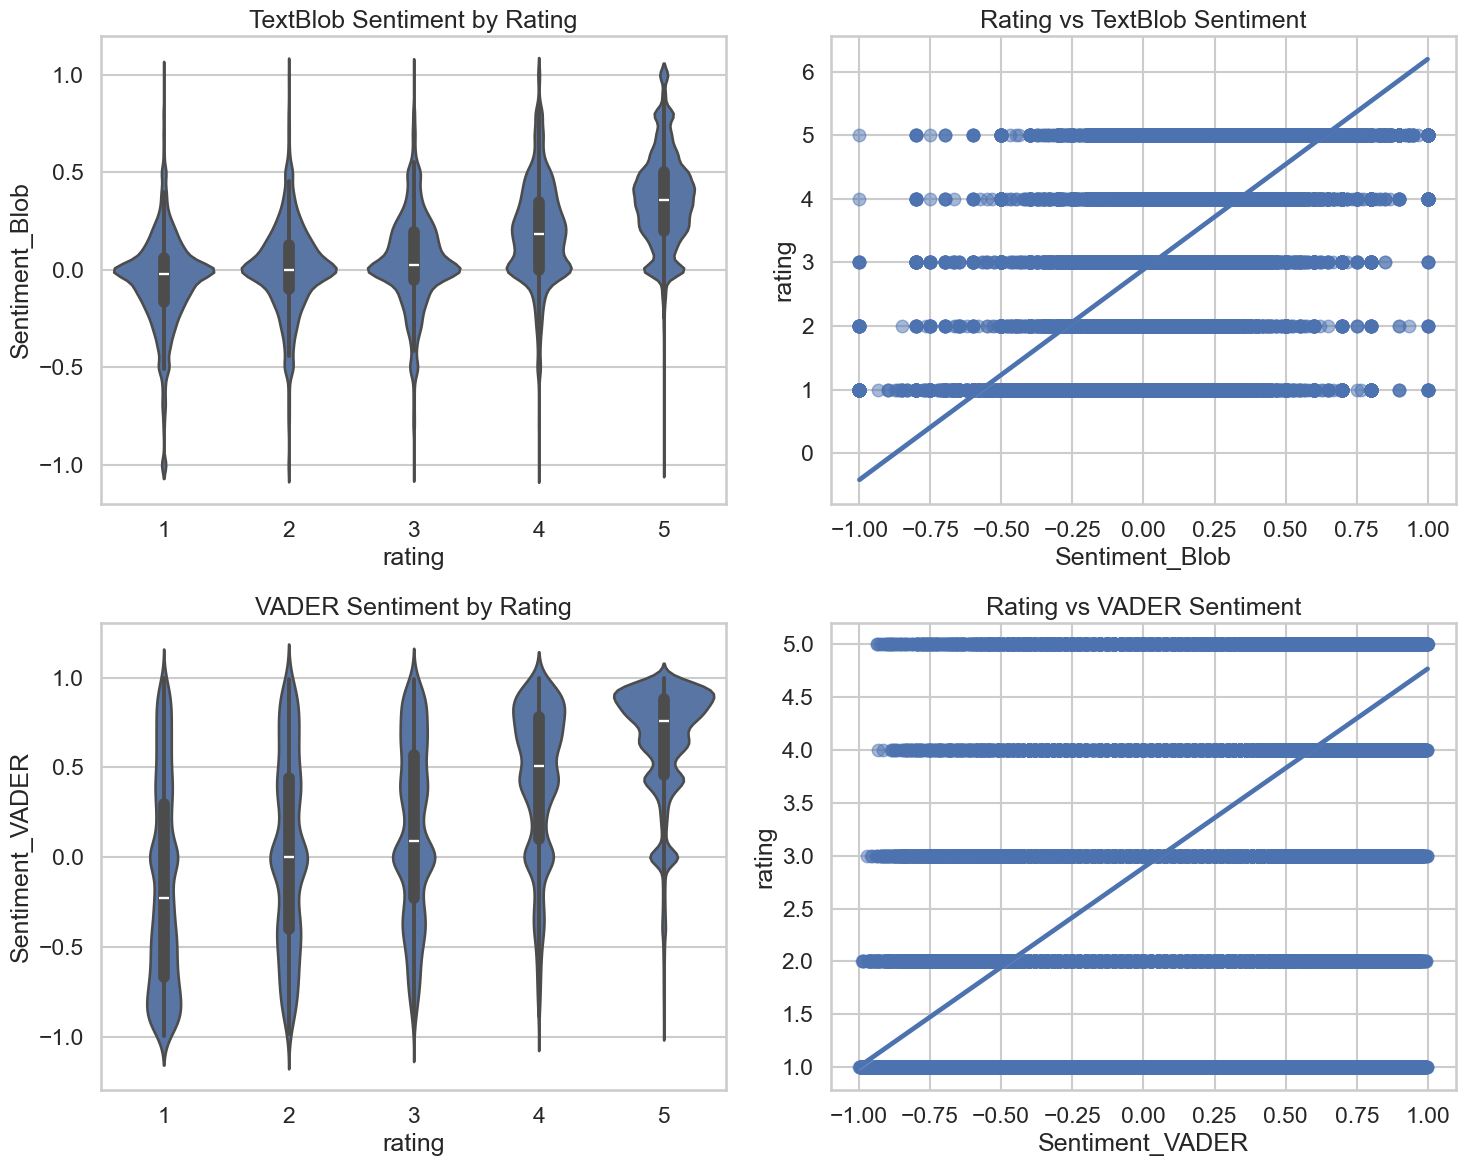

Sentiment_Blob correlation with rating:
Correlation: 0.596
Sentiment_VADER correlation with rating:
Correlation: 0.617


In [251]:
#Multivariate sentiment analysis

def analyze_multivariate_sentiment(df, target='rating'):
    print(f"Analyzing sentiment scores vs {target}")
    print("="*50)
    
    # Create visualization grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # TextBlob analysis
    sns.violinplot(data=df, x=target, y='Sentiment_Blob', ax=axes[0,0])
    axes[0,0].set_title('TextBlob Sentiment by Rating')
    
    sns.regplot(data=df, x='Sentiment_Blob', y=target, 
                scatter_kws={'alpha':0.5}, ax=axes[0,1])
    axes[0,1].set_title('Rating vs TextBlob Sentiment')
    
    # VADER analysis
    sns.violinplot(data=df, x=target, y='Sentiment_VADER', ax=axes[1,0])
    axes[1,0].set_title('VADER Sentiment by Rating')
    
    sns.regplot(data=df, x='Sentiment_VADER', y=target, 
                scatter_kws={'alpha':0.5}, ax=axes[1,1])
    axes[1,1].set_title('Rating vs VADER Sentiment')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    for sentiment in ['Sentiment_Blob', 'Sentiment_VADER']:
        print(f"{sentiment} correlation with {target}:")
        correlation = df[sentiment].corr(df[target])
        print(f"Correlation: {correlation:.3f}")

print("2. Sentiment Analysis")
analyze_multivariate_sentiment(df_trustpilot)

Analyzing company vs rating


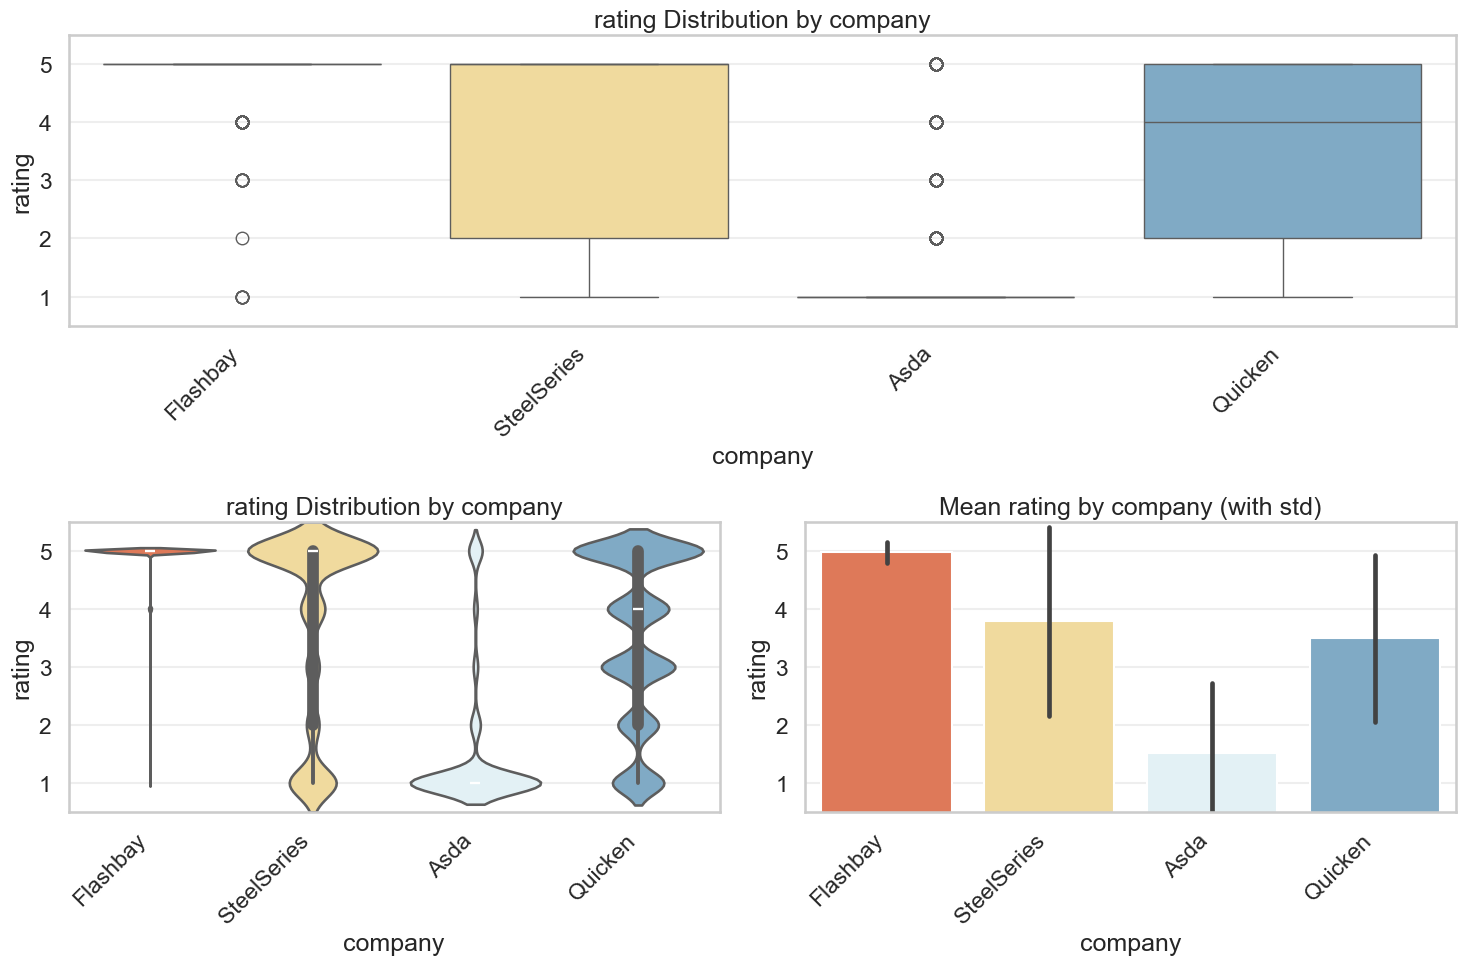

Summary Statistics for Top Categories:
             count  mean   std  median
company                               
Asda         12301  1.52  1.20     1.0
Flashbay     14429  4.97  0.19     5.0
Quicken      25318  3.50  1.44     4.0
SteelSeries  12387  3.78  1.63     5.0
Analyzing date_of_experience vs rating


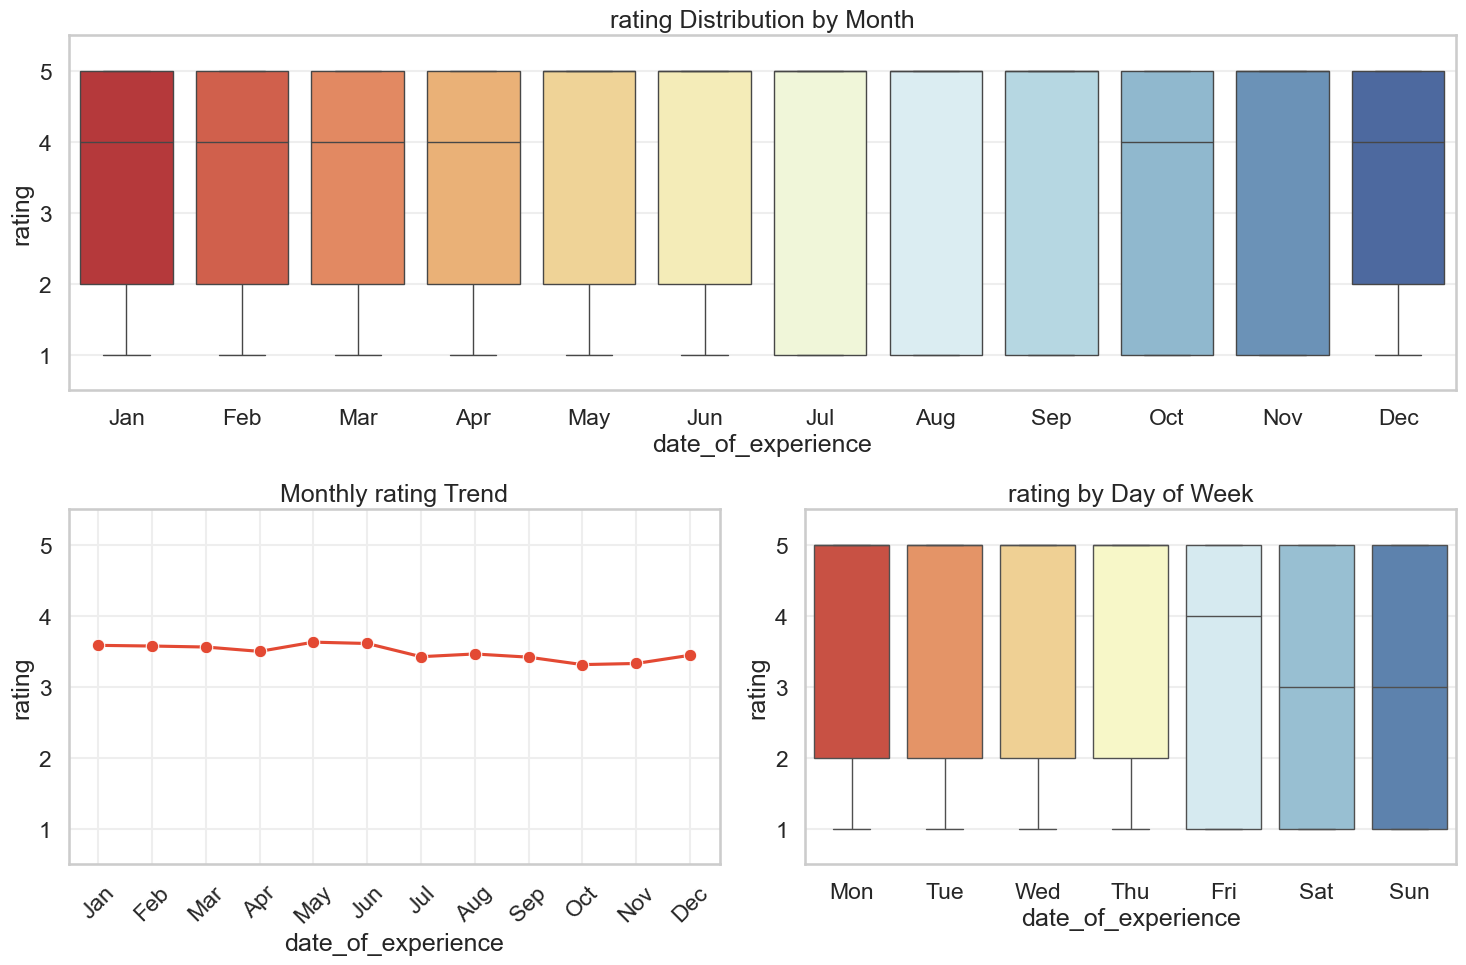

Analyzing date_posted vs rating


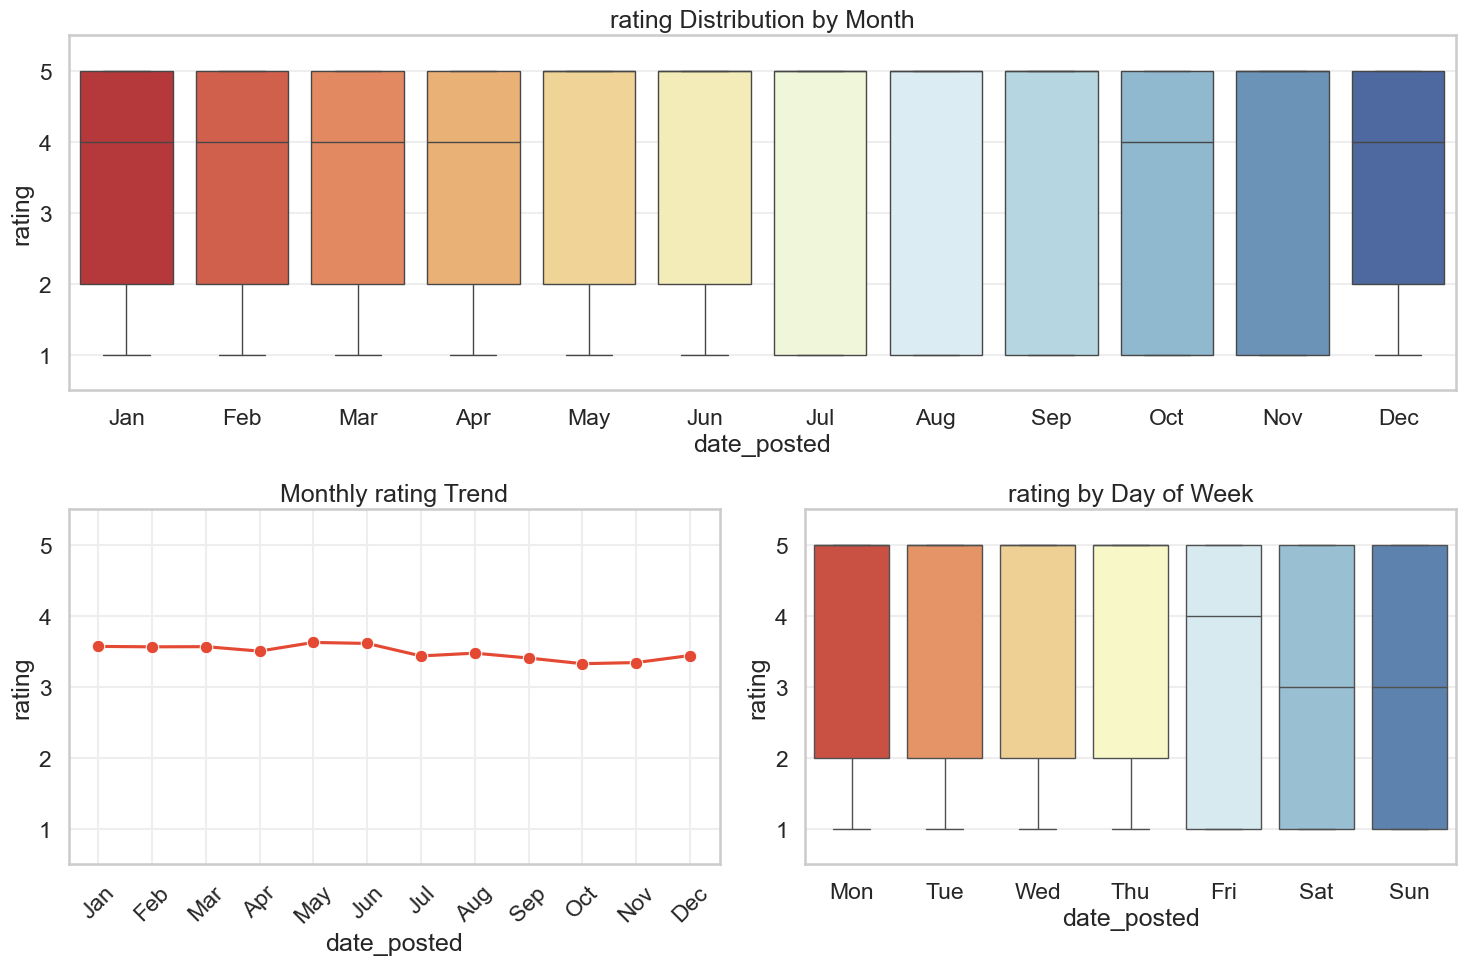

Analyzing day_of_week_posted vs rating


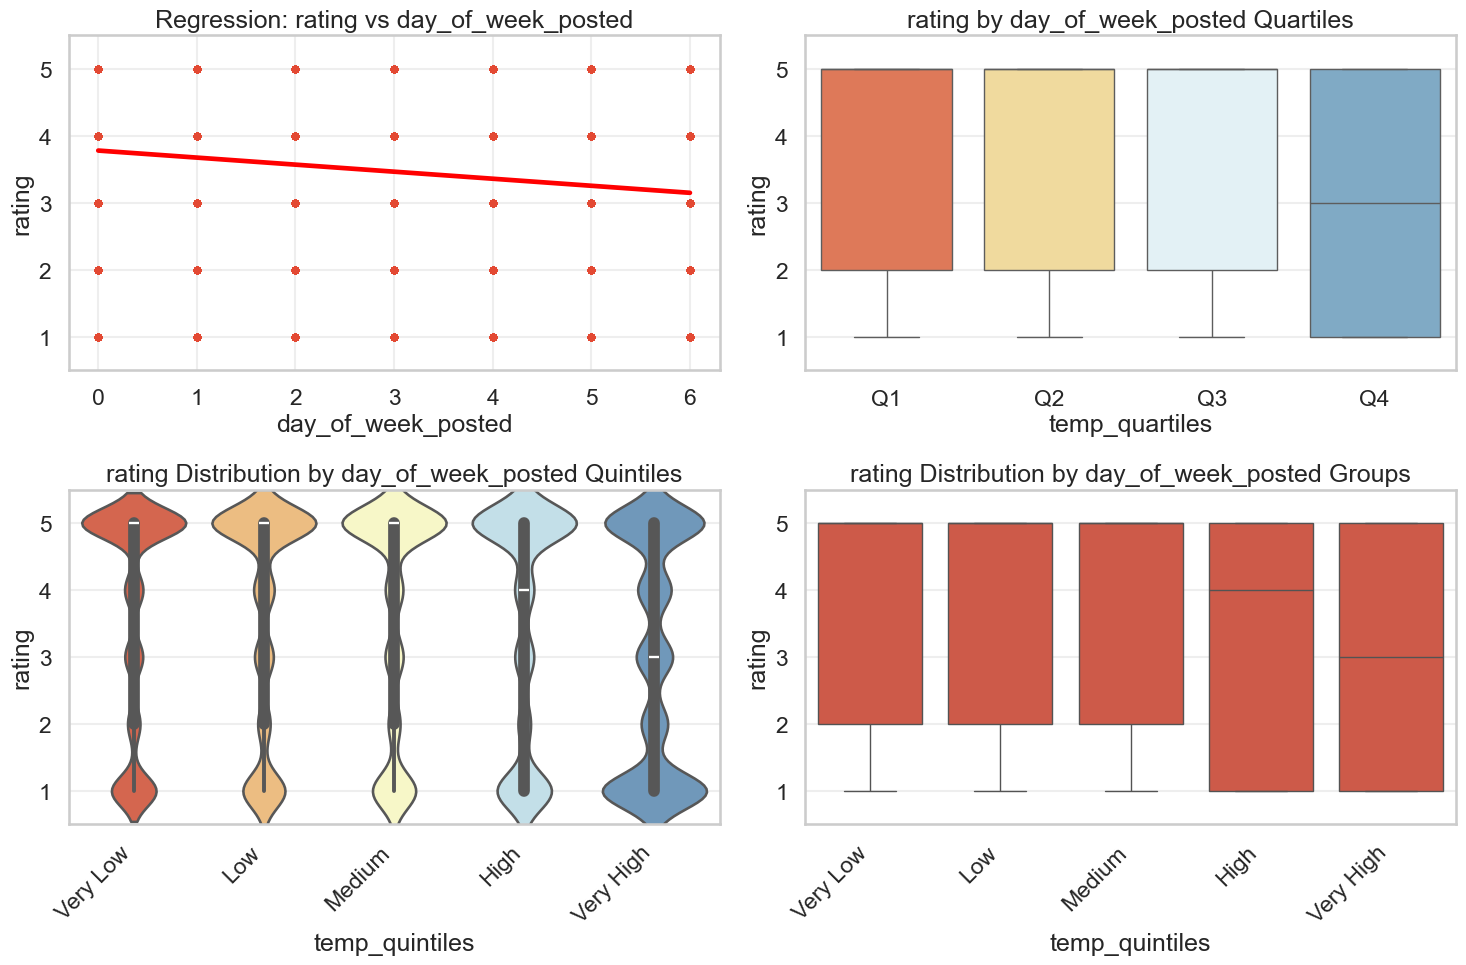

Correlation with rating: -0.115
Analyzing days_between_experience_and_post vs rating
Could not create quartile plot for days_between_experience_and_post
Could not create quintile plot for days_between_experience_and_post


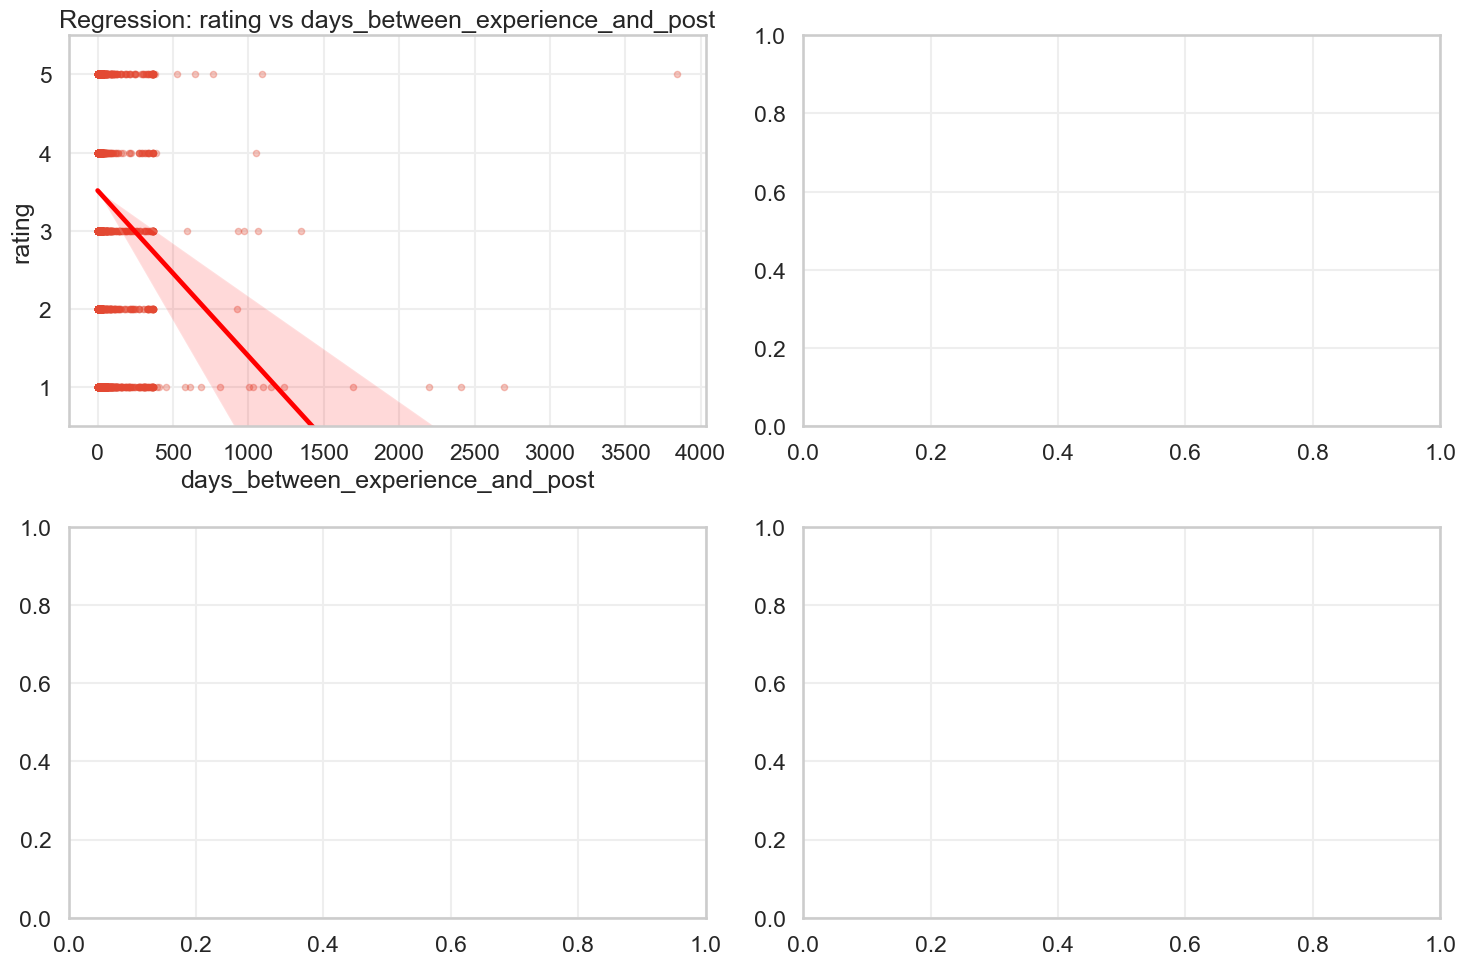

Correlation with rating: -0.044
Analyzing local_date_posted vs rating


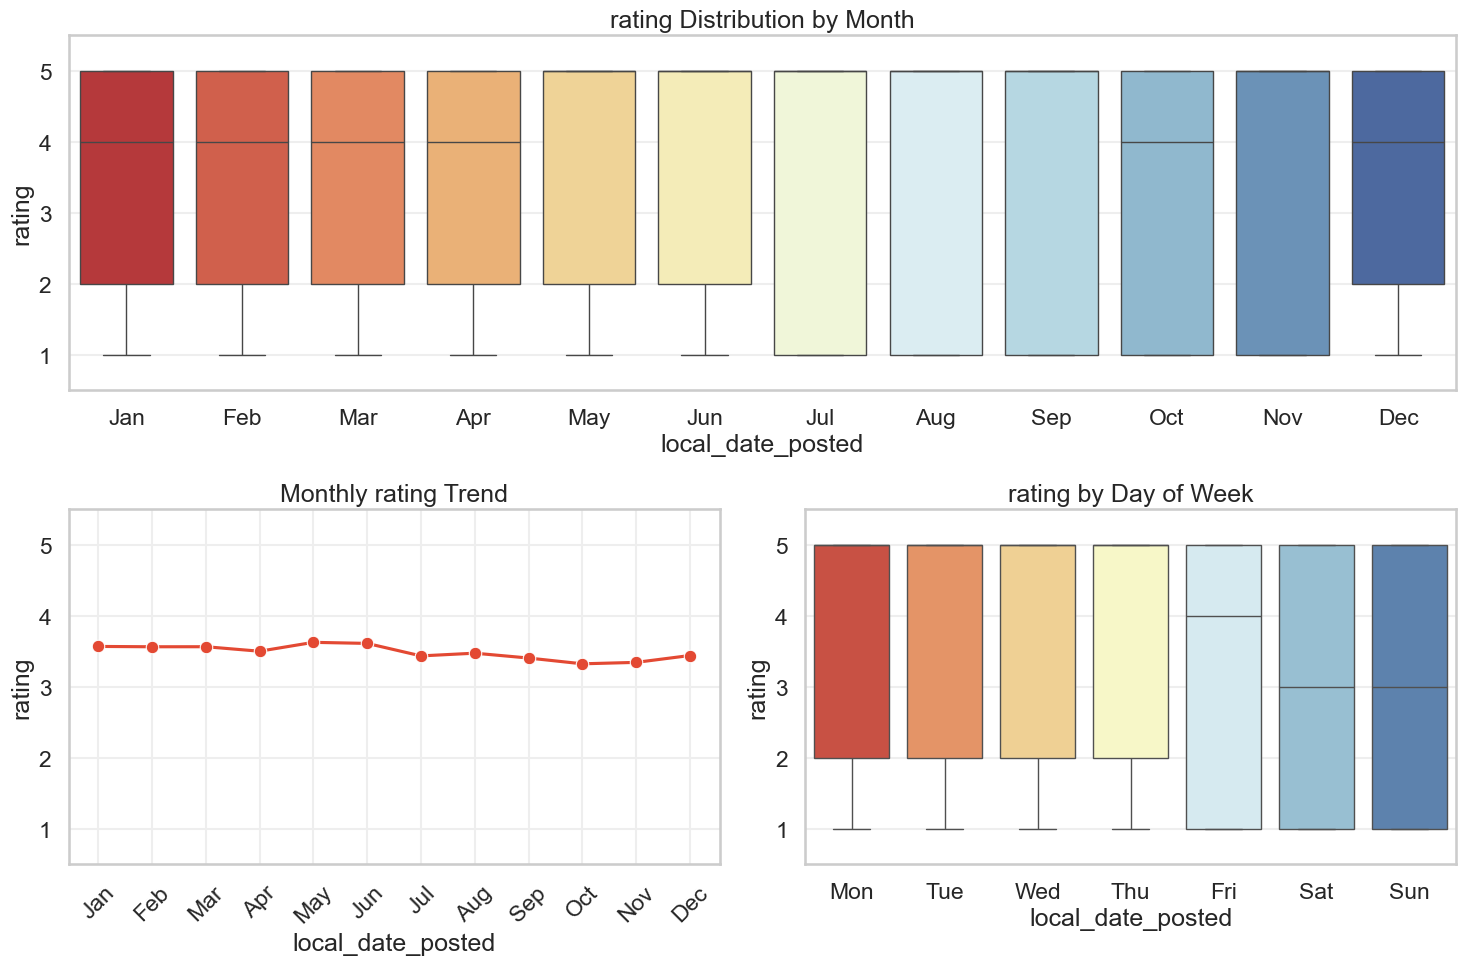

Analyzing local_hour vs rating


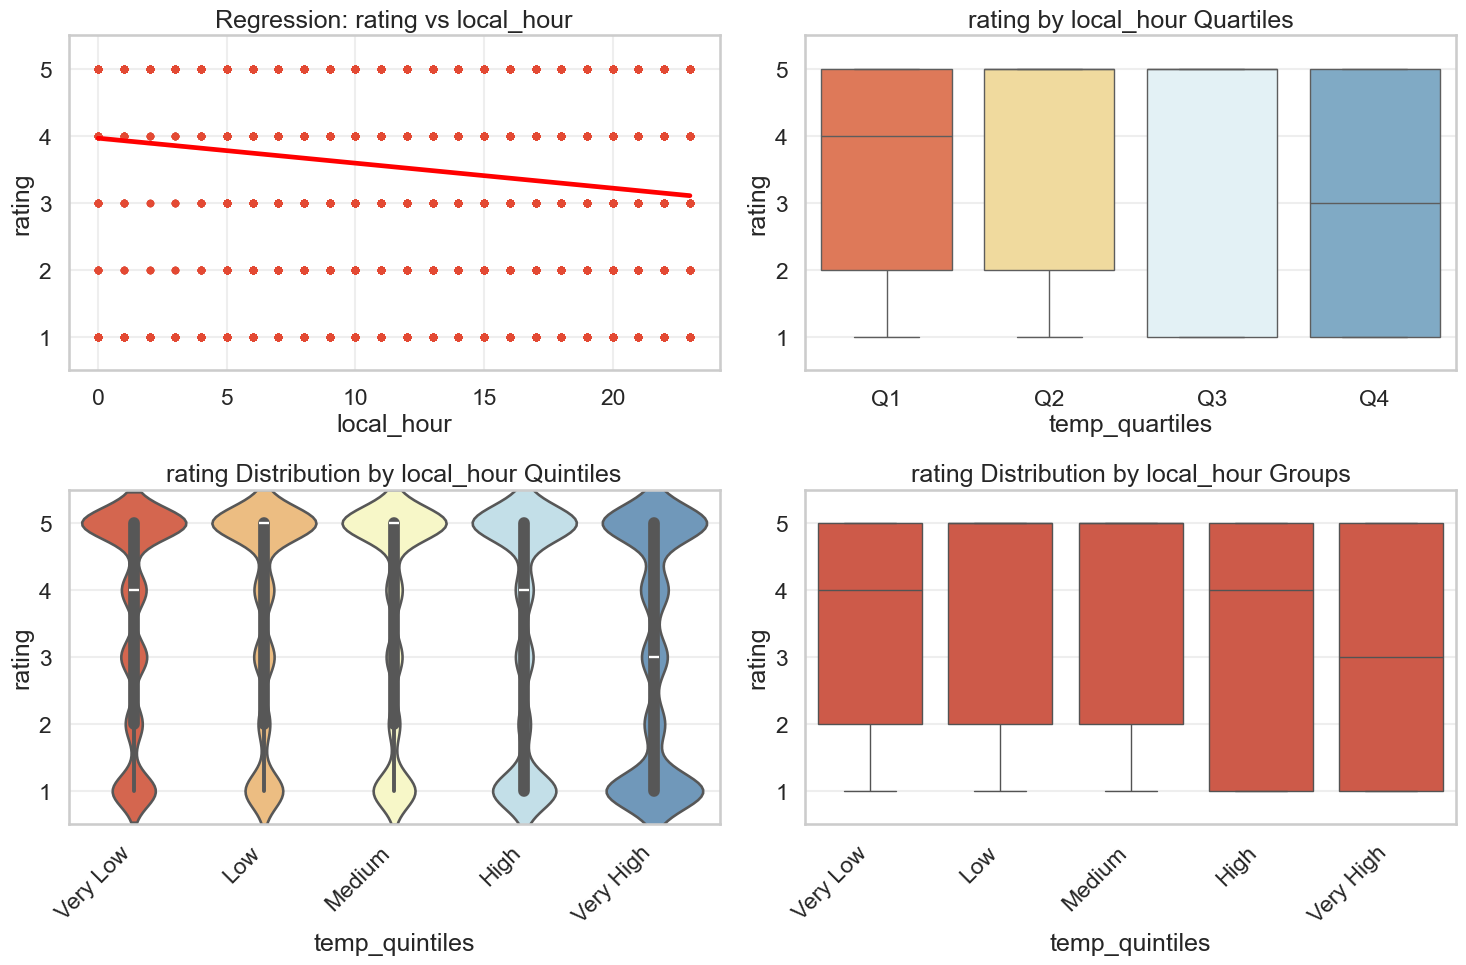

Correlation with rating: -0.108
Analyzing location vs rating


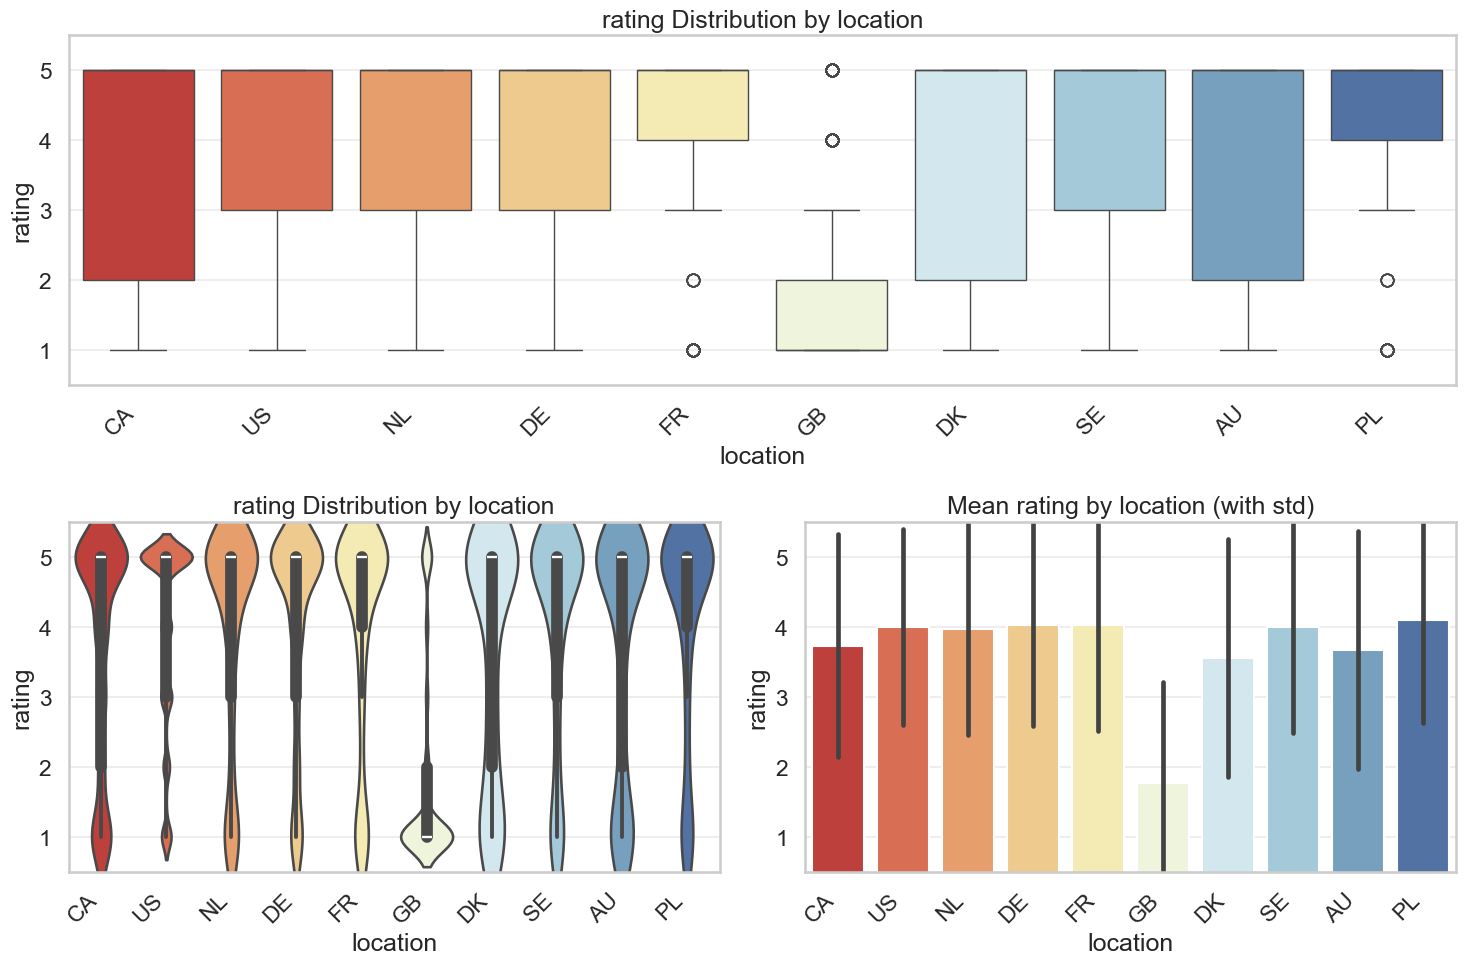

Summary Statistics for Top Categories:
          count  mean   std  median
location                           
AU          304  3.66  1.70     5.0
CA         1394  3.73  1.60     5.0
DE          667  4.03  1.45     5.0
DK          191  3.55  1.70     5.0
FR          335  4.02  1.51     5.0
GB        13729  1.76  1.44     1.0
NL          363  3.97  1.52     5.0
PL          193  4.09  1.48     5.0
SE          204  3.99  1.52     5.0
US        44170  4.00  1.40     5.0
Analyzing month_local vs rating


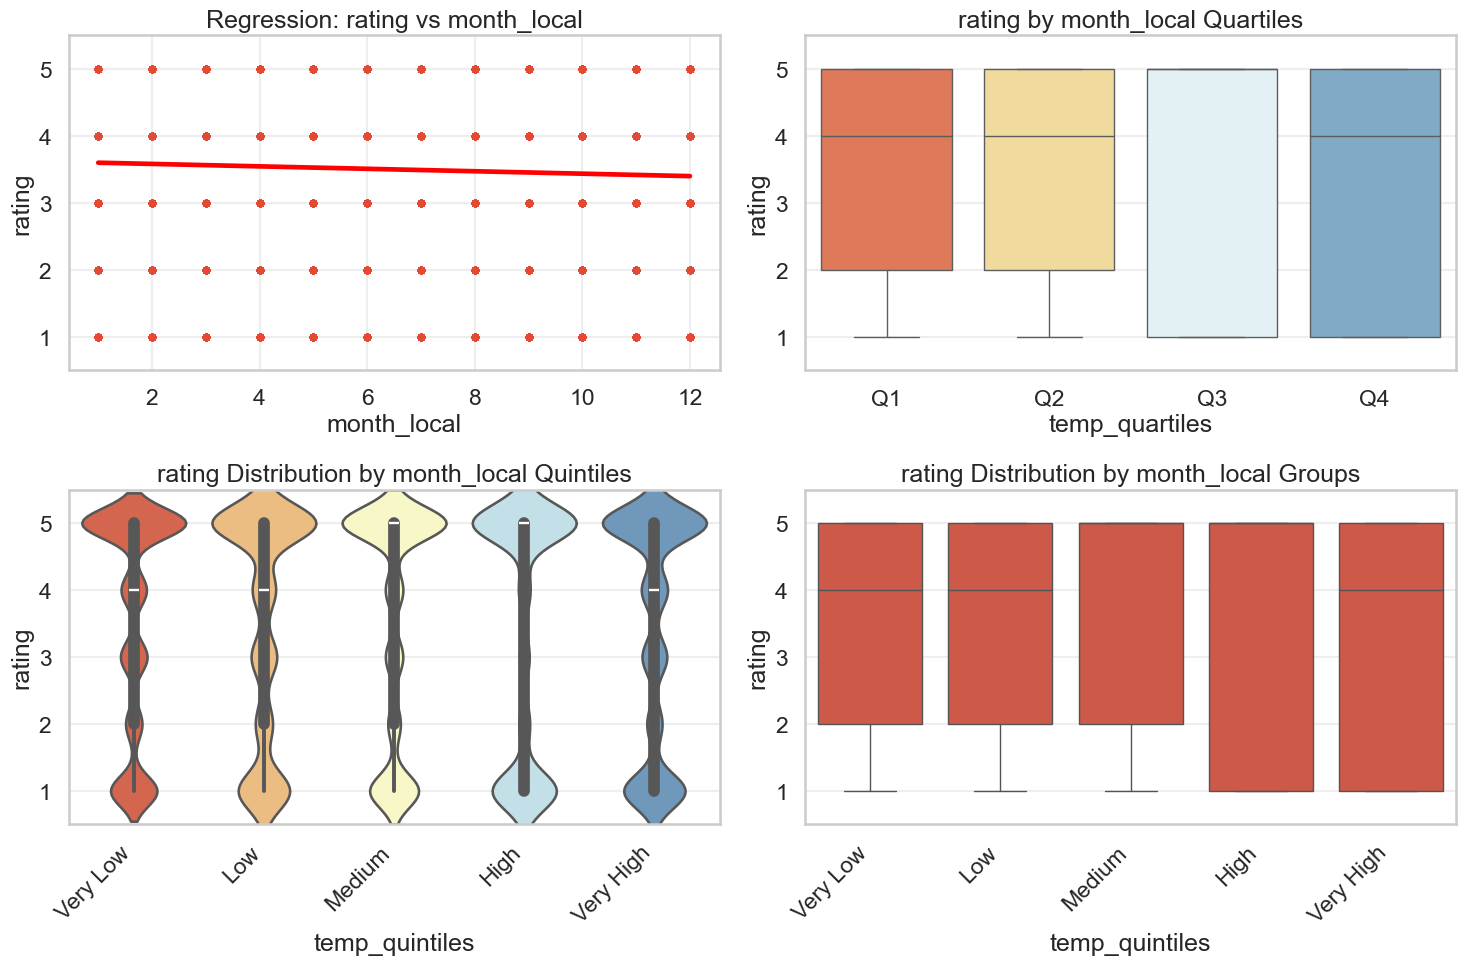

Correlation with rating: -0.039
Analyzing number_reviews vs rating
Could not create quartile plot for number_reviews
Could not create quintile plot for number_reviews


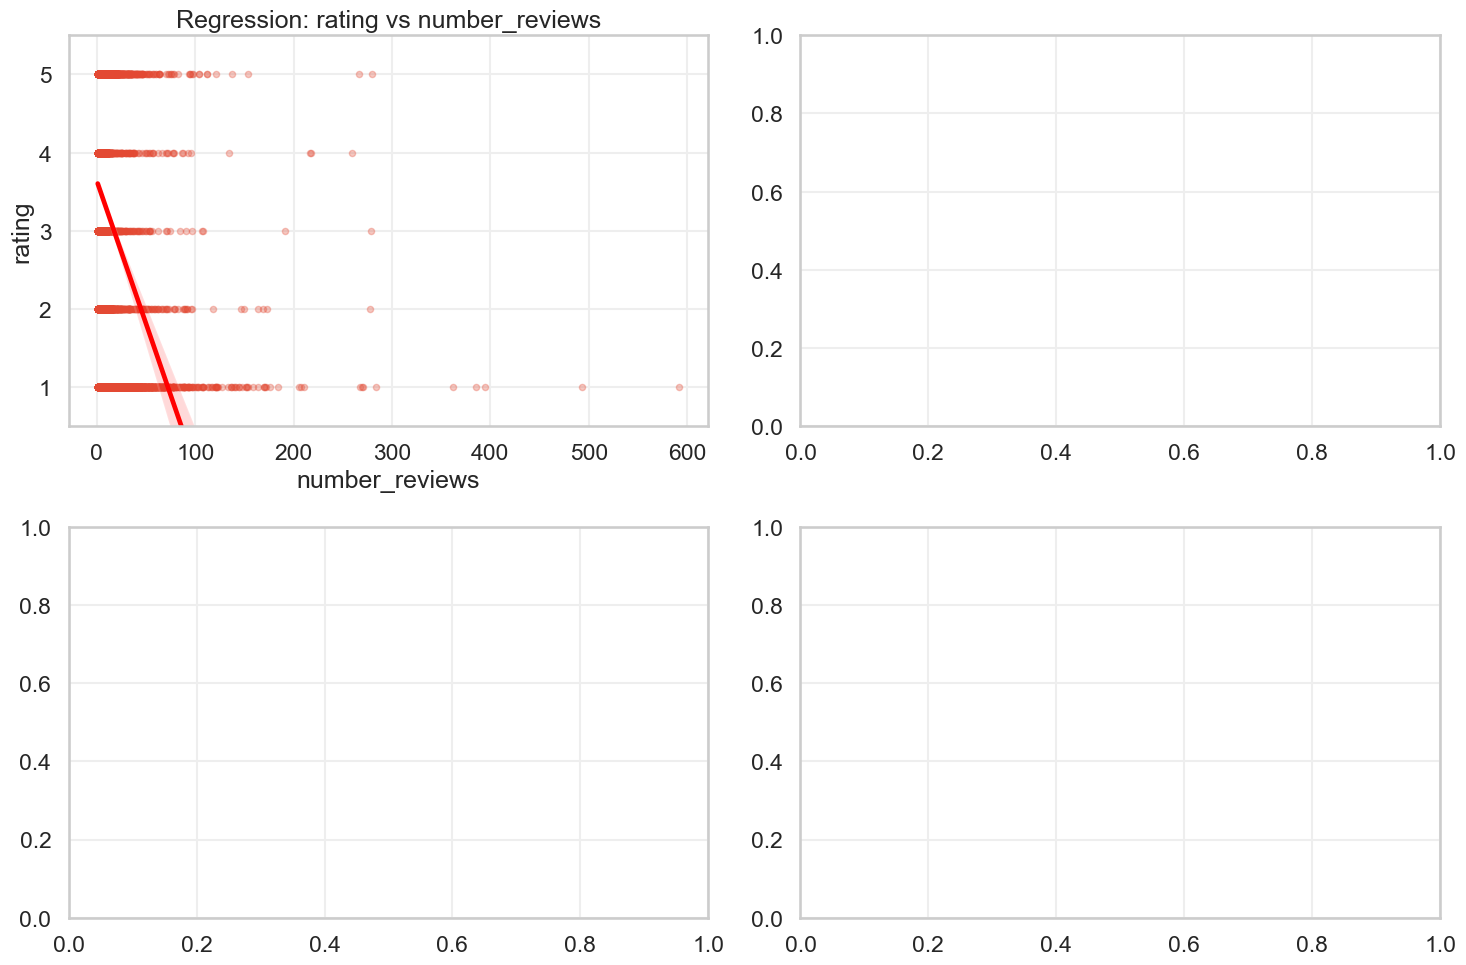

Correlation with rating: -0.215
Analyzing subject_length vs rating


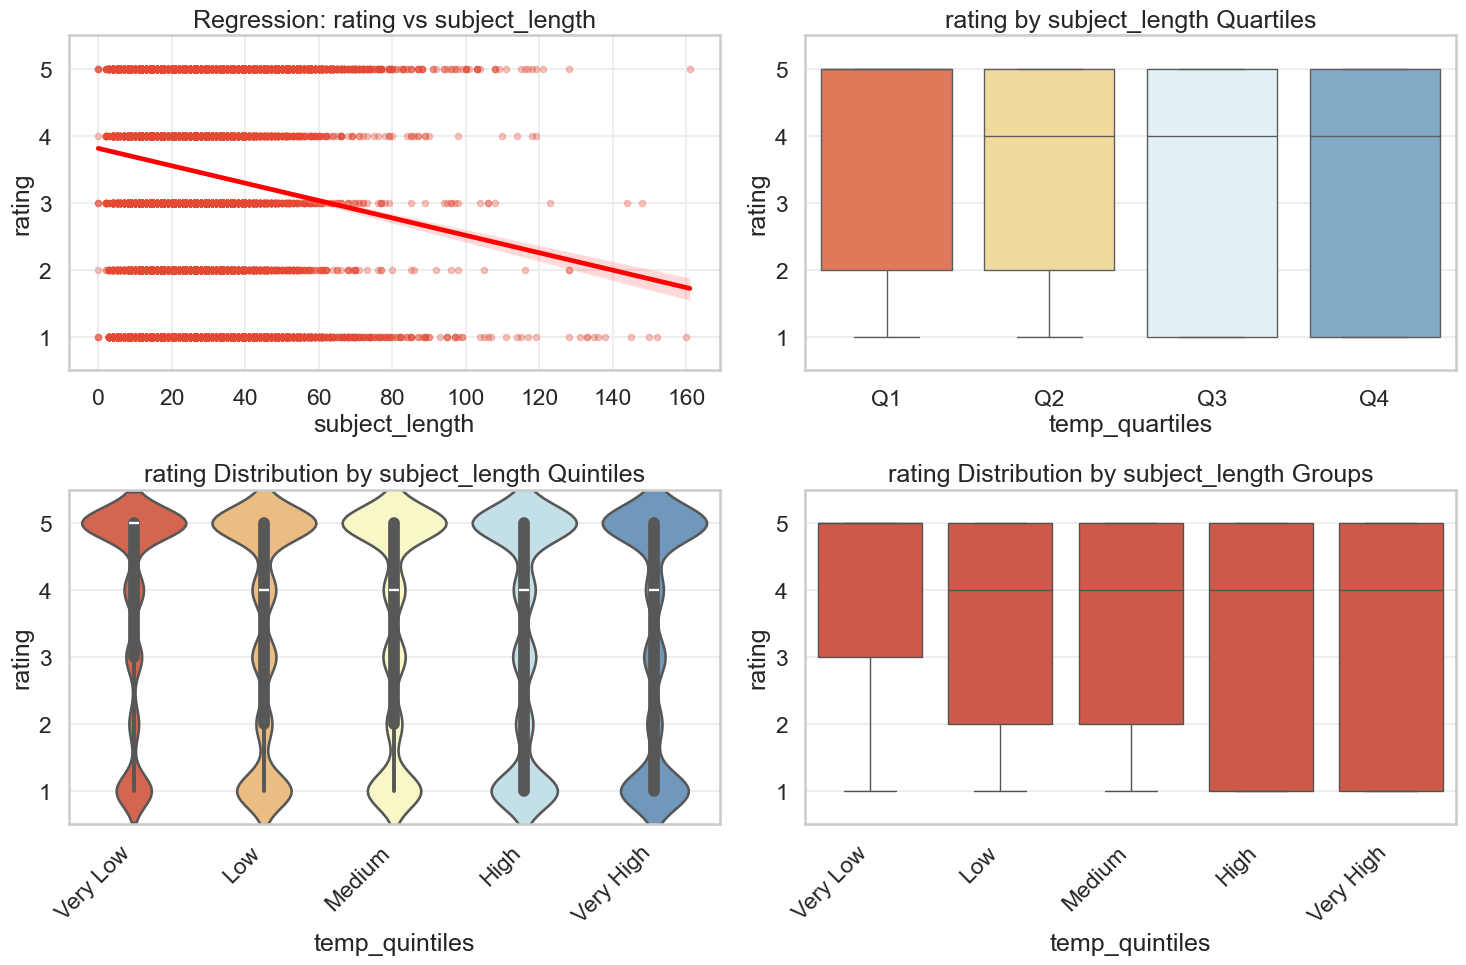

Correlation with rating: -0.082
Analyzing subject_word_length vs rating
Could not create quartile plot for subject_word_length
Could not create quintile plot for subject_word_length


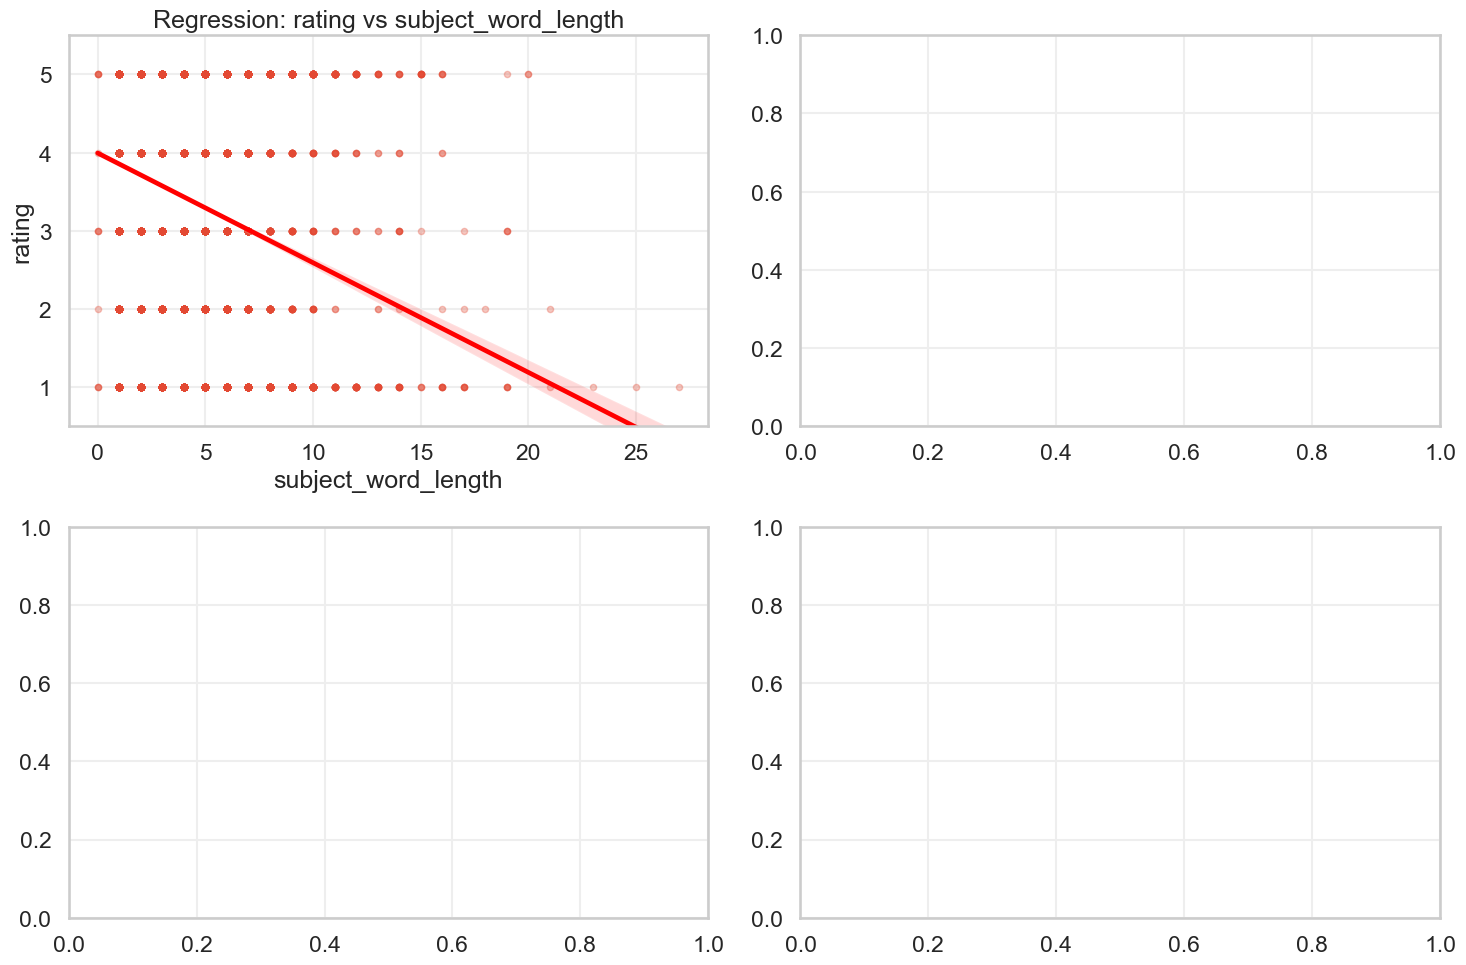

Correlation with rating: -0.121
Analyzing text_length vs rating


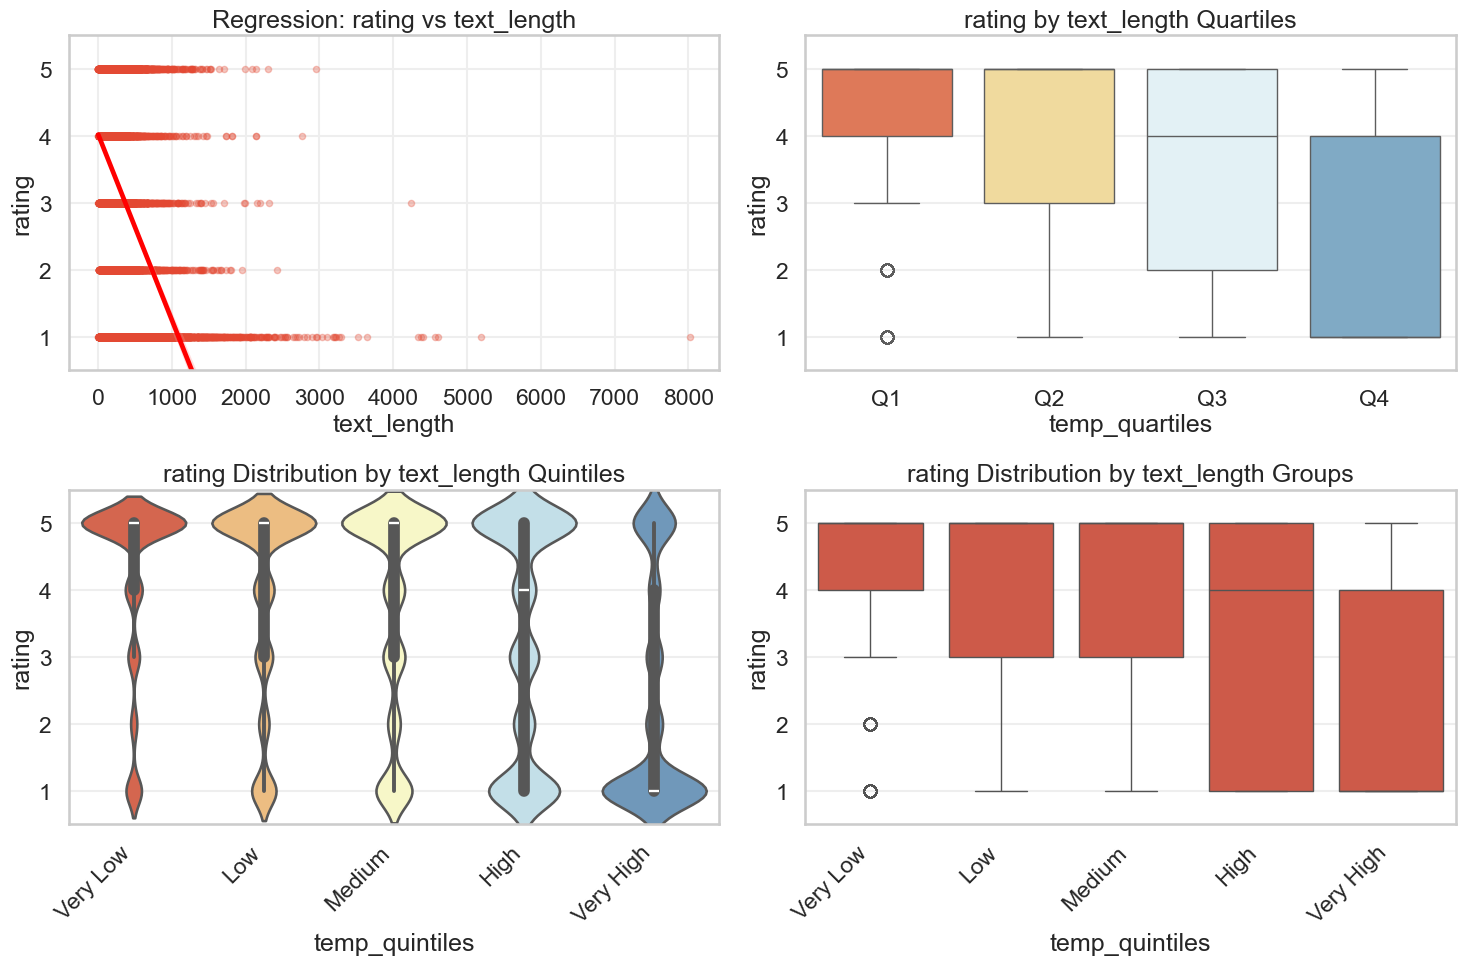

Correlation with rating: -0.358
Analyzing text_word_length vs rating


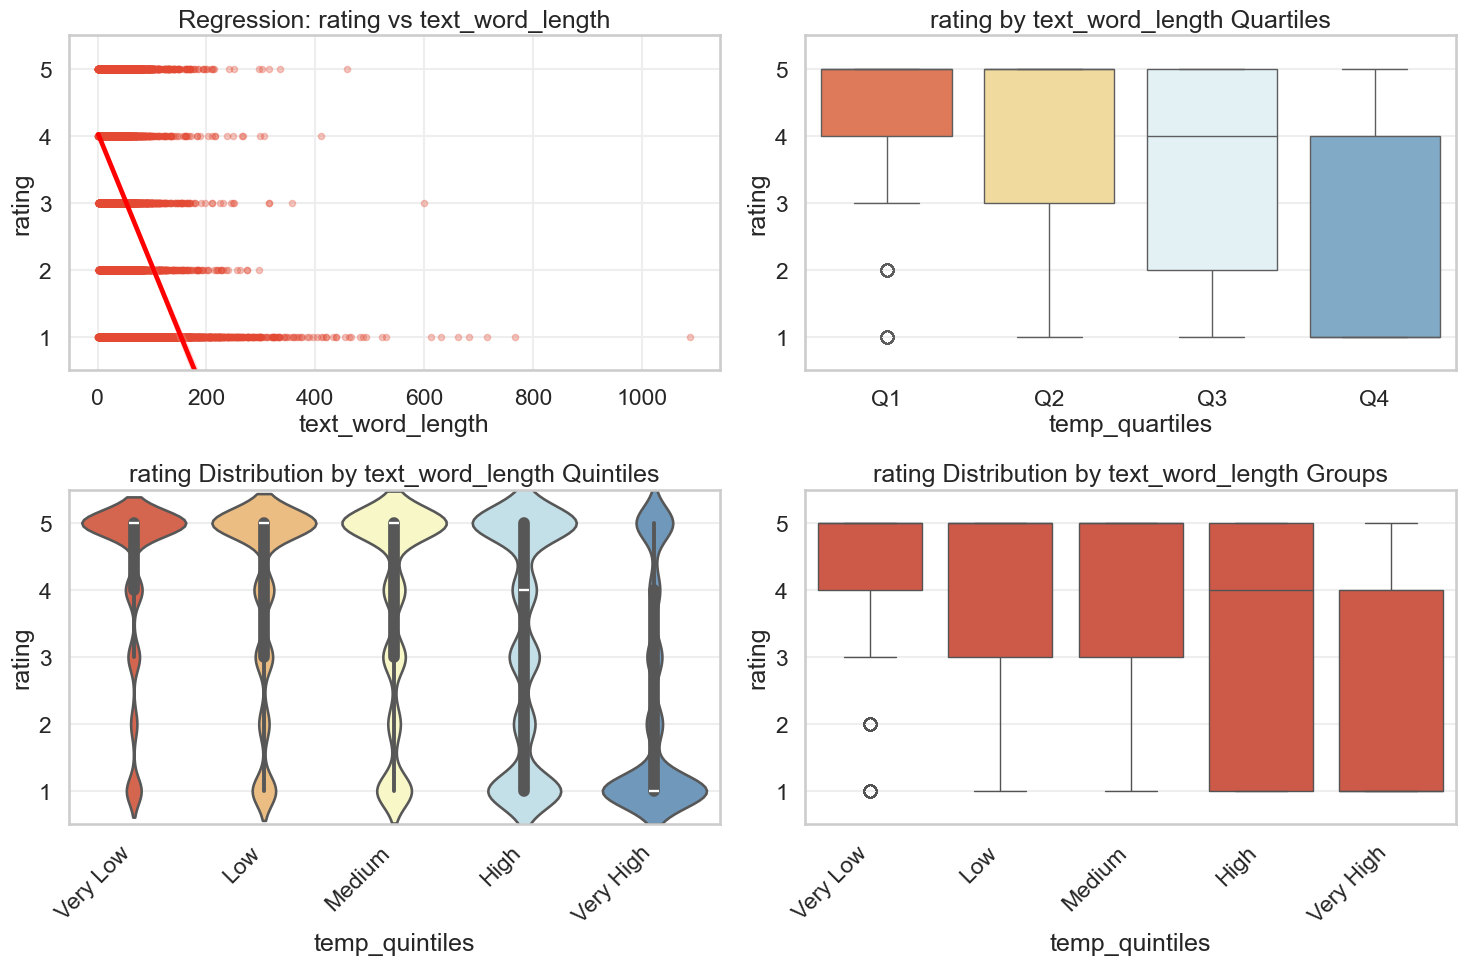

Correlation with rating: -0.375
Analyzing time_of_day vs rating


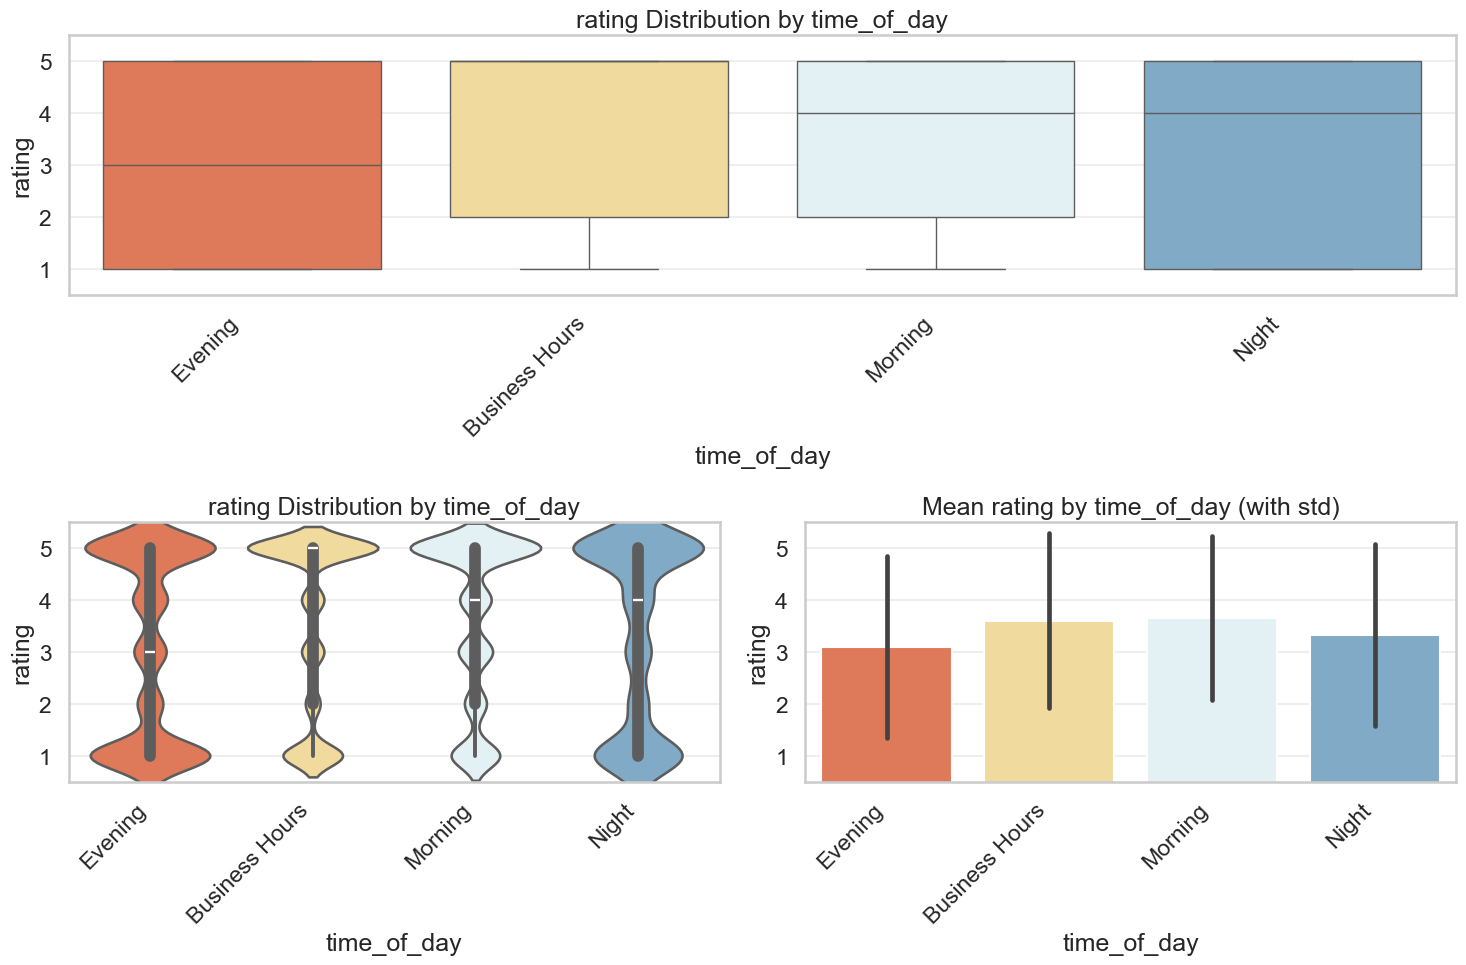

Summary Statistics for Top Categories:
                count  mean   std  median
time_of_day                              
Business Hours  37253  3.60  1.68     5.0
Evening         10960  3.09  1.76     3.0
Morning         12465  3.65  1.57     4.0
Night            3757  3.32  1.75     4.0
Analyzing verification vs rating


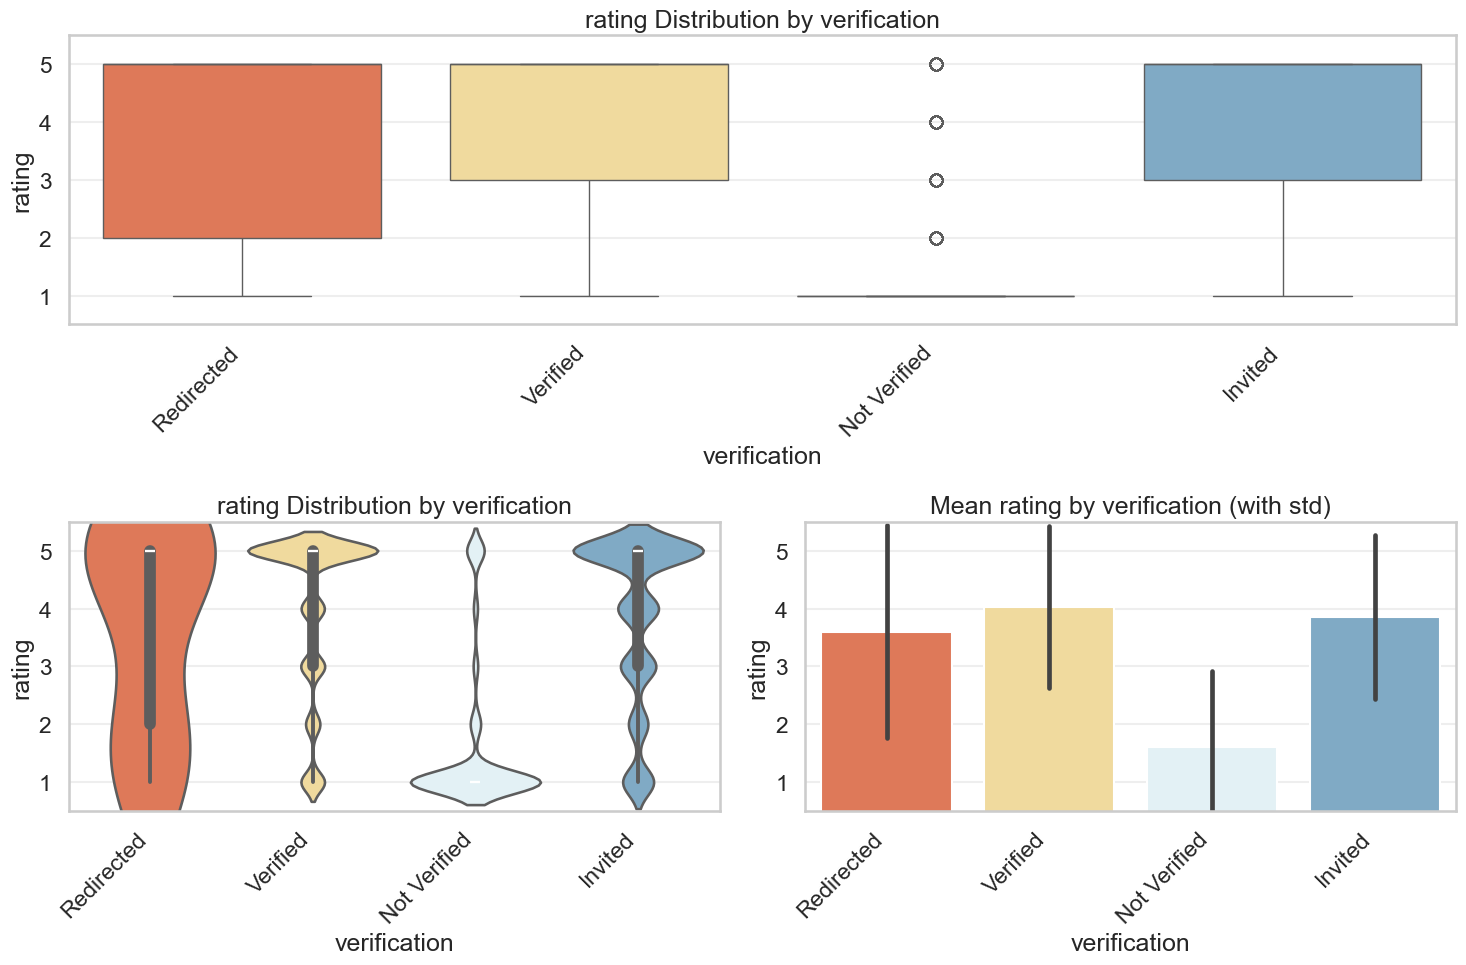

Summary Statistics for Top Categories:
              count  mean   std  median
verification                           
Invited        8926  3.86  1.42     5.0
Not Verified  13338  1.61  1.30     1.0
Redirected       10  3.60  1.84     5.0
Verified      42161  4.03  1.40     5.0


In [252]:
#Multivariate analysis of remaining columns

multivariate_pending_columns = list(set(df_trustpilot.columns) - 
                                  set(binary_columns) - 
                                  set(sentiment_columns) - 
                                  set(text_based_columns) - 
                                  set(administrative_columns))

def analyze_multivariate_pending(df, column, target='rating'):
    print(f"Analyzing {column} vs {target}")
    
    try:
        df[column].astype(float)
        is_numeric = True
    except:
        is_numeric = False
    
    if is_numeric:
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(2, 2)
        
        # Scatter plot with regression line
        ax1 = fig.add_subplot(gs[0, 0])
        sns.regplot(data=df, x=column, y=target, 
                   scatter_kws={'alpha':0.3, 's':20},
                   line_kws={'color': 'red'},
                   ax=ax1)
        ax1.set_title(f'Regression: {target} vs {column}')
        ax1.set_ylim(0.5, 5.5)
        
        # Distribution by quartiles
        ax2 = fig.add_subplot(gs[0, 1])
        try:
            df['temp_quartiles'] = pd.qcut(df[column], q=4, 
                                         labels=['Q1', 'Q2', 'Q3', 'Q4'],
                                         duplicates='drop')
            sns.boxplot(data=df, x='temp_quartiles', y=target,
                       palette='RdYlBu',
                       ax=ax2)
            ax2.set_title(f'{target} by {column} Quartiles')
            ax2.set_ylim(0.5, 5.5)
        except:
            print(f"Could not create quartile plot for {column}")
            
        # Violin plot
        ax3 = fig.add_subplot(gs[1, 0])
        try:
            df['temp_quintiles'] = pd.qcut(df[column], q=5, 
                                         labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
                                         duplicates='drop')
            sns.violinplot(data=df, x='temp_quintiles', y=target,
                         palette='RdYlBu',
                         ax=ax3)
            ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
            ax3.set_title(f'{target} Distribution by {column} Quintiles')
            ax3.set_ylim(0.5, 5.5)
        except:
            print(f"Could not create quintile plot for {column}")
            
        # Distribution plot
        ax4 = fig.add_subplot(gs[1, 1])
        if 'temp_quintiles' in df.columns:
            sns.boxplot(data=df, x='temp_quintiles', y=target, ax=ax4)
            ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
            ax4.set_title(f'{target} Distribution by {column} Groups')
            ax4.set_ylim(0.5, 5.5)
        
        plt.tight_layout()
        plt.show()
        
        df.drop(['temp_quartiles', 'temp_quintiles'], axis=1, errors='ignore', inplace=True)
        
        # Statistical analysis
        correlation = df[column].corr(df[target])
        print(f"Correlation with {target}: {correlation:.3f}")
        
    elif pd.api.types.is_datetime64_dtype(df[column]):
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(2, 2)
        
        # Monthly boxplot
        ax1 = fig.add_subplot(gs[0, :])
        sns.boxplot(data=df, x=df[column].dt.month, y=target,
                   palette='RdYlBu',
                   ax=ax1)
        ax1.set_title(f'{target} Distribution by Month')
        ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        ax1.set_ylim(0.5, 5.5)
        
        # Monthly trend
        ax2 = fig.add_subplot(gs[1, 0])
        monthly_means = df.groupby(df[column].dt.month)[target].mean()
        sns.lineplot(data=monthly_means, marker='o', ax=ax2)
        ax2.set_title(f'Monthly {target} Trend')
        ax2.set_xticks(range(1, 13))
        ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                           rotation=45)
        ax2.set_ylim(0.5, 5.5)
        
        # Day of week analysis
        ax3 = fig.add_subplot(gs[1, 1])
        sns.boxplot(data=df, x=df[column].dt.dayofweek, y=target,
                   palette='RdYlBu',
                   ax=ax3)
        ax3.set_title(f'{target} by Day of Week')
        ax3.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        ax3.set_ylim(0.5, 5.5)
        
        plt.tight_layout()
        plt.show()
        
    else:
        # Categorical analysis
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(2, 2)
        
        # Get top categories
        top_cats = df[column].value_counts().head(10).index
        df_filtered = df[df[column].isin(top_cats)]
        
        # Boxplot
        ax1 = fig.add_subplot(gs[0, :])
        sns.boxplot(data=df_filtered, x=column, y=target,
                   palette='RdYlBu',
                   ax=ax1)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        ax1.set_title(f'{target} Distribution by {column}')
        ax1.set_ylim(0.5, 5.5)
        
        # Violin plot
        ax2 = fig.add_subplot(gs[1, 0])
        sns.violinplot(data=df_filtered, x=column, y=target,
                      palette='RdYlBu',
                      ax=ax2)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        ax2.set_title(f'{target} Distribution by {column}')
        ax2.set_ylim(0.5, 5.5)
        
        # Bar plot with error bars
        ax3 = fig.add_subplot(gs[1, 1])
        sns.barplot(data=df_filtered, x=column, y=target,
                   palette='RdYlBu',
                   ci='sd',
                   ax=ax3)
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
        ax3.set_title(f'Mean {target} by {column} (with std)')
        ax3.set_ylim(0.5, 5.5)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical analysis
        print("Summary Statistics for Top Categories:")
        summary = df_filtered.groupby(column)[target].agg([
            'count', 'mean', 'std', 'median'
        ]).round(2)
        print(summary)

sns.set_theme(style="whitegrid", context="talk", palette="RdYlBu")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#EEEEEE'

for column in sorted(multivariate_pending_columns):
    if column not in binary_columns + sentiment_columns + ['rating']:
        analyze_multivariate_pending(df_trustpilot, column)

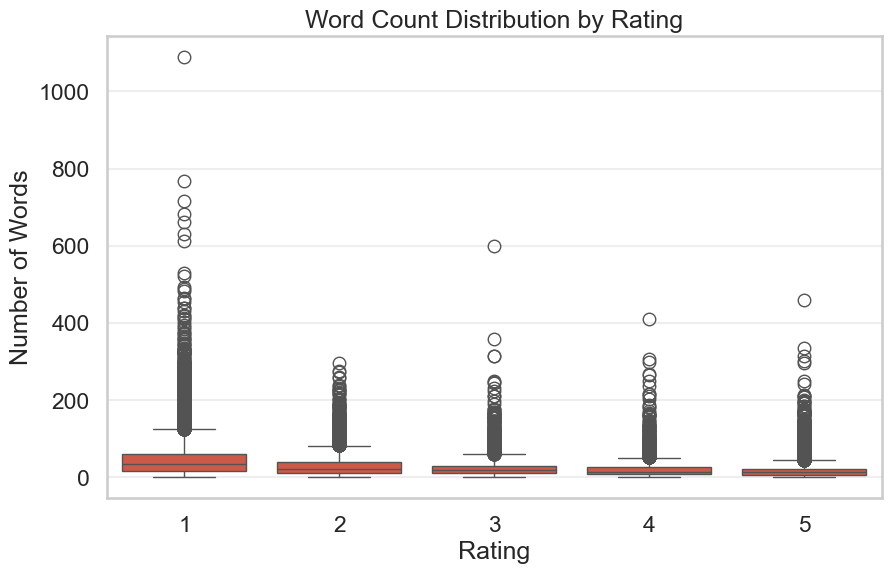

In [253]:
#Word length distribution by rating

plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='text_word_length', data=df_trustpilot)
plt.title('Word Count Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Words')
plt.show()


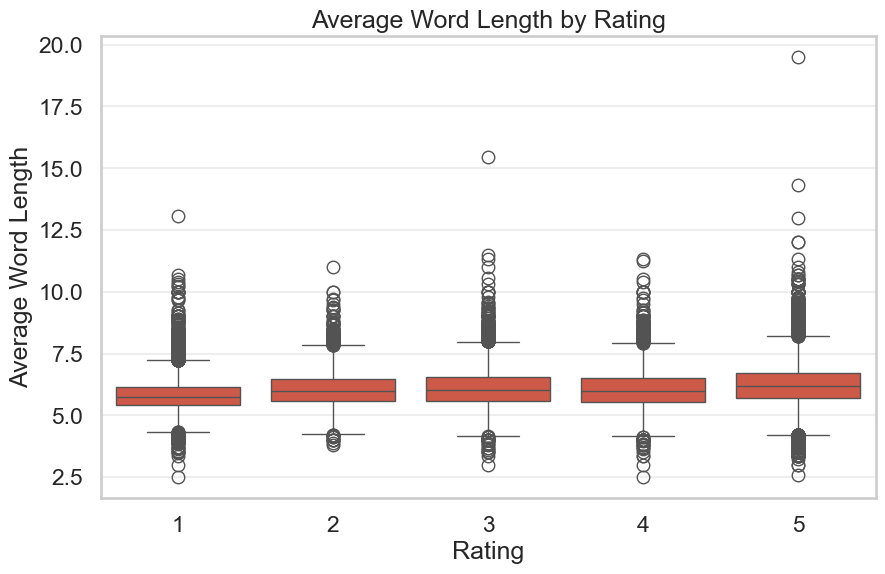

In [254]:
#Average word length by rating

df_trustpilot['avg_word_length'] = df_trustpilot['text_processed'].apply(lambda x: np.mean([len(word) for word in x.split()]))
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='avg_word_length', data=df_trustpilot)
plt.title('Average Word Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Word Length')
plt.show()

In [255]:
print(df_trustpilot.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64435 entries, 0 to 64434
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            64435 non-null  int64         
 1   location                          64435 non-null  object        
 2   username                          64433 non-null  object        
 3   number_reviews                    64435 non-null  int64         
 4   verification                      64435 non-null  object        
 5   repeat_reviewer                   64435 non-null  object        
 6   repeat_reviewer_encoded           64435 non-null  int64         
 7   company                           64435 non-null  object        
 8   text                              64435 non-null  object        
 9   text_processed                    64435 non-null  object        
 10  text_length                       64435 non-nu

STAGE 3 - TEXT-BASED VISUALIZATIONS

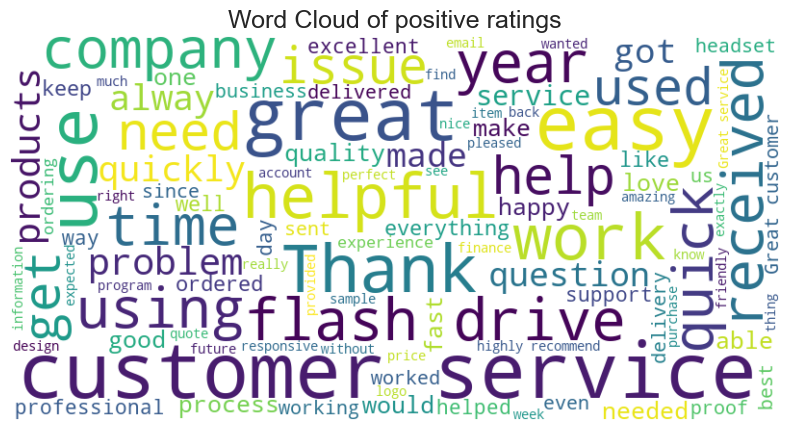

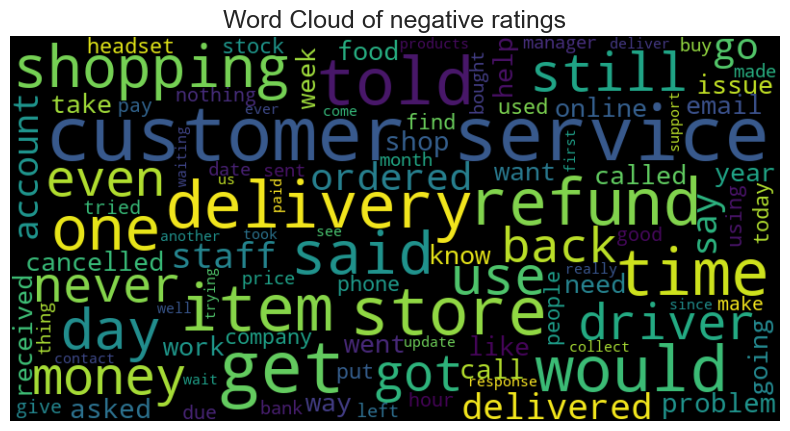

In [256]:
#Creating positive and negative wordclouds

# stop words
stop_words = set(stopwords.words('english'))
stop_words.update(["product", "order", "I've", "could", "I'm", "u", "also", "tell", "flashbay", "asda", "quicken", "steelseries"])



# splitting good and bad rated words
df_pos = df_trustpilot.loc[df_trustpilot["rating"]==5]

df_neg = df_trustpilot.loc[df_trustpilot["rating"]==1]


#creating positive word cloud
text = " ".join(df_pos["text"])
wordcloud = WordCloud(background_color="white", max_words=100, stopwords=stop_words, width = 800, height = 400). generate(text)

plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud of positive ratings")
plt.show()


#creating negative word cloud
text = " ".join(df_neg["text"])
wordcloud = WordCloud(background_color="black", max_words=100, stopwords=stop_words, width = 800, height = 400). generate(text)

plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.title("Word Cloud of negative ratings")
plt.axis("off")
plt.show()


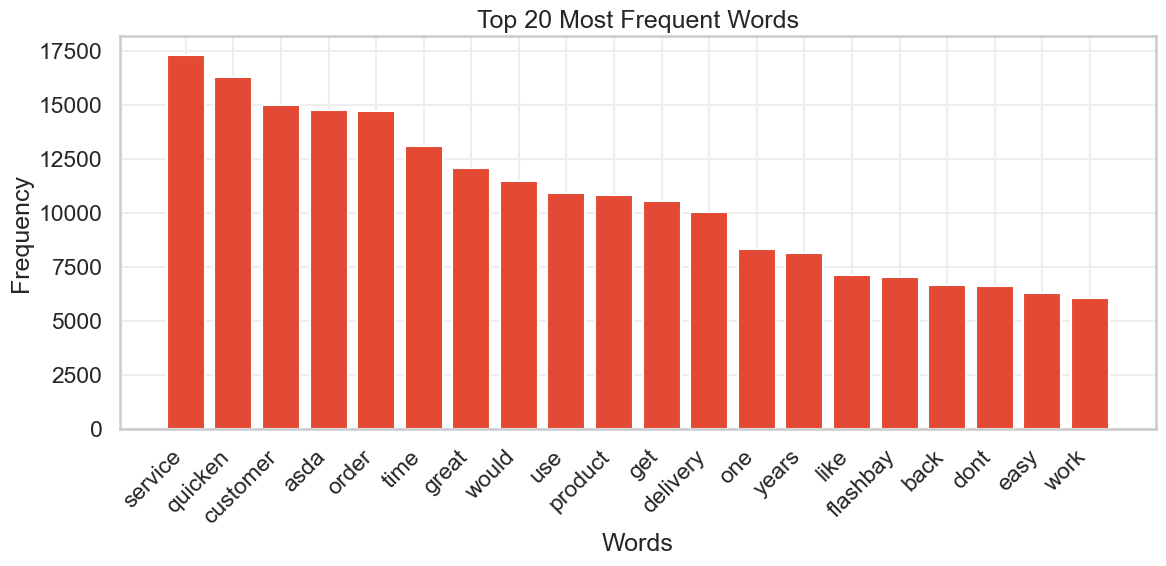

In [257]:
#Word Frequency plot

plt.figure(figsize=(12, 6))
word_freq = Counter(' '.join(df_trustpilot['text_processed']).split()).most_common(20)
words, counts = zip(*word_freq)
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

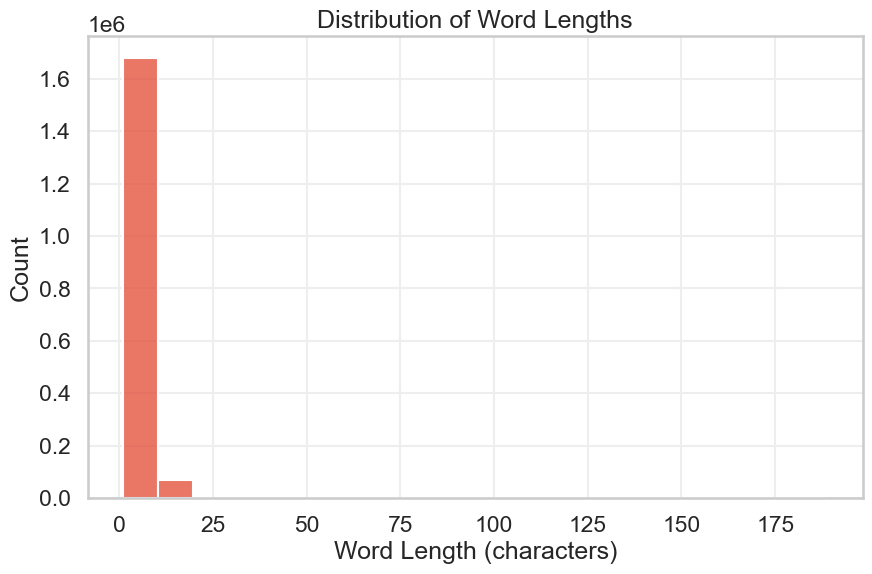

In [258]:
#Word Length distribution

plt.figure(figsize=(10, 6))
word_lengths = [len(word) for word in ' '.join(df_trustpilot['text_processed']).split()]
sns.histplot(word_lengths, bins=20)
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length (characters)')
plt.ylabel('Count')
plt.show()

STAGE 4 - TIME SERIES PLOT

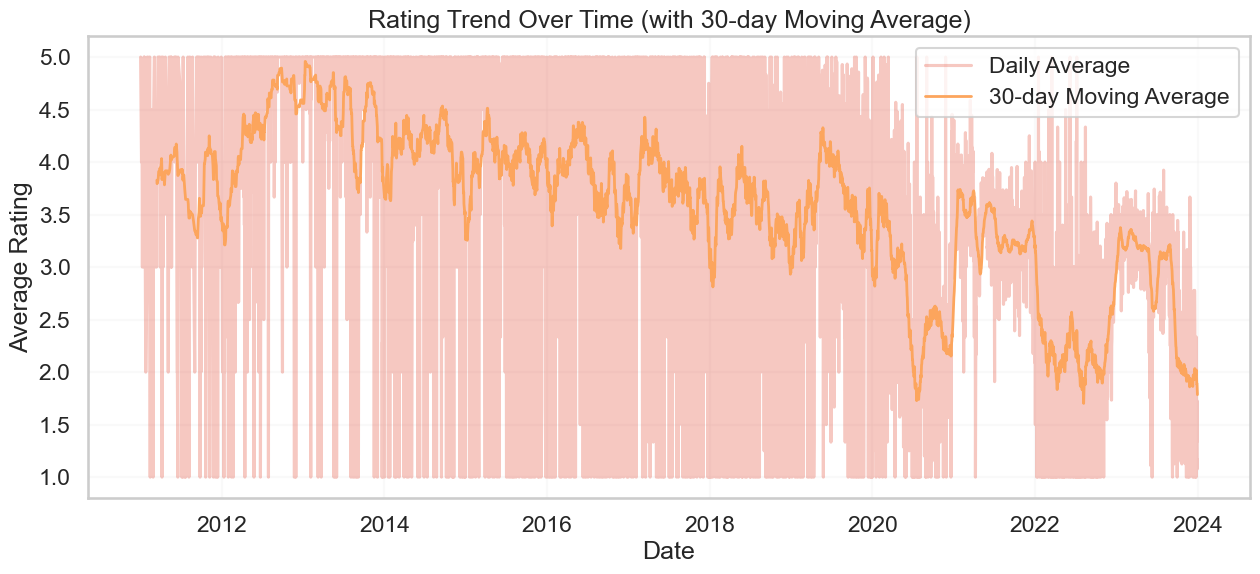

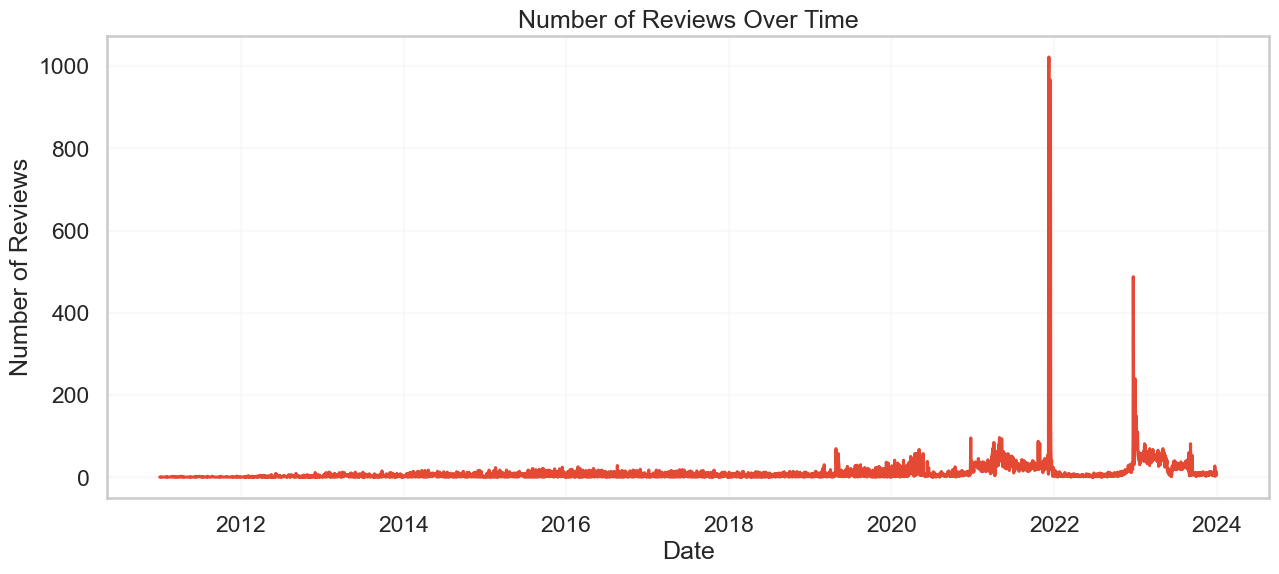

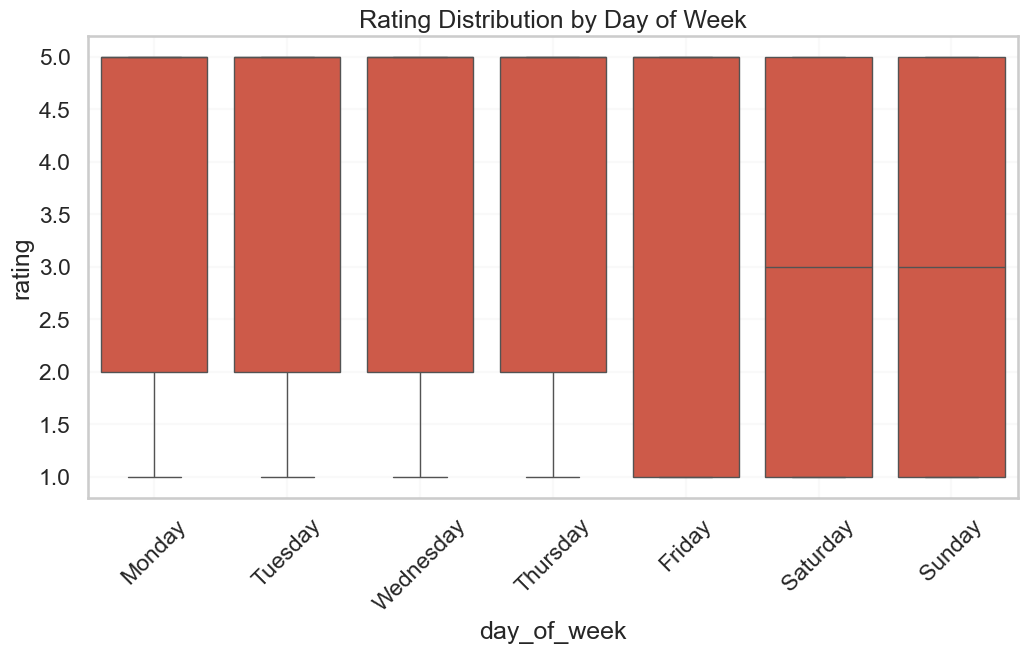

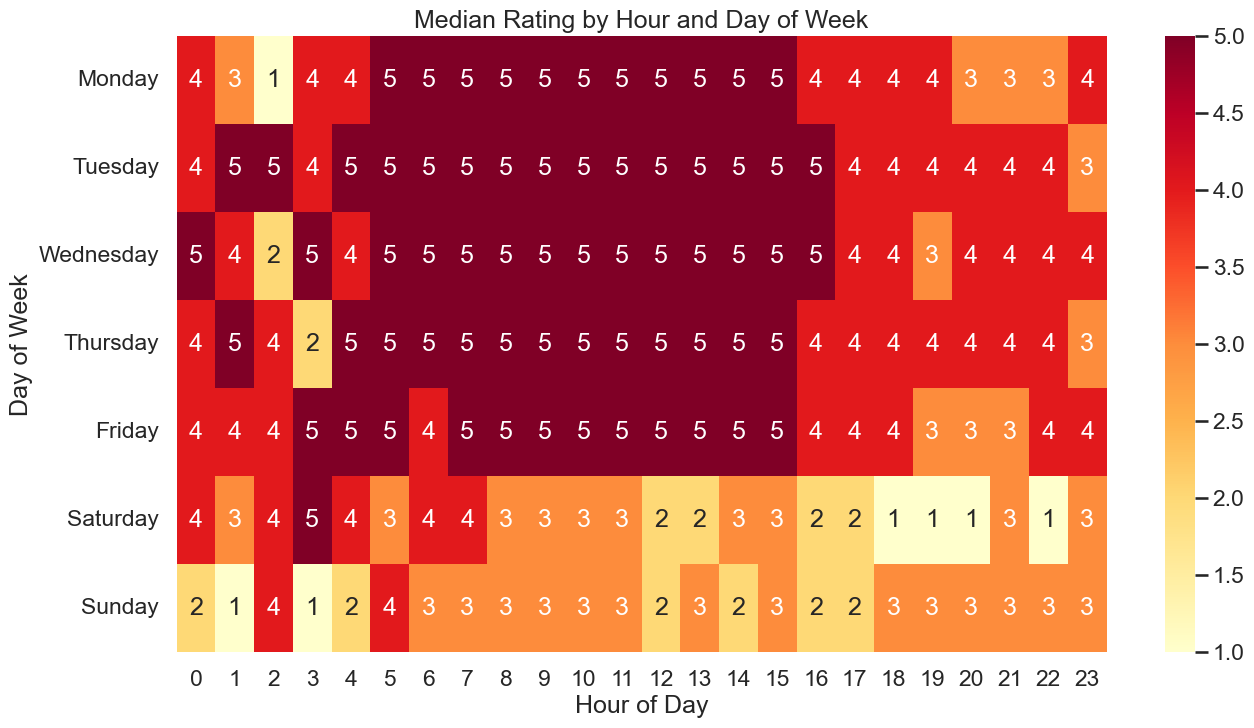

Time Series Statistics:
Start Date: 2011-01-02 00:00:00
End Date: 2023-12-31 00:00:00
Busiest Day: 2021-12-08 00:00:00 with 1022 reviews
Best Rating Day: 2011-01-02 00:00:00 with average rating of 5.00
Worst Rating Day: 2011-02-14 00:00:00 with average rating of 1.00


In [259]:
# Time series plot

# Defining reasonable date range
start_date = '2011-01-01'
end_date = '2023-12-31'

# Filtering the data
filtered_df = df_trustpilot[
    (df_trustpilot['local_date_posted'] >= start_date) & 
    (df_trustpilot['local_date_posted'] <= end_date)
]

# Daily Average Rating Over Time 
daily_avg = filtered_df.groupby('local_date_posted')['rating'].mean()

# Rolling Average to Smooth Daily 
plt.figure(figsize=(15, 6))
rolling_avg = daily_avg.rolling(window=30).mean()
plt.plot(daily_avg.index, daily_avg.values, alpha=0.3, label='Daily Average')
plt.plot(rolling_avg.index, rolling_avg.values, linewidth=2, label='30-day Moving Average')
plt.title('Rating Trend Over Time (with 30-day Moving Average)')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Volume of Reviews Over Time
plt.figure(figsize=(15, 6))
daily_count = filtered_df.groupby('local_date_posted').size()
plt.plot(daily_count.index, daily_count.values)
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True, alpha=0.3)
plt.show()

# Day of Week Analysis
plt.figure(figsize=(12, 6))
filtered_df['day_of_week'] = filtered_df['local_date_posted'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=filtered_df, x='day_of_week', y='rating', order=day_order)
plt.title('Rating Distribution by Day of Week')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

# Heatmap: Hour vs Day of Week
plt.figure(figsize=(15, 8))
pivot_table = filtered_df.pivot_table(
    values='rating',
    index=filtered_df['local_date_posted'].dt.day_name(),
    columns='local_hour',
    aggfunc='median'
)
pivot_table = pivot_table.reindex(day_order)
pivot_table = pivot_table.round(0)
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Median Rating by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

# Print statistics
print("Time Series Statistics:")
print(f"Start Date: {filtered_df['local_date_posted'].min()}")
print(f"End Date: {filtered_df['local_date_posted'].max()}")
print(f"Busiest Day: {daily_count.idxmax()} with {daily_count.max()} reviews")
print(f"Best Rating Day: {daily_avg.idxmax()} with average rating of {daily_avg.max():.2f}")
print(f"Worst Rating Day: {daily_avg.idxmin()} with average rating of {daily_avg.min():.2f}")

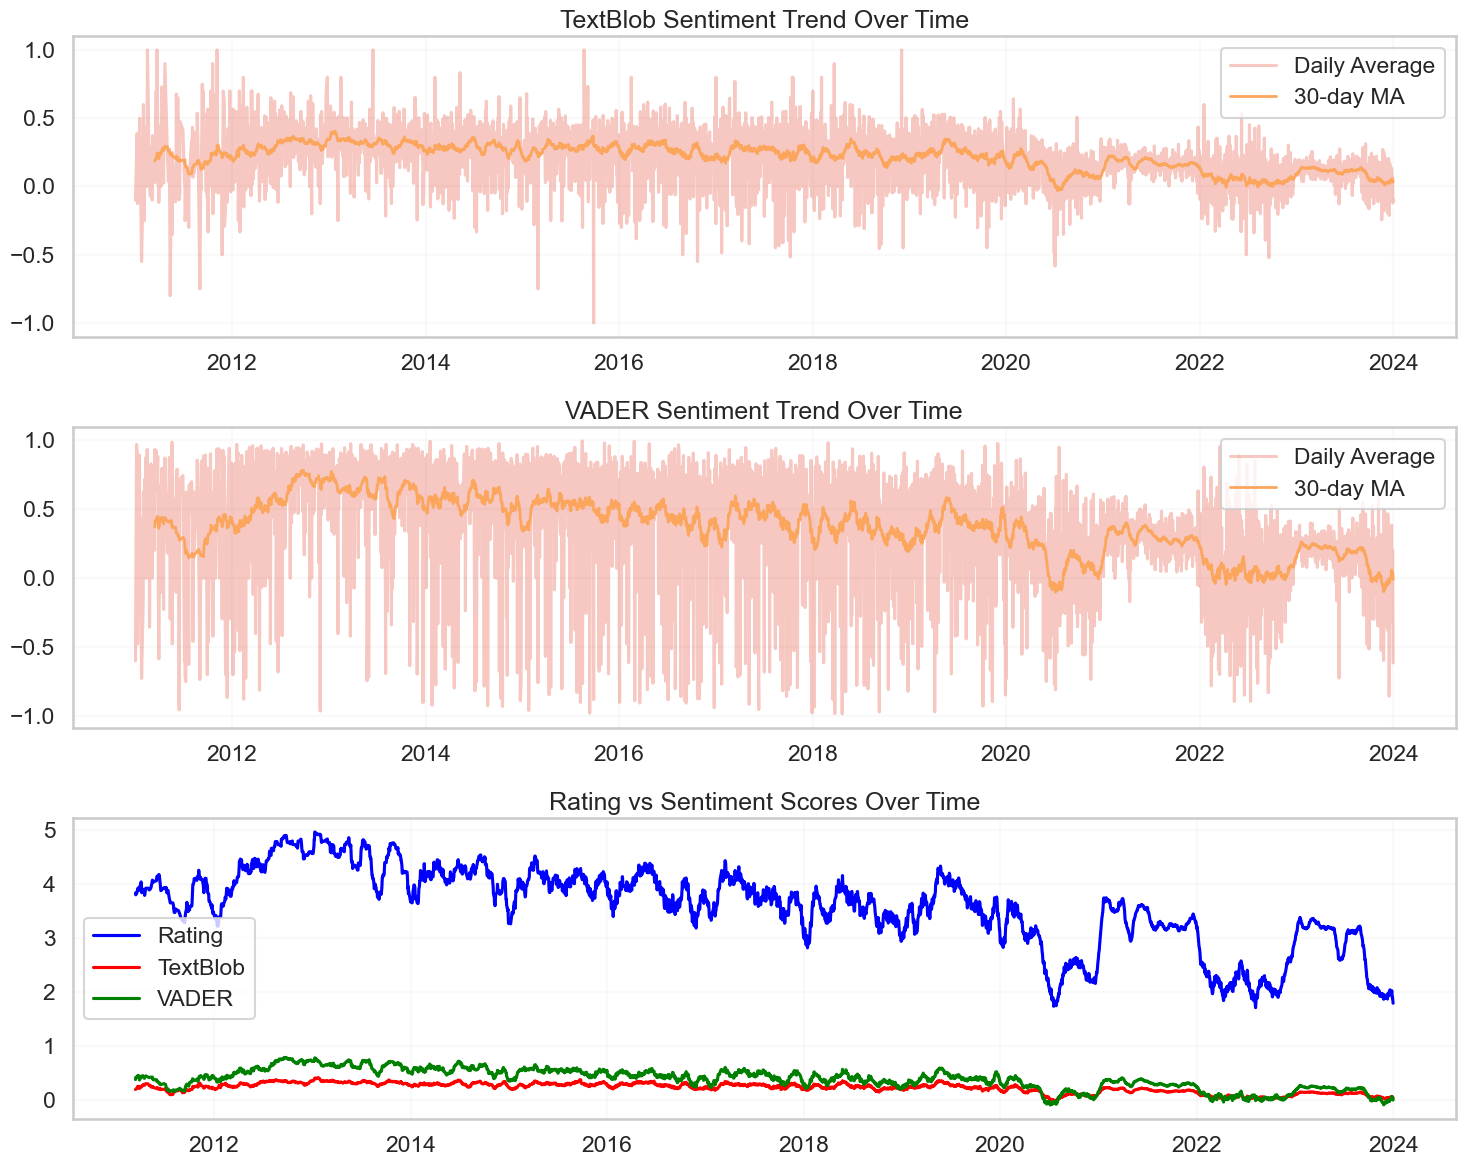

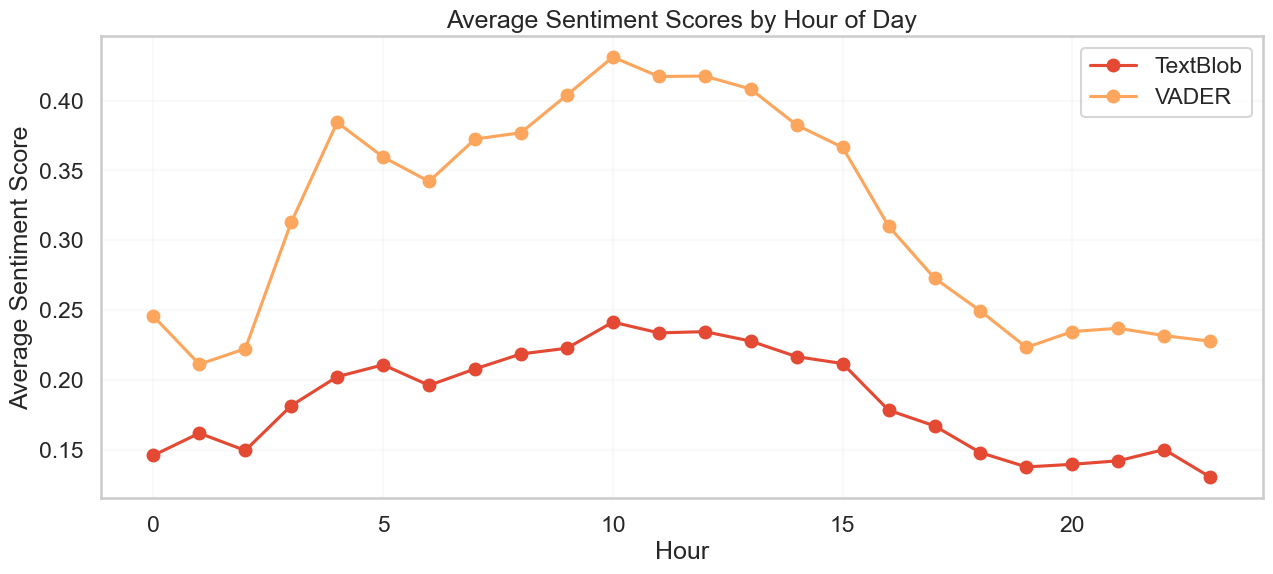

In [260]:
#Time series for sentiment

def analyze_sentiment_time_series():
    plt.figure(figsize=(15, 12))
    
    # Daily averages
    daily_sentiment_blob = filtered_df.groupby('local_date_posted')['Sentiment_Blob'].mean()
    daily_sentiment_vader = filtered_df.groupby('local_date_posted')['Sentiment_VADER'].mean()
    
    # Rolling averages
    rolling_sentiment_blob = daily_sentiment_blob.rolling(window=30).mean()
    rolling_sentiment_vader = daily_sentiment_vader.rolling(window=30).mean()
    
    # Plot TextBlob trends
    plt.subplot(311)
    plt.plot(daily_sentiment_blob.index, daily_sentiment_blob.values, 
             alpha=0.3, label='Daily Average')
    plt.plot(rolling_sentiment_blob.index, rolling_sentiment_blob.values, 
             linewidth=2, label='30-day MA')
    plt.title('TextBlob Sentiment Trend Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot VADER trends
    plt.subplot(312)
    plt.plot(daily_sentiment_vader.index, daily_sentiment_vader.values, 
             alpha=0.3, label='Daily Average')
    plt.plot(rolling_sentiment_vader.index, rolling_sentiment_vader.values, 
             linewidth=2, label='30-day MA')
    plt.title('VADER Sentiment Trend Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Compare with ratings
    plt.subplot(313)
    plt.plot(rolling_avg.index, rolling_avg.values, label='Rating', color='blue')
    plt.plot(rolling_sentiment_blob.index, rolling_sentiment_blob.values, 
             label='TextBlob', color='red')
    plt.plot(rolling_sentiment_vader.index, rolling_sentiment_vader.values, 
             label='VADER', color='green')
    plt.title('Rating vs Sentiment Scores Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Hourly patterns
    plt.figure(figsize=(15, 6))
    hourly_sentiment_blob = filtered_df.groupby('local_hour')['Sentiment_Blob'].mean()
    hourly_sentiment_vader = filtered_df.groupby('local_hour')['Sentiment_VADER'].mean()
    
    plt.plot(hourly_sentiment_blob.index, hourly_sentiment_blob.values, 
             marker='o', label='TextBlob')
    plt.plot(hourly_sentiment_vader.index, hourly_sentiment_vader.values, 
             marker='o', label='VADER')
    plt.title('Average Sentiment Scores by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Average Sentiment Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

analyze_sentiment_time_series()

STAGE 5 - GROUPBY ANALYSES

LOCATION ANALYSIS
Basic Location Metrics:
          Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Repeat_Reviewers  Pct_Verified
location                                                                                          
AU                  304       3.664       1.700            5.0                 0.414           0.0
CA                 1394       3.730       1.595            5.0                 0.246           0.0
DE                  667       4.030       1.455            5.0                 0.393           0.0
DK                  191       3.555       1.700            5.0                 0.806           0.0
FR                  335       4.024       1.512            5.0                 0.439           0.0
GB                13729       1.763       1.443            1.0                 0.811           0.0
NL                  363       3.972       1.525            5.0                 0.592           0.0
PL                  193       4.093       1.476            5.0     

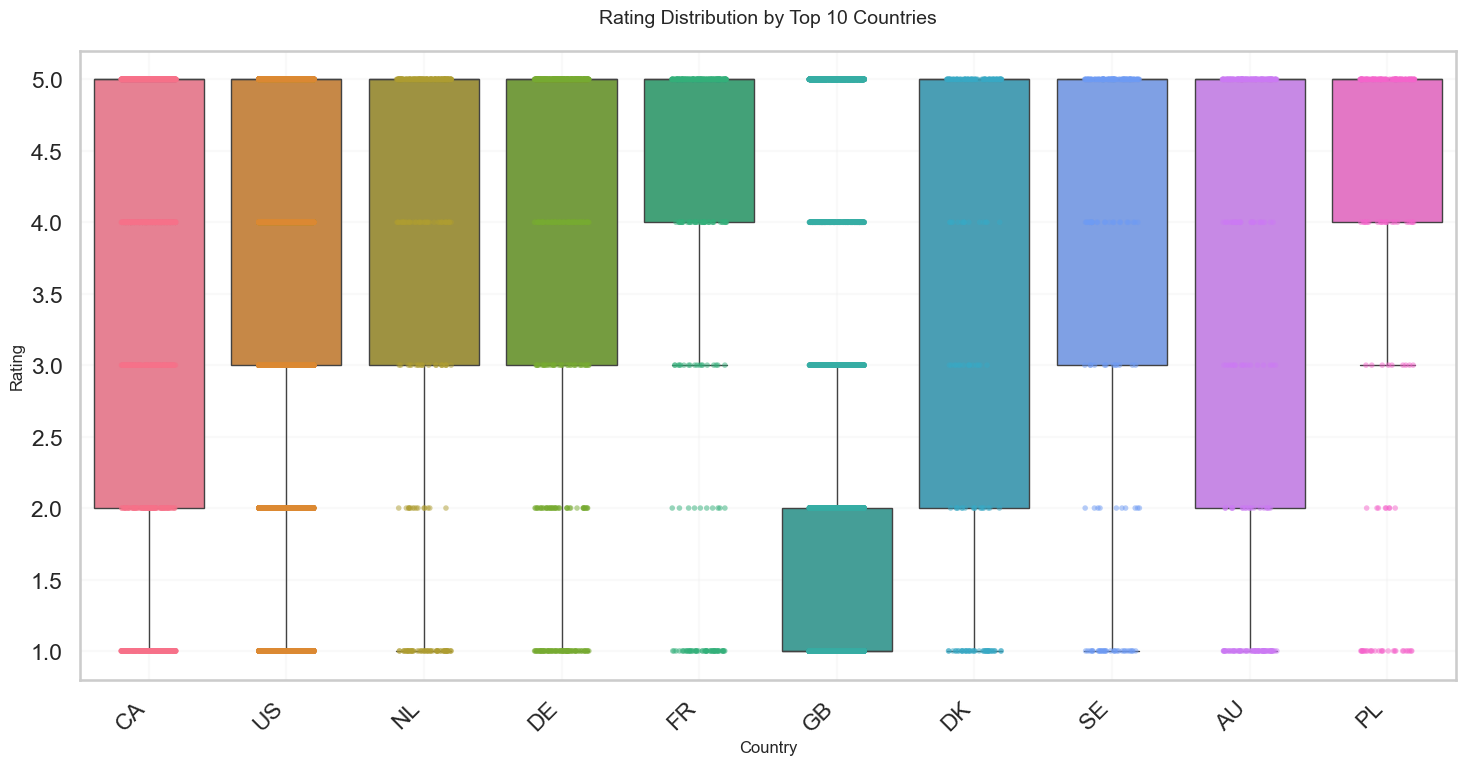

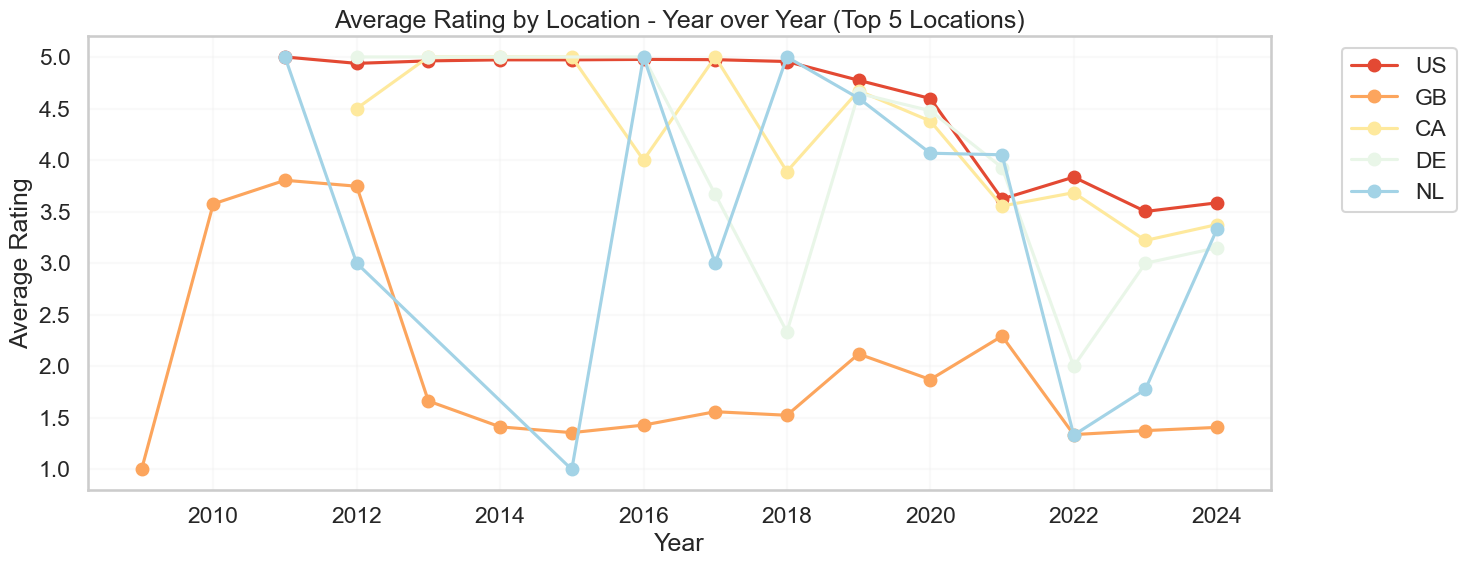

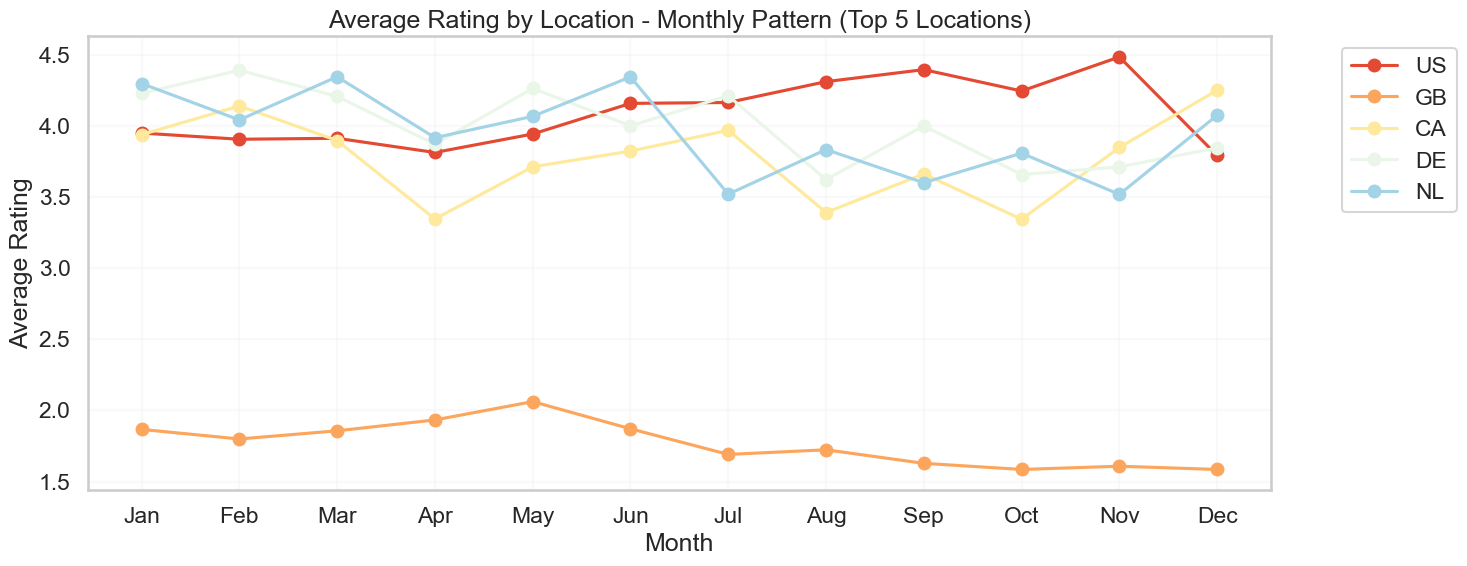

Summary Statistics by Location:
          count  mean  median   std
location                           
AU          304  3.66     5.0  1.70
CA         1394  3.73     5.0  1.60
DE          667  4.03     5.0  1.45
DK          191  3.55     5.0  1.70
FR          335  4.02     5.0  1.51
GB        13729  1.76     1.0  1.44
NL          363  3.97     5.0  1.52
PL          193  4.09     5.0  1.48
SE          204  3.99     5.0  1.52
US        44170  4.00     5.0  1.40


In [261]:
# Location Analysis
print("LOCATION ANALYSIS")

# Get top 10 locations and filter DataFrame
top_locations = df_trustpilot['location'].value_counts().head(10).index
df_filtered = df_trustpilot[df_trustpilot['location'].isin(top_locations)]

# Basic metrics by location (separated by data type)
numeric_analysis = df_filtered.groupby('location').agg({
    'rating': ['count', 'mean', 'std', 'median'],
    'repeat_reviewer_encoded': 'mean'
}).round(3)

# Handle verification separately (categorical)
verification_pcts = df_filtered.groupby('location')['verification'].apply(
    lambda x: (x == 'verified').mean()
).round(3)

# Combine the analyses
location_analysis = numeric_analysis.copy()
location_analysis['verification'] = verification_pcts

# Flatten column names
location_analysis.columns = ['Total_Reviews', 'Avg_Rating', 'Std_Rating', 
                           'Median_Rating', 'Pct_Repeat_Reviewers', 'Pct_Verified']
print("Basic Location Metrics:")
print(location_analysis)

# Day of week distribution by location
day_distribution = pd.crosstab(df_filtered['location'], 
                              df_filtered['day_of_week_posted'], 
                              normalize='index').round(3) * 100
print("Day of Week Distribution by Location (%):")
print(day_distribution)

# Time of day distribution by location
time_distribution = pd.crosstab(df_filtered['location'], 
                               df_filtered['time_of_day'], 
                               normalize='index').round(3) * 100
print("Time of Day Distribution by Location (%):")
print(time_distribution)

# Rating distribution by location
rating_distribution = pd.crosstab(df_filtered['location'], 
                                 df_filtered['rating'], 
                                 normalize='index').round(3) * 100
print("Rating Distribution by Location (%):")
print(rating_distribution)

# Recent trends (last 90 days)
recent_cutoff = df_filtered['local_date_posted'].max() - pd.Timedelta(days=90)
recent_data = df_filtered[df_filtered['local_date_posted'] >= recent_cutoff]

recent_numeric = recent_data.groupby('location').agg({
    'rating': ['count', 'mean']
}).round(3)

recent_verification = recent_data.groupby('location')['verification'].apply(
    lambda x: (x == 'verified').mean()
).round(3)

recent_repeat = recent_data.groupby('location')['repeat_reviewer_encoded'].mean().round(3)

# Combine recent analyses
recent_analysis = pd.DataFrame({
    'Recent_Review_Count': recent_numeric[('rating', 'count')],
    'Recent_Avg_Rating': recent_numeric[('rating', 'mean')],
    'Recent_Verification_Rate': recent_verification,
    'Recent_Repeat_Reviewer_Rate': recent_repeat
})

print("Recent 90-Day Metrics by Location:")
print(recent_analysis)

# Visualizations
plt.figure(figsize=(15, 8))
sns.boxplot(x='location', y='rating', data=df_filtered,
            palette='husl',
            showfliers=False)
sns.stripplot(x='location', y='rating', data=df_filtered,
              palette='husl',
              size=4,
              jitter=0.2,
              alpha=0.5)
plt.title('Rating Distribution by Top 10 Countries', fontsize=14, pad=20)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Year over Year Analysis (Top 5)
top_5_locations = df_trustpilot['location'].value_counts().head(5).index
df_filtered_top5 = df_filtered[df_filtered['location'].isin(top_5_locations)]

plt.figure(figsize=(15, 6))
for location in top_5_locations:
    yearly_avg = df_filtered_top5[df_filtered_top5['location'] == location].groupby(
        df_filtered_top5['local_date_posted'].dt.year)['rating'].mean()
    plt.plot(yearly_avg.index, yearly_avg.values, marker='o', label=location)

plt.title('Average Rating by Location - Year over Year (Top 5 Locations)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Month over Month Analysis (Top 5)
plt.figure(figsize=(15, 6))
for location in top_5_locations:
    location_data = df_filtered_top5[df_filtered_top5['location'] == location]
    monthly_avg = location_data.groupby(
        location_data['local_date_posted'].dt.month)['rating'].mean()
    plt.plot(range(1, 13), monthly_avg, marker='o', label=location)

plt.title('Average Rating by Location - Monthly Pattern (Top 5 Locations)')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.xticks(range(1, 13), 
          ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Summary Statistics by Location:")
print(df_filtered.groupby('location')['rating'].agg(['count', 'mean', 'median', 'std']).round(2))

In [262]:
#Choropleth plot

# Aggregate ratings by location
location_ratings = df_trustpilot.groupby('location')['rating'].mean().reset_index()

# Convert ISO-2 to ISO-3 country codes
cc = coco.CountryConverter()
location_ratings['location_iso3'] = cc.convert(location_ratings['location'], to='ISO3')

# Create choropleth map
fig = px.choropleth(location_ratings,
                    locations='location_iso3',  # Use the new ISO-3 column
                    locationmode='ISO-3',  # Now we can use ISO-3
                    color='rating',
                    color_continuous_scale="RdYlGn",
                    range_color=(1, 5),
                    title='Average Ratings by Country',
                    labels={'rating': 'Average Rating'}
                    )

# Update layout
fig.update_layout(
    margin={"r":0,"t":30,"l":0,"b":0},
    title_x=0.5,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    )
)

print("\nRating statistics:")
print(location_ratings['rating'].describe())

fig.show()


Rating statistics:
count    144.000
mean       3.690
std        1.002
min        1.000
25%        3.197
50%        3.916
75%        4.277
max        5.000
Name: rating, dtype: float64


USERNAME ANALYSIS
Analyzing user patterns for top 10 companies:
company
Quicken        25318
Flashbay       14429
SteelSeries    12387
Asda           12301
Name: count, dtype: int64
USER ANALYSIS FOR Quicken
Top 5 reviewers for Quicken:
username
Customer    501
John        104
David        69
Michael      64
Richard      51
Name: count, dtype: int64
Reviewer Metrics for Quicken:
          Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Repeat_Reviewer  Pct_Verified
username                                                                                         
Customer            501       3.505       1.368            4.0                0.681           0.0
David                69       3.507       1.346            4.0                0.768           0.0
John                104       3.433       1.392            4.0                0.750           0.0
Michael              64       3.141       1.446            3.0                0.781           0.0
Richard              51       

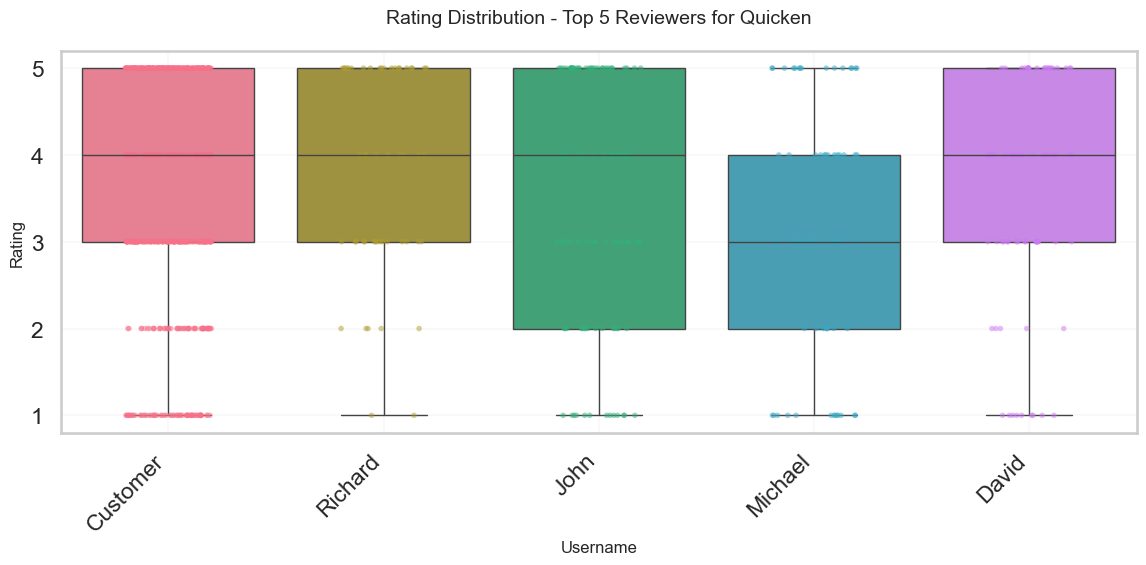

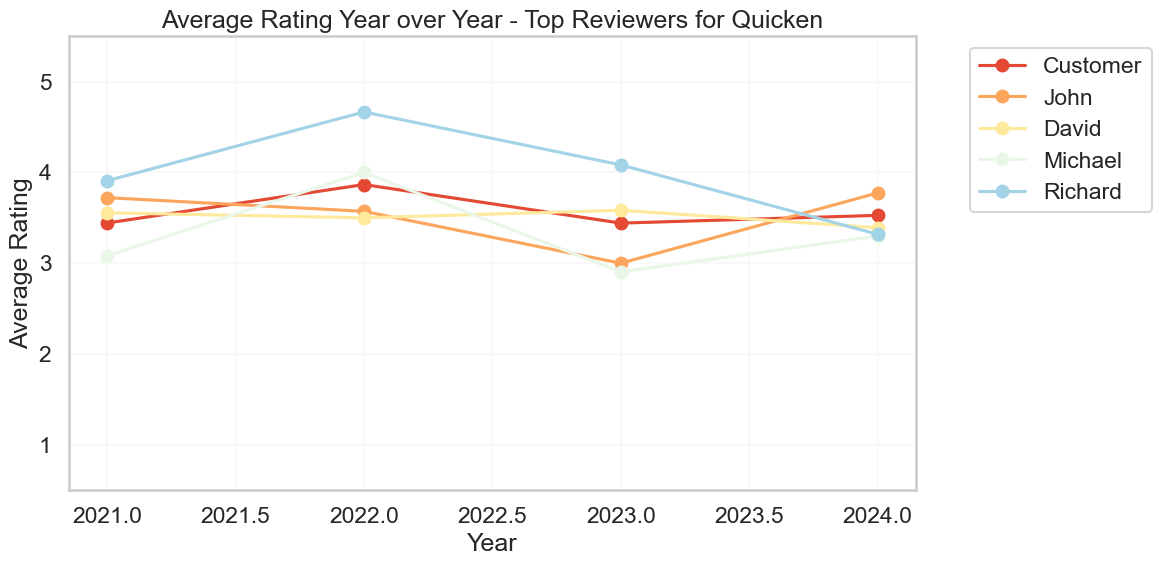

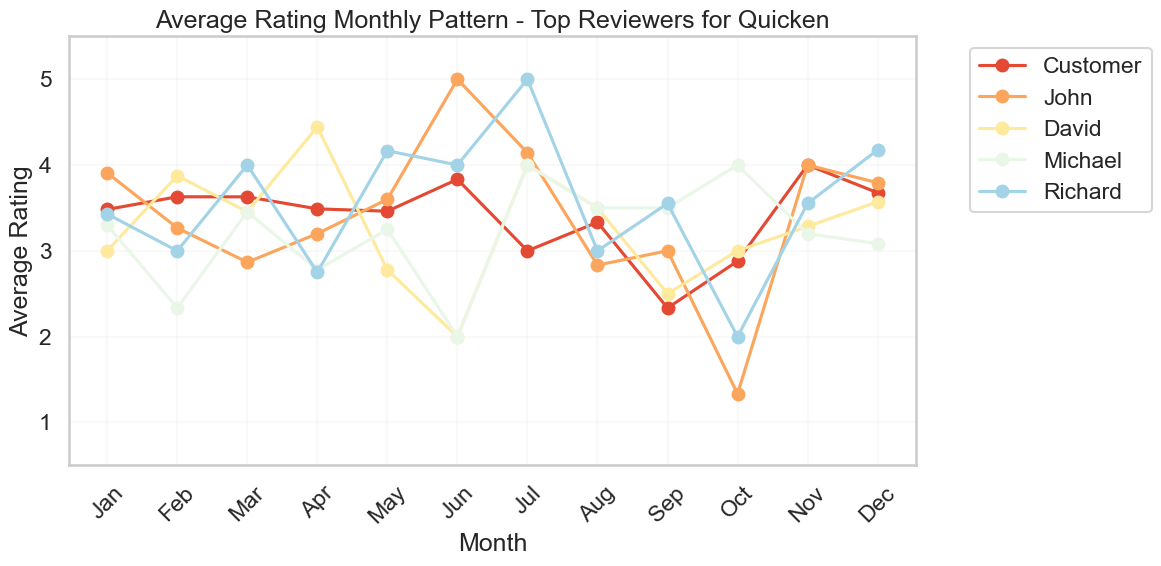

USER ANALYSIS FOR Flashbay
Top 5 reviewers for Flashbay:
username
Customer          125
Jessica            18
Chris              17
Happy Customer     16
David              14
Name: count, dtype: int64
Reviewer Metrics for Flashbay:
                Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Repeat_Reviewer  Pct_Verified
username                                                                                               
Chris                      17       5.000       0.000            5.0                0.176           0.0
Customer                  125       4.960       0.234            5.0                0.184           0.0
David                      14       4.643       1.082            5.0                0.500           0.0
Happy Customer             16       5.000       0.000            5.0                0.125           0.0
Jessica                    18       5.000       0.000            5.0                0.111           0.0


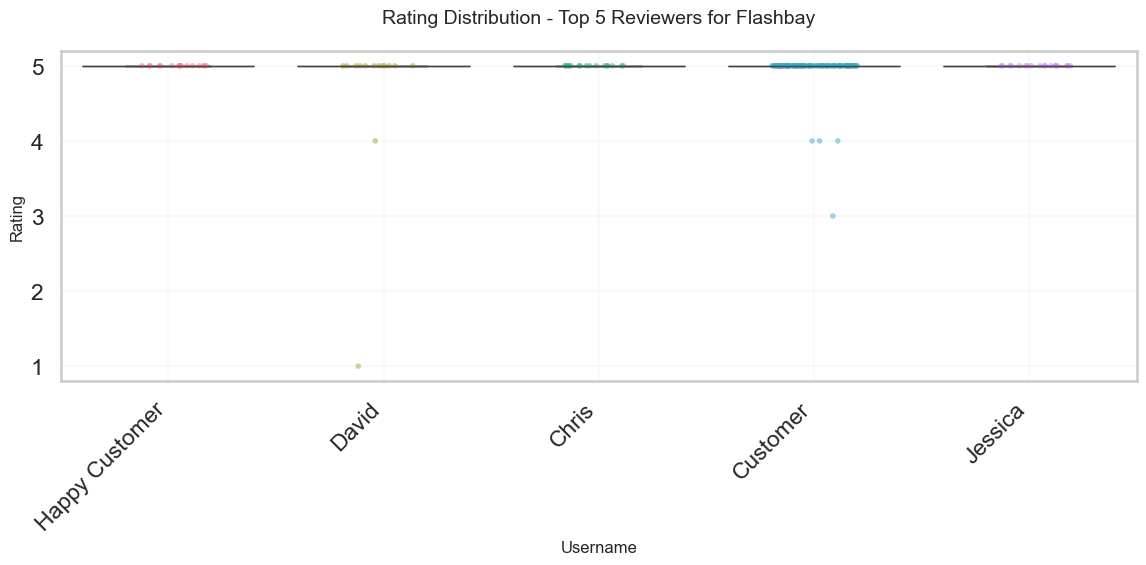

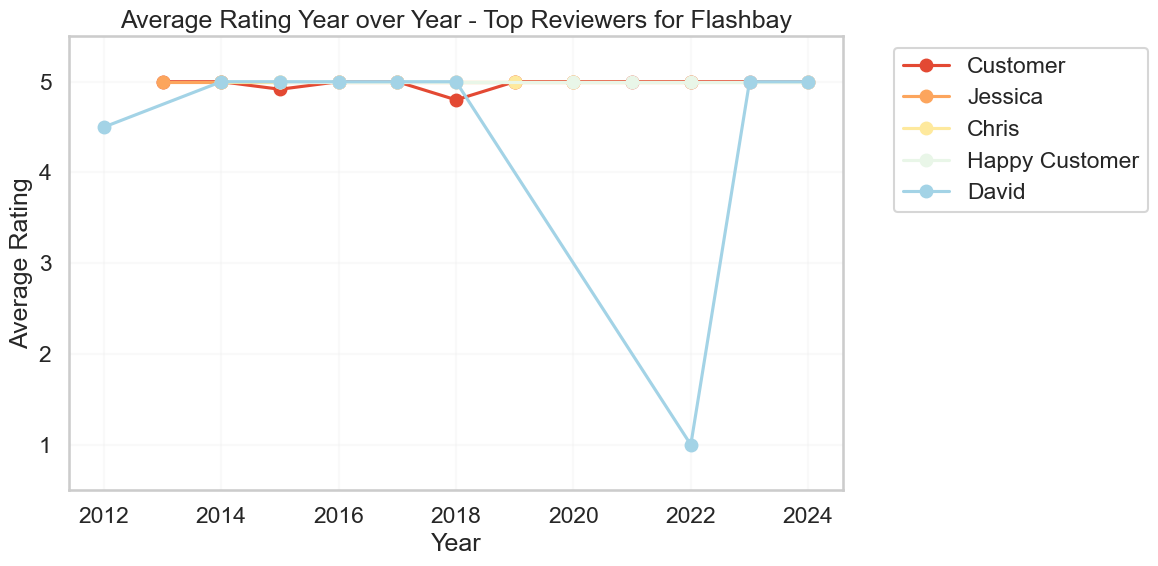

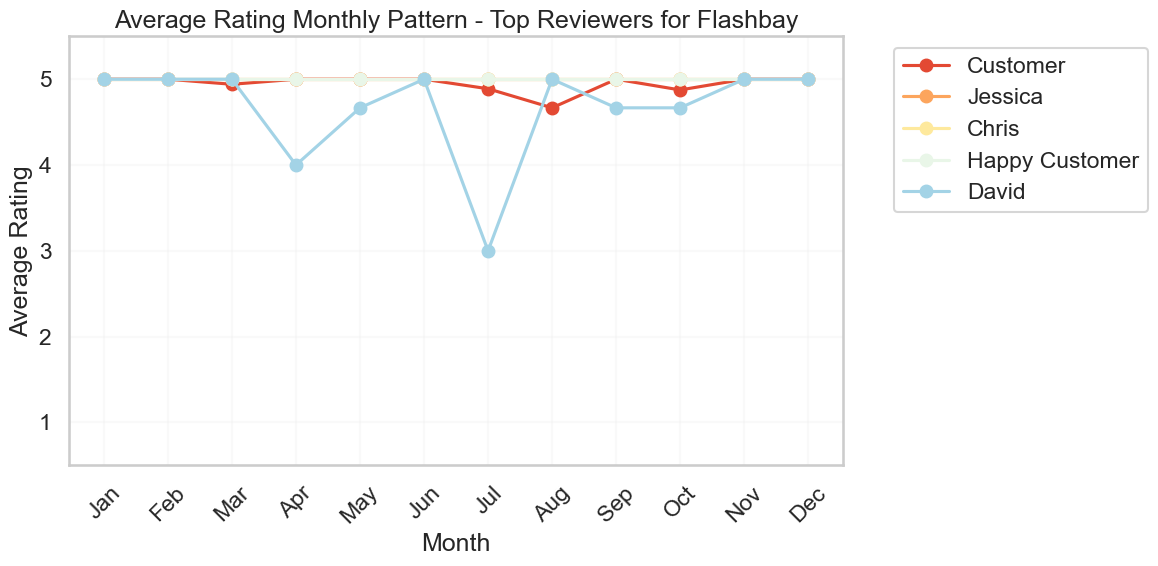

USER ANALYSIS FOR SteelSeries
Top 5 reviewers for SteelSeries:
username
Customer    107
Chris        53
Alex         48
Michael      45
Daniel       42
Name: count, dtype: int64
Reviewer Metrics for SteelSeries:
          Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Repeat_Reviewer  Pct_Verified
username                                                                                         
Alex                 48       3.833       1.562            5.0                0.271           0.0
Chris                53       3.547       1.738            5.0                0.283           0.0
Customer            107       3.664       1.659            5.0                0.682           0.0
Daniel               42       3.381       1.738            4.0                0.381           0.0
Michael              45       3.067       1.900            3.0                0.378           0.0


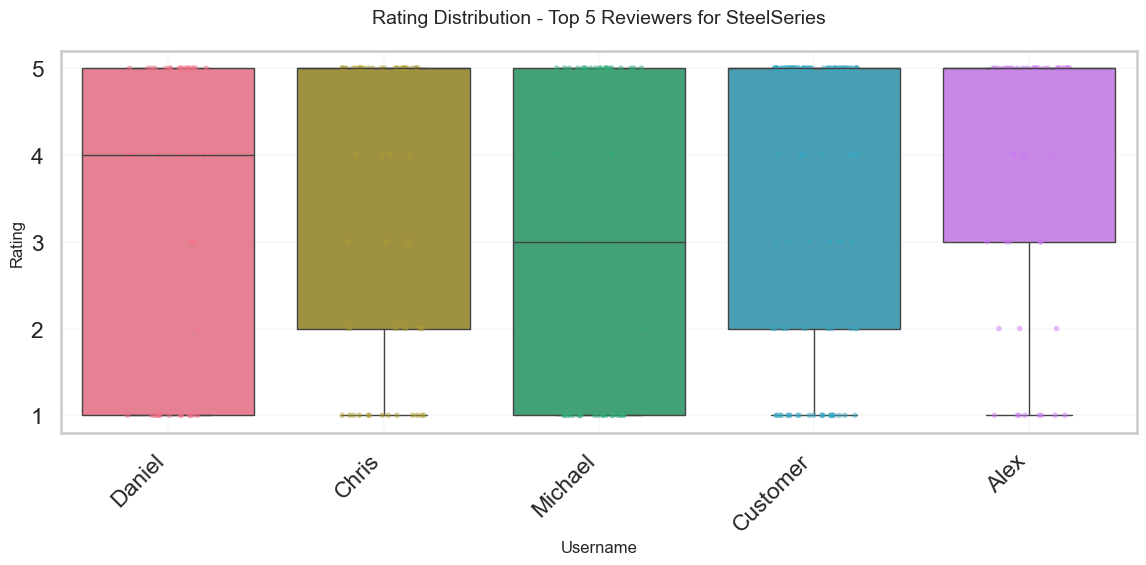

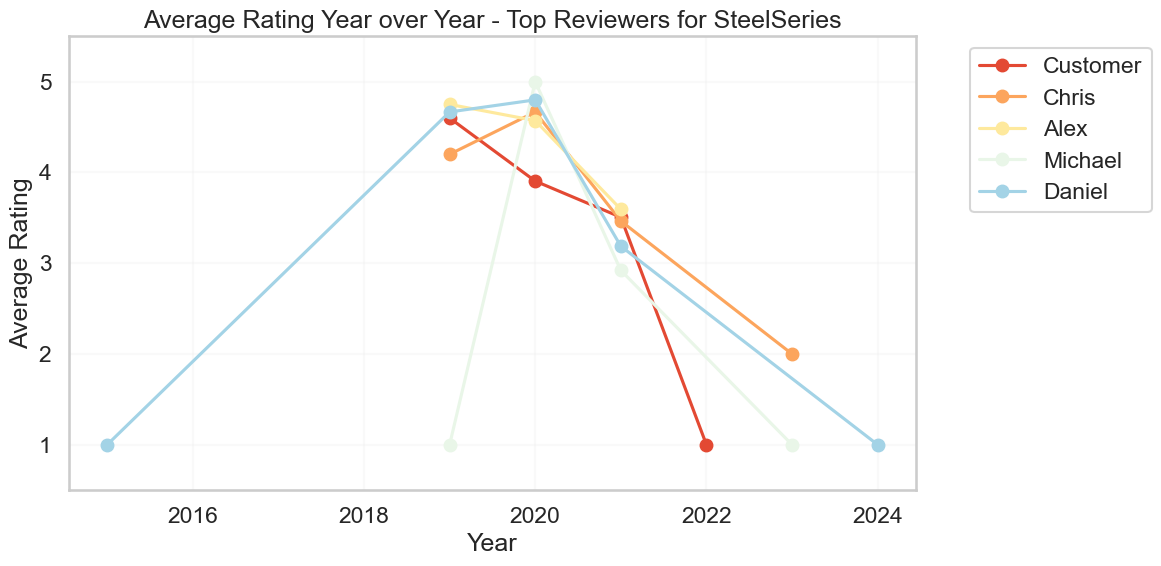

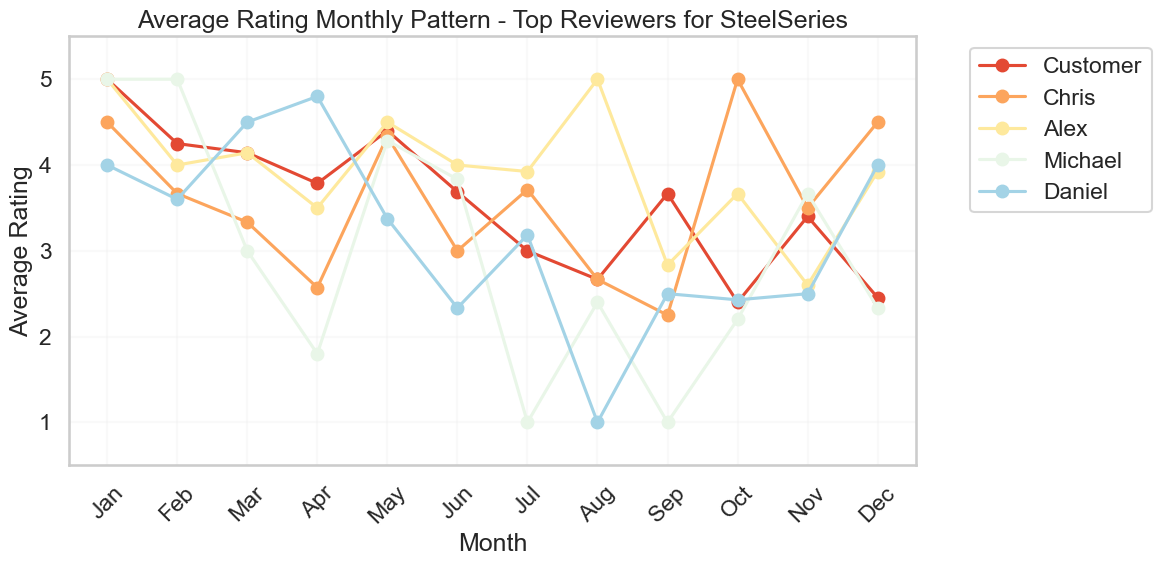

USER ANALYSIS FOR Asda
Top 5 reviewers for Asda:
username
Customer    143
Paul         43
Consumer     38
John         33
Chris        30
Name: count, dtype: int64
Reviewer Metrics for Asda:
          Total_Reviews  Avg_Rating  Std_Rating  Median_Rating  Pct_Repeat_Reviewer  Pct_Verified
username                                                                                         
Chris                30       1.400       1.037            1.0                0.933           0.0
Consumer             38       1.447       1.132            1.0                0.605           0.0
Customer            143       1.455       1.112            1.0                0.979           0.0
John                 33       1.788       1.453            1.0                0.970           0.0
Paul                 43       1.558       1.240            1.0                0.930           0.0


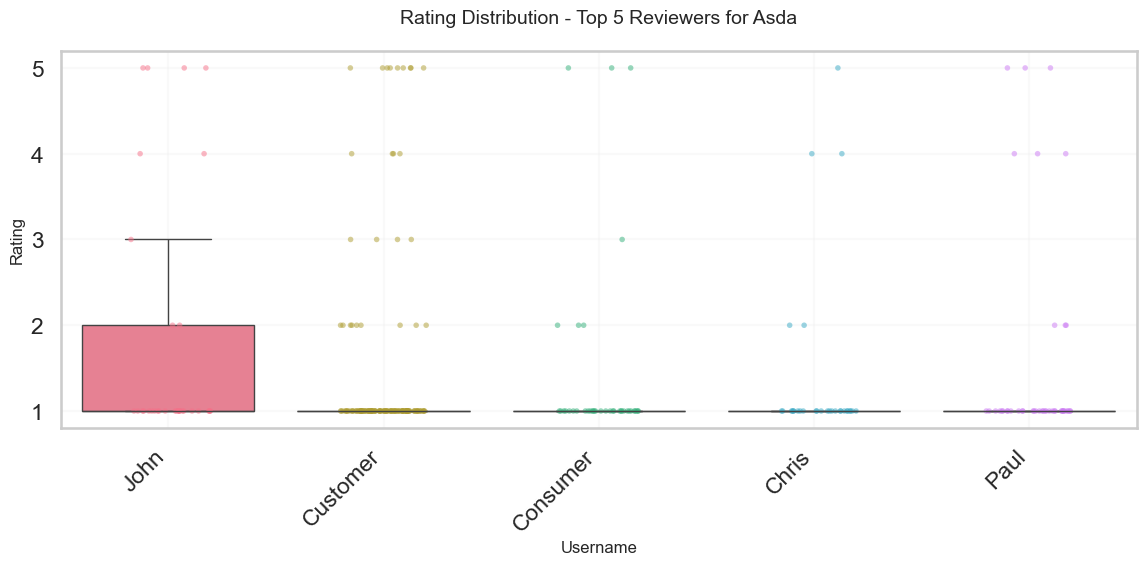

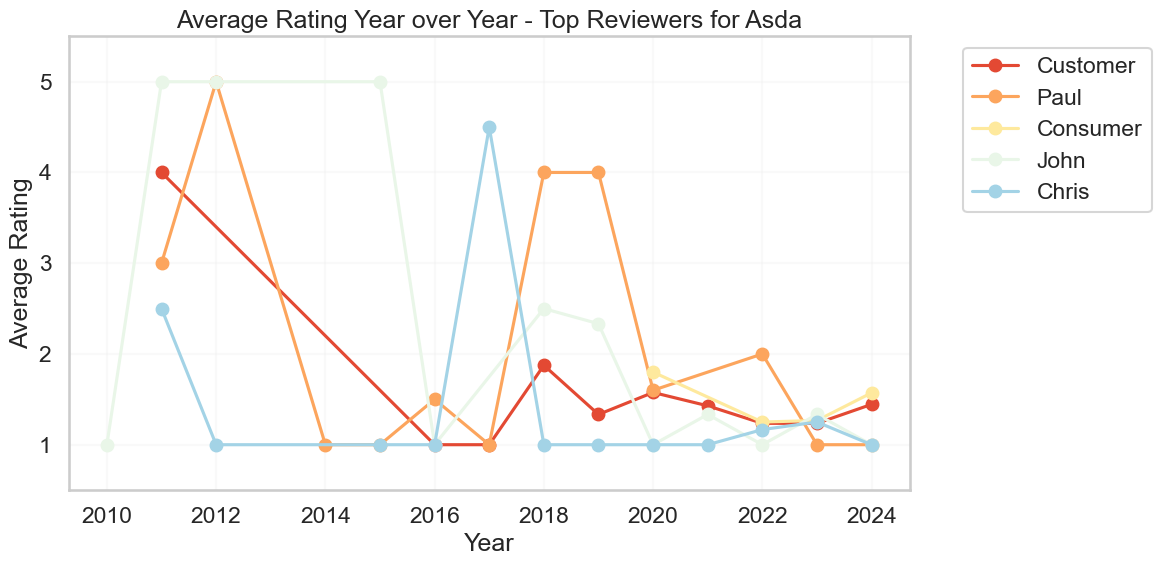

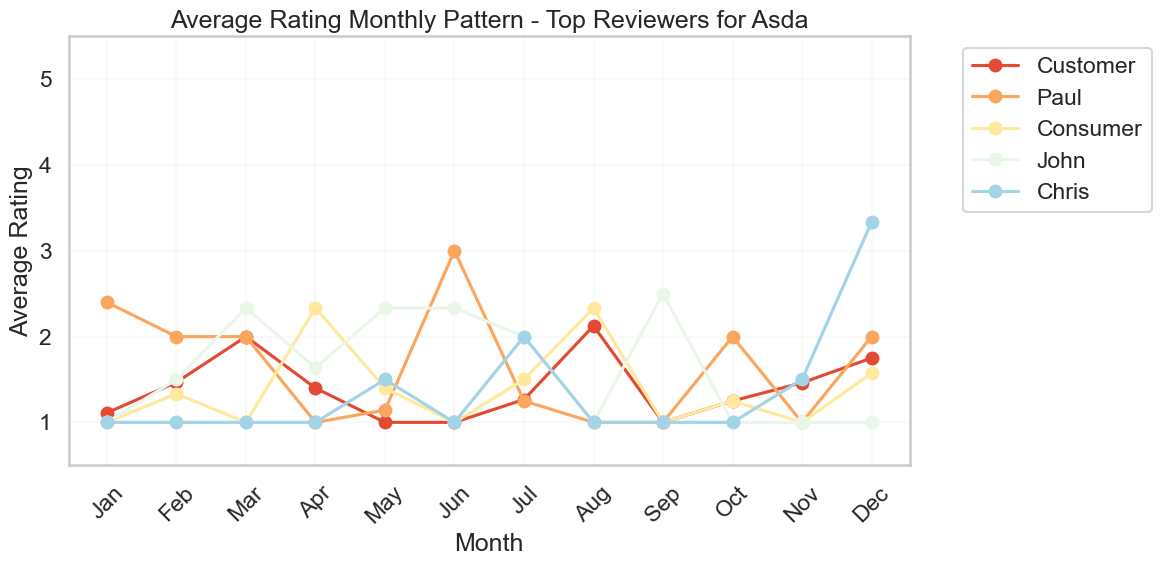

In [263]:
# Username analysis
print("USERNAME ANALYSIS")

top_companies = df_trustpilot['company'].value_counts().head(10)
print("Analyzing user patterns for top 10 companies:")
print(top_companies)

for company in top_companies.index:
    print(f"USER ANALYSIS FOR {company}")
    print("="*50)
    
    # Get company data
    company_data = df_trustpilot[df_trustpilot['company'] == company]
    
    # Get top reviewers
    top_company_users = company_data['username'].value_counts().head(5)
    print(f"Top 5 reviewers for {company}:")
    print(top_company_users)
    
    # Filter data for top reviewers
    df_filtered = company_data[company_data['username'].isin(top_company_users.index)]
    
    # Separate numeric and categorical analyses
    numeric_analysis = df_filtered.groupby('username').agg({
        'rating': ['count', 'mean', 'std', 'median'],
        'repeat_reviewer_encoded': 'mean'
    }).round(3)
    
    # Handle verification separately
    verification_pcts = df_filtered.groupby('username')['verification'].apply(
        lambda x: (x == 'verified').mean()
    ).round(3)
    
    # Combine analyses
    user_analysis = numeric_analysis.copy()
    user_analysis[('verification', 'mean')] = verification_pcts
    
    # Flatten column names
    user_analysis.columns = ['Total_Reviews', 'Avg_Rating', 'Std_Rating', 
                           'Median_Rating', 'Pct_Repeat_Reviewer', 'Pct_Verified']
    
    print(f"Reviewer Metrics for {company}:")
    print(user_analysis)
    
    # Rating distribution plot
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("husl", n_colors=len(top_company_users))
    
    sns.boxplot(x='username', y='rating', data=df_filtered,
                palette=colors,
                boxprops={'zorder': 1},
                showfliers=False)
    
    sns.stripplot(x='username', y='rating', data=df_filtered,
                  palette=colors,
                  size=4,
                  jitter=0.2,
                  alpha=0.5,
                  zorder=2)
    
    plt.title(f'Rating Distribution - Top 5 Reviewers for {company}', fontsize=14, pad=20)
    plt.xlabel('Username', fontsize=12)
    plt.ylabel('Rating', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Year over Year Analysis
    plt.figure(figsize=(12, 6))
    for user in top_company_users.index:
        user_data = df_filtered[df_filtered['username'] == user]
        yearly_avg = user_data.groupby(
            user_data['local_date_posted'].dt.year)['rating'].mean()
        if not yearly_avg.empty:  
            plt.plot(yearly_avg.index, yearly_avg.values, marker='o', label=user)
    
    plt.title(f'Average Rating Year over Year - Top Reviewers for {company}')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.ylim(0.5, 5.5)  
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Monthly Pattern Analysis
    plt.figure(figsize=(12, 6))
    months = range(1, 13)
    
    for user in top_company_users.index:
        user_data = df_filtered[df_filtered['username'] == user]
        user_monthly = user_data.groupby(
            user_data['local_date_posted'].dt.month)['rating'].mean()
        
        if not user_monthly.empty:  
            monthly_avg = pd.Series(index=months)
            monthly_avg[user_monthly.index] = user_monthly
            monthly_avg = monthly_avg.fillna(user_monthly.mean())
            
            plt.plot(months, monthly_avg, marker='o', label=user)
    
    plt.title(f'Average Rating Monthly Pattern - Top Reviewers for {company}')
    plt.xlabel('Month')
    plt.ylabel('Average Rating')
    plt.ylim(0.5, 5.5)  
    plt.xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
               rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

COMPANY ANALYSIS - UNIQUE PATTERNS
Company Metrics:
             Total_Reviews  Avg_Rating  Rating_Std  Repeat_Reviewer_Rate  Unique_Reviewers  Peak_Hour  Verification_Rate  Countries_Present  Avg_Review_Time
company                                                                                                                                                     
Asda                 12301       1.518       1.202                 0.825             10242         16                0.0                 47            0.814
Flashbay             14429       4.972       0.187                 0.138             13327         10                0.0                 59            0.969
Quicken              25318       3.498       1.439                 0.468             21257          8                0.0                 87            0.609
SteelSeries          12387       3.783       1.633                 0.342              9882         15                0.0                122            0.961
Custom

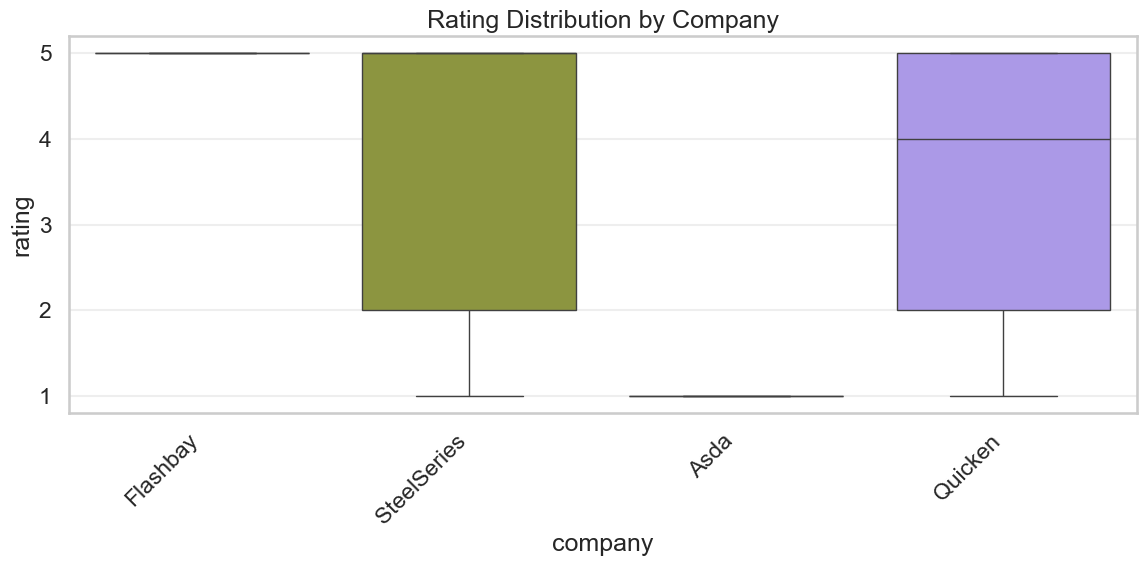

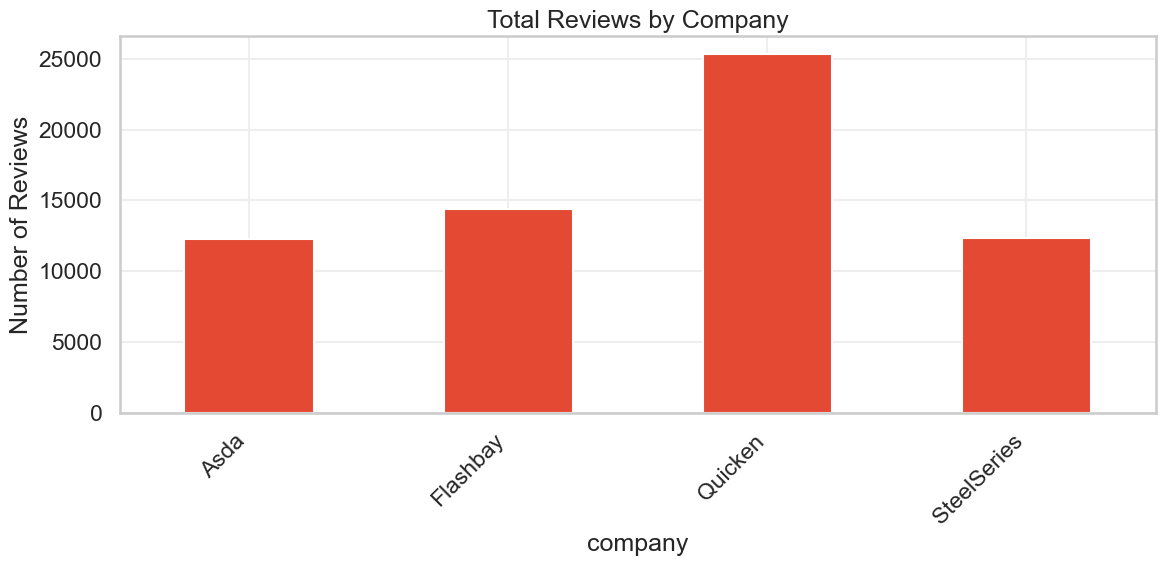

In [264]:
# Company analysis
print("COMPANY ANALYSIS - UNIQUE PATTERNS")
print("="*50)

top_companies = df_trustpilot['company'].value_counts().head(10)
df_filtered = df_trustpilot[df_trustpilot['company'].isin(top_companies.index)]

# Split aggregations by data type
numeric_analysis = df_filtered.groupby('company').agg({
    'rating': ['count', 'mean', 'std'],
    'repeat_reviewer_encoded': 'mean',
    'username': 'nunique',
    'local_hour': lambda x: x.mode()[0]
}).round(3)

# Handle categorical columns separately
verification_rate = df_filtered.groupby('company')['verification'].apply(
    lambda x: (x == 'verified').mean()
).round(3)

location_count = df_filtered.groupby('company')['location'].nunique()

review_time_encoded = df_filtered.groupby('company')['review_time_encoded'].mean().round(3)

# Combine all analyses
company_analysis = numeric_analysis.copy()
company_analysis['verification_rate'] = verification_rate
company_analysis['countries_present'] = location_count
company_analysis['avg_review_time'] = review_time_encoded

# Flatten and rename columns
company_analysis.columns = ['Total_Reviews', 'Avg_Rating', 'Rating_Std',
                          'Repeat_Reviewer_Rate', 'Unique_Reviewers', 
                          'Peak_Hour', 'Verification_Rate', 
                          'Countries_Present', 'Avg_Review_Time']

print("Company Metrics:")
print(company_analysis)

print("Customer Base Analysis:")
print("="*50)

for company in top_companies.index:
    company_data = df_filtered[df_filtered['company'] == company]
    reviews_per_user = company_data.groupby('username').size()
    
    print(f"{company}:")
    print("-"*30)
    print(f"Total Reviews: {len(company_data):,}")
    print(f"Unique Reviewers: {len(reviews_per_user):,}")
    print(f"Reviews per Customer: {reviews_per_user.mean():.2f}")
    print(f"One-time Reviewers: {(reviews_per_user == 1).sum():,} "
          f"({(reviews_per_user == 1).mean()*100:.1f}%)")
    print(f"Loyal Customers (>5 reviews): {(reviews_per_user > 5).sum():,}")
    print(f"Countries: {company_data['location'].nunique()}")
    
    # Handle potential empty mode
    most_common_country = company_data['location'].mode()
    if len(most_common_country) > 0:
        print(f"Most Common Country: {most_common_country[0]}")
    else:
        print("Most Common Country: No data")

# Optional: Add visualizations
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='company', y='rating', 
            palette='husl',
            showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.title('Rating Distribution by Company')
plt.tight_layout()
plt.show()

# Reviews per company
plt.figure(figsize=(12, 6))
company_analysis['Total_Reviews'].plot(kind='bar')
plt.title('Total Reviews by Company')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

Sentiment Scores by Location:
         Sentiment_Blob               Sentiment_VADER              
                   mean    std median            mean    std median
location                                                           
AD                0.287    NaN  0.287          -0.341    NaN -0.341
AE                0.179  0.411  0.211           0.377  0.562  0.586
AF                0.418  0.117  0.418           0.790  0.234  0.790
AG                0.567    NaN  0.567           0.943    NaN  0.943
AI                0.695  0.290  0.695           0.887  0.079  0.887
AL                0.400    NaN  0.400           0.178    NaN  0.178
AM                0.550    NaN  0.550           0.784    NaN  0.784
AR                0.111  0.178  0.000           0.324  0.459  0.372
AT                0.333  0.290  0.328           0.495  0.496  0.681
AU                0.229  0.295  0.219           0.442  0.506  0.633
AW                0.172  0.424  0.035           0.002  0.601  0.101
AX                

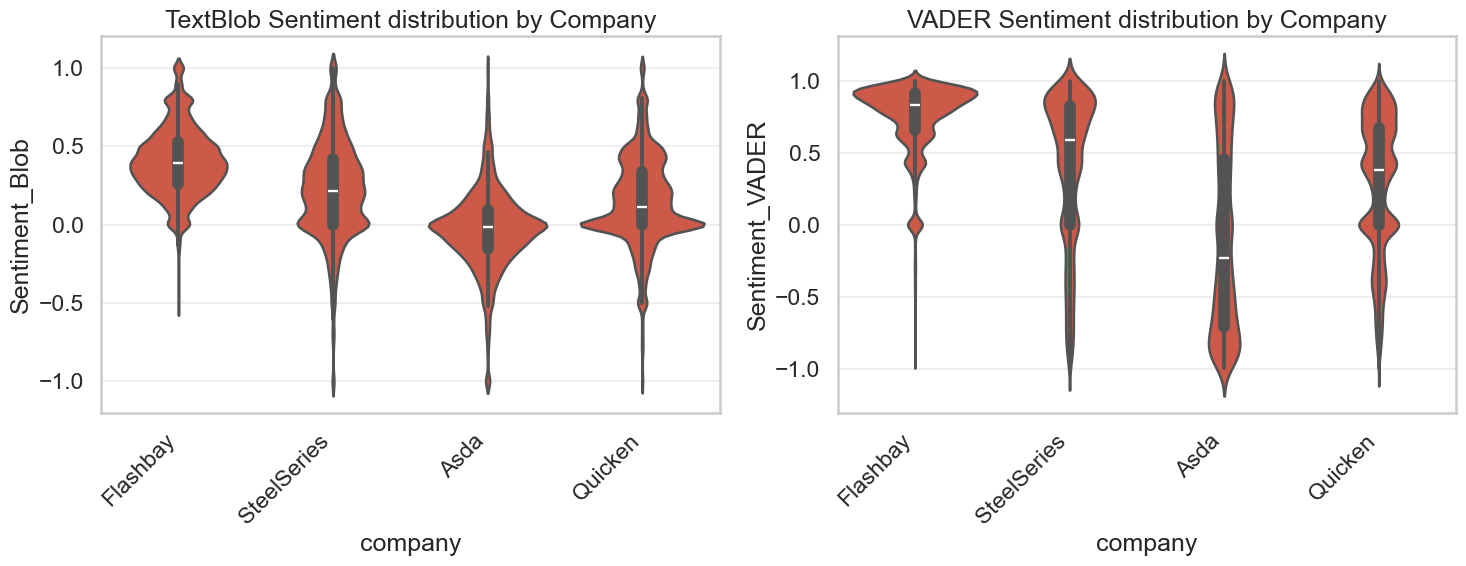

Sentiment Analysis for Top Reviewers of Quicken:
         Sentiment_Blob               Sentiment_VADER              
                   mean    std median            mean    std median
username                                                           
Customer          0.129  0.275  0.083           0.269  0.467  0.382
David             0.139  0.278  0.133           0.294  0.477  0.422
John              0.163  0.283  0.102           0.205  0.459  0.273
Michael           0.115  0.220  0.097           0.303  0.487  0.361
Richard           0.170  0.250  0.166           0.298  0.477  0.440
Sentiment Analysis for Top Reviewers of Flashbay:
               Sentiment_Blob               Sentiment_VADER              
                         mean    std median            mean    std median
username                                                                 
Chris                   0.389  0.254  0.325           0.767  0.193  0.852
Customer                0.435  0.229  0.433           0.722  

In [265]:
#sentiment
def analyze_sentiment_by_groups():
    # Location analysis
    location_sentiment = df_filtered.groupby('location').agg({
        'Sentiment_Blob': ['mean', 'std', 'median'],
        'Sentiment_VADER': ['mean', 'std', 'median']
    }).round(3)
    print("Sentiment Scores by Location:")
    print(location_sentiment)
    
    # Company analysis
    company_sentiment = df_filtered.groupby('company').agg({
        'Sentiment_Blob_cat': ['mean', 'std', 'median'],
        'Sentiment_VADER_cat': ['mean', 'std', 'median']
    }).round(3)
    print("Sentiment Scores by Company:")
    print(company_sentiment)
    
    # Visualize for top companies
    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    sns.violinplot(data=df_filtered, x='company', y='Sentiment_Blob')
    plt.xticks(rotation=45, ha='right')
    plt.title('TextBlob Sentiment distribution by Company')
    
    plt.subplot(122)
    sns.violinplot(data=df_filtered, x='company', y='Sentiment_VADER')
    plt.xticks(rotation=45, ha='right')
    plt.title('VADER Sentiment distribution by Company')
    plt.tight_layout()
    plt.show()
    
    # Username analysis (top reviewers per company)
    for company in top_companies.index:
        company_data = df_filtered[df_filtered['company'] == company]
        top_reviewers = company_data['username'].value_counts().head(5).index
        reviewer_sentiment = company_data[company_data['username'].isin(top_reviewers)].groupby('username').agg({
            'Sentiment_Blob': ['mean', 'std', 'median'],
            'Sentiment_VADER': ['mean', 'std', 'median']
        }).round(3)
        print(f"Sentiment Analysis for Top Reviewers of {company}:")
        print(reviewer_sentiment)

analyze_sentiment_by_groups()

In [266]:
#Inspecting final output 
df_trustpilot = df_trustpilot.drop('avg_word_length', axis=1)
print(df_trustpilot.columns)
print(df_trustpilot.info())
print("The Trustpilot dataset has ", df_trustpilot.shape[1], "columns")
print("The Trustpilot dataset has ", df_trustpilot.shape[0], "rows")
display(df_trustpilot.head())

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64435 entries, 0 to 64434
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            64435 non-null  in

rating location               username  number_reviews  verification repeat_reviewer  repeat_reviewer_encoded   company                                                                                                                                                                                                                                                                                          text                                                                                                                                                                                              text_processed  text_length  text_word_length  Sentiment_Blob  Sentiment_Blob_cat  Sentiment_VADER  Sentiment_VADER_cat                                    subject                      subject_processed  subject_length  subject_word_length answer answer_processed  answered_encoded date_of_experience         date_posted local_date_posted  month_local  local_hour     time_of_day  day_of_week_posted      day_type  days_between_experience_and_post   review_time  review_time_encoded
0       5       CA              Rob Crane               2    Redirected          repeat                        1  Flashbay                                                                                                                  The company rep I worked with made my transaction smooth and quick. The samples were so helpful and the item shipping was relatively very fast. I will be a repeat customer.                                                                                              company rep worked made transaction smooth quick samples helpful item shipping relatively fast repeat customer          110                15           0.311                 4.0            0.421                    4     The company rep I worked with made my…                company rep worked made              23                    4      0                0                 0         2024-06-15 2024-10-23 04:17:44        2024-10-22           10          21         Evening                   1  Business Day                               129   late_review                    0
1       5       US           Pat Anderson               1      Verified        one-time                        0  Flashbay  I highly recommend using Flashbay. Immediately after ordering I heard from them and they were attentive to every little detail. I had notebooks shipped to Alaska for a conference and they arrived in perfect condition and delivered on time! Can't say enough good things about Flashbay!  highly recommend using flashbay immediately ordering heard attentive every little detail notebooks shipped alaska conference arrived perfect condition delivered time cant say enough good things flashbay          202                26           0.345                 4.0            0.623                    5          I highly recommend using Flashbay        highly recommend using flashbay              31                    4      0                0                 0         2024-10-16 2024-10-16 19:34:05        2024-10-16           10          12  Business Hours                   2  Business Day                                 0  quick_review                    1
2       5       CZ       Margarita Orlova               1      Verified        one-time                        0  Flashbay                      I had the pleasure of working with Shelby Gibson on a large order that we needed to ship to different locations. Shelby was very responsive, very kind and helpful. The order process was smooth and the final products look great. Only positive feedback from my side.                             pleasure working shelby gibson large order needed ship different locations shelby responsive kind helpful order process smooth final products look great positive feedback side          175                24           0.320                 4.0            0.964                    5                     Great customer service   

In [267]:
import os

os.makedirs('data', exist_ok=True)

csv_path = 'data/data_trustpilot_2.csv'
df_trustpilot.to_csv(csv_path, index=False)
print(f"DataFrame exported to {csv_path}")

DataFrame exported to data/data_trustpilot_2.csv
